In [1]:
import sys
import os
import random
import pandas as pd
import numpy as np
import tifffile as tiff
import time
from PIL import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '../')
from src.models.Unet import Unet
from src.utils import get_model_name, extract_collapsed_cls
from src.models.params import get_params
from src.models.evaluate_model import calculate_evaluation_criteria, evaluate_test_set
from src.visualization.visualization_utils import overlay_images
from src.utils import load_product, extract_collapsed_cls, extract_cls_mask, image_normalizer, get_cls

%load_ext autoreload
%autoreload 2

pd.options.display.max_columns = 9999
pd.options.mode.chained_assignment = None  # default='warn'

Using TensorFlow backend.


# Evaluate Biome dataset with models trained on SPARCS (to avoid cross-val when performing the timing analysis)

In [2]:
params = get_params('U-net', 'Landsat8')  # Needed for project path
## params = get_params('U-net', 'Landsat8')
df = pd.read_csv(params.project_path + 'reports/Unet/param_optimization_SPARCSTrain_BiomeEval.csv')

# Add columns with timestamp and cross-validation fold number
df['timestamp'] = df['modelID'].astype(str).str[0:12]
df['cross-val'] = df['modelID'].astype(str).str[15:]

# Get product names of the categories 
products_clear = []
products_clear = np.append(products_clear, params.test_tiles[0][0::6]) # Every 6th product is clear in train_tiles
products_clear = np.append(products_clear, params.test_tiles[0][1::6])
products_clear = np.append(products_clear, params.test_tiles[1][0::6])
products_clear = np.append(products_clear, params.test_tiles[1][1::6])
products_midcl = []
products_midcl = np.append(products_midcl, params.test_tiles[0][2::6])
products_midcl = np.append(products_midcl, params.test_tiles[0][3::6])
products_midcl = np.append(products_midcl, params.test_tiles[1][2::6])
products_midcl = np.append(products_midcl, params.test_tiles[1][3::6])
products_cloud = []
products_cloud = np.append(products_cloud, params.test_tiles[0][4::6])
products_cloud = np.append(products_cloud, params.test_tiles[0][5::6])
products_cloud = np.append(products_cloud, params.test_tiles[1][4::6])
products_cloud = np.append(products_cloud, params.test_tiles[1][5::6])

products_barren = np.append(params.test_tiles[0][0:6], params.test_tiles[1][0:6])
products_forest = np.append(params.test_tiles[0][6:12], params.test_tiles[1][6:12])
products_grasscrops = np.append(params.test_tiles[0][12:18], params.test_tiles[1][12:18])
products_shrubland = np.append(params.test_tiles[0][18:24], params.test_tiles[1][18:24])
products_snowice = np.append(params.test_tiles[0][24:30], params.test_tiles[1][24:30])
products_urban = np.append(params.test_tiles[0][30:36], params.test_tiles[1][30:36])
products_water = np.append(params.test_tiles[0][36:42], params.test_tiles[1][36:42])
products_wetlands = np.append(params.test_tiles[0][42:48], params.test_tiles[1][42:48])

products_total = np.append(params.test_tiles[0][:], params.test_tiles[1][:])

product_categories = ['Barren', 'Forest', 'GrassCrops', 'Shrubland', 'SnowIce', 'Urban', 'Water', 'Wetlands', 'Clear', 'MidCl', 'Cloud', 'Total']
product_names = [products_barren, 
                 products_forest, 
                 products_grasscrops,
                 products_shrubland,
                 products_snowice,
                 products_urban,
                 products_water,
                 products_wetlands,
                 products_clear, 
                 products_midcl, 
                 products_cloud, 
                 products_total]

# Now loop over categories and sum evaluation results

# Sum the evaluation criteria for the products in the specific categories
for i, category in enumerate(product_categories):
    # Get location of products in the respected cross_val fold
    col_location = [df.columns.get_loc(col) for col in df.columns if df[col].iloc[0] in product_names[i]]  # Get indices for columns        

    # Use locations to sum up tp, fp, fn, and fp for the respective category and cross_val fold        
    df['total_tp_' + category] = df.iloc[:, np.array(col_location) + 2].sum(axis=1)
    df['total_fp_' + category] = df.iloc[:, np.array(col_location) + 3].sum(axis=1)
    df['total_fn_' + category] = df.iloc[:, np.array(col_location) + 4].sum(axis=1)
    df['total_tn_' + category] = df.iloc[:, np.array(col_location) + 5].sum(axis=1)
    df['total_npix_' + category] = df.iloc[:, np.array(col_location) + 6].sum(axis=1)
               
# Calculate accuracy, precision, recall, and f-score (4 for loops to make it directly usable in the latex code for the table)
for category in product_categories:
    df[category + '_accuracy'] = (df['total_tp_' + category] + df['total_tn_' + category]) / df['total_npix_' + category]

for category in product_categories:
    df[category + '_precision'] = df['total_tp_' + category] / (df['total_tp_' + category] + df['total_fp_' + category])

for category in product_categories:
    df[category + '_recall'] = df['total_tp_' + category] / (df['total_tp_' + category] + df['total_fn_' + category])

for category in product_categories:
    df[category + '_f-score'] = 2 * (df[category + '_precision'] * df[category + '_recall']) / (df[category + '_precision'] + df[category + '_recall'])

# Now merge with original dataframe to avoid using the summed hyperparameters
df_overview = df.iloc[:, pd.np.r_[0, 3,13, 14, 16, 26, 20, 33, -48:0]].drop_duplicates().reset_index()

# Investigate results
df_overview.\
loc[df_overview['modelID'].astype(int) > 180713000000].\
loc[df_overview['threshold'] == 0.50].\
sort_values('Total_accuracy', ascending=False).\
drop_duplicates(['modelID']).\
drop_duplicates(['bands']).\
sort_values('bands', ascending=False).head(5)

/home/jhj/anaconda3/envs/CloudDetection/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jhj/anaconda3/envs/CloudDetection/lib/python3.6/site-packages/ipykernel/__main__.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


,index,modelID,loss_func,learning_rate,dropout,L2reg,epochs,threshold,bands,Barren_accuracy,Forest_accuracy,GrassCrops_accuracy,Shrubland_accuracy,SnowIce_accuracy,Urban_accuracy,Water_accuracy,Wetlands_accuracy,Clear_accuracy,MidCl_accuracy,Cloud_accuracy,Total_accuracy,Barren_precision,Forest_precision,GrassCrops_precision,Shrubland_precision,SnowIce_precision,Urban_precision,Water_precision,Wetlands_precision,Clear_precision,MidCl_precision,Cloud_precision,Total_precision,Barren_recall,Forest_recall,GrassCrops_recall,Shrubland_recall,SnowIce_recall,Urban_recall,Water_recall,Wetlands_recall,Clear_recall,MidCl_recall,Cloud_recall,Total_recall,Barren_f-score,Forest_f-score,GrassCrops_f-score,Shrubland_f-score,SnowIce_f-score,Urban_f-score,Water_f-score,Wetlands_f-score,Clear_f-score,MidCl_f-score,Cloud_f-score,Total_f-score
7913,7913,180724091821,binary_crossentropy,0.00022,0.18,0.00018,25,0.5,123456791011,0.938450,0.940231,0.957379,0.932371,0.628771,0.955497,0.958118,0.966432,0.925455,0.891157,0.912344,0.909604,0.891333,0.971686,0.947880,0.916859,0.501058,0.924029,0.936048,0.950629,0.354781,0.846402,0.942644,0.869789,0.987821,0.923674,0.963255,0.947566,0.845423,0.984985,0.978492,0.986755,0.869013,0.948571,0.961733,0.954475,0.937100,0.947072,0.955506,0.931960,0.629205,0.953534,0.956799,0.968355,0.503858,0.894578,0.952093,0.910166
7742,7742,180724003729,binary_crossentropy,0.00039,0.38,0.00046,76,0.5,12345679,0.931853,0.946919,0.952556,0.940342,0.682372,0.956423,0.960915,0.956642,0.930263,0.903913,0.913792,0.915948,0.915999,0.966776,0.936754,0.924575,0.551353,0.938673,0.934855,0.942506,0.372017,0.883279,0.946423,0.887235,0.939315,0.940638,0.965313,0.955929,0.791510,0.969331,0.986269,0.976251,0.873523,0.924845,0.959110,0.944904,0.927511,0.953528,0.950819,0.939991,0.649956,0.953755,0.959874,0.959081,0.521807,0.903584,0.952724,0.915162
7761,7761,180724021804,binary_crossentropy,0.00021,0.00,0.00047,41,0.5,2345,0.917382,0.904137,0.895332,0.931559,0.761150,0.941368,0.902279,0.887962,0.944350,0.876928,0.856735,0.892536,0.875402,0.935119,0.933010,0.927929,0.665803,0.942639,0.923837,0.887102,0.427887,0.841077,0.970386,0.890392,0.958411,0.896621,0.840003,0.932397,0.720590,0.930126,0.865159,0.899182,0.823654,0.921283,0.868315,0.884948,0.915028,0.915466,0.884067,0.930158,0.692114,0.936341,0.893536,0.893101,0.563195,0.879355,0.916517,0.887662
7780,7780,180724031755,binary_crossentropy,0.00076,0.00,0.00073,3,0.5,234,0.855594,0.913147,0.946538,0.927162,0.379469,0.970158,0.914603,0.877599,0.795531,0.829191,0.918422,0.847835,0.828313,0.937547,0.979084,0.936651,0.371289,0.959786,0.895119,0.845963,0.146031,0.811180,0.939026,0.793199,0.868996,0.910635,0.906844,0.912714,0.960003,0.976545,0.928642,0.935105,0.762035,0.846099,0.973114,0.923651,0.848167,0.923895,0.941580,0.924527,0.535478,0.968093,0.911573,0.888303,0.245094,0.828271,0.955766,0.853469
7894,7894,180724083004,binary_crossentropy,0.00023,0.00,0.00065,38,0.5,3,0.855061,0.853033,0.864914,0.866618,0.574670,0.933362,0.878067,0.883963,0.911108,0.836205,0.768971,0.838582,0.881486,0.957286,0.934005,0.919151,0.463421,0.943663,0.894517,0.933991,0.301097,0.796419,0.944548,0.836183,0.794554,0.780987,0.770081,0.797243,0.897243,0.910620,0.842049,0.836159,0.787776,0.891423,0.791371,0.825221,0.835766,0.860196,0.844159,0.853868,0.611174,0.926847,0.867491,0.882372,0.435675,0.841247,0.861202,0.830666


No do the analysis.

In [3]:
modelID = '180724083004'
num_gpus = 2

params = get_params(model='U-net', satellite='Landsat8')
params.modelID = modelID
params.bands=[3]
params.test_dataset = 'Biome_gt'
params.split_dataset = False

# Run model on test data set and save output
model = Unet(params)
evaluate_test_set(model, params.test_dataset, params.num_gpus, params, save_output=True, write_csv=False)

Weights loaded from model: Unet_Landsat8_180724083004
------------------------------------------
Evaluate model on visualization data set:
#########################
TESTING BIOME: Barren
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  1 : LC80420082013220LGN00
threshold=0.05: tp=0: fp=6899372: fn=0: tn=33871012: Accuracy=0.8307749075897838: precision=0: recall=0: omission=1.0: comission=0.2036954785998127: pixel_jaccard=0
threshold=0.1: tp=0: fp=4058173: fn=0: tn=36712211: Accuracy=0.9004627231374618: precision=0: recall=0: omission=1.0: comission=0.11054014153492417: pixel_jaccard=0
threshold=0.15: tp=0: fp=2775681: fn=0: tn=37994703: Accuracy=0.9319191842784704: precision=0: recall=0: omission=1.0: comission=0.0730544202437903: pixel_jaccard=0
threshold=0.2: tp=0: fp=2031068: fn=0: tn=38739316: Accuracy=0.9501827601133215: precision=0: recall=0: omission=1.0: comission=0.052429113616

Data loaded in                       : 4.4060351848602295s
Prediction finished in               : 5.581532955169678s
Threshold loop finished in           : 9.003045797348022s
Results saved in                     : 7.4794580936431885s
Total time for product finished in   : 26.862573623657227s
------------------------------------------
Testing product  3 : LC80530022014156LGN00
threshold=0.05: tp=0: fp=17036325: fn=0: tn=23748204: Accuracy=0.5822846207197833: precision=0: recall=0: omission=1.0: comission=0.7173731958846236: pixel_jaccard=0
threshold=0.1: tp=0: fp=14772463: fn=0: tn=26012066: Accuracy=0.6377924825366992: precision=0: recall=0: omission=1.0: comission=0.5679081008021432: pixel_jaccard=0
threshold=0.15: tp=0: fp=13492404: fn=0: tn=27292125: Accuracy=0.669178378889701: precision=0: recall=0: omission=1.0: comission=0.4943698594374751: pixel_jaccard=0
threshold=0.2: tp=0: fp=12554797: fn=0: tn=28229732: Accuracy=0.6921676599477219: precision=0: recall=0: omission=1.0: comiss

Data loaded in                       : 3.3800365924835205s
Prediction finished in               : 5.031956911087036s
Threshold loop finished in           : 8.235842943191528s
Results saved in                     : 8.794469118118286s
Total time for product finished in   : 25.75806951522827s
------------------------------------------
Testing product  5 : LC81360302014162LGN00
threshold=0.05: tp=17177178: fp=2346466: fn=13873165: tn=7156029: Accuracy=0.6000370923485059: precision=0.879814137155953: recall=0.5532041304664492: omission=0.12018586284404695: comission=0.11158135685086171: pixel_jaccard=0.5143359055651096
threshold=0.1: tp=15114047: fp=1753975: fn=15936296: tn=7748520: Accuracy=0.56377230614538: precision=0.8960177429220806: recall=0.48675942162700103: omission=0.10398225707791939: comission=0.07405482905165908: pixel_jaccard=0.4607334619789992
threshold=0.15: tp=13844208: fp=1429571: fn=17206135: tn=8072924: Accuracy=0.5404586480482574: precision=0.9064035822437918: recall=0.

Data loaded in                       : 3.60909104347229s
Prediction finished in               : 4.8721091747283936s
Threshold loop finished in           : 8.033594846725464s
Results saved in                     : 7.8633832931518555s
Total time for product finished in   : 24.701398372650146s
------------------------------------------
Testing product  7 : LC81550082014263LGN00
threshold=0.05: tp=40513988: fp=0: fn=260067: tn=0: Accuracy=0.993621752852396: precision=1.0: recall=0.993621752852396: omission=0: comission=0: pixel_jaccard=0.993621752852396
threshold=0.1: tp=40146413: fp=0: fn=627642: tn=0: Accuracy=0.9846068290239958: precision=1.0: recall=0.9846068290239958: omission=0: comission=0: pixel_jaccard=0.9846068290239958
threshold=0.15: tp=39738262: fp=0: fn=1035793: tn=0: Accuracy=0.9745967625736514: precision=1.0: recall=0.9745967625736514: omission=0: comission=0: pixel_jaccard=0.9745967625736514
threshold=0.2: tp=39311765: fp=0: fn=1462290: tn=0: Accuracy=0.96413675313873: pre

Data loaded in                       : 3.3874330520629883s
Prediction finished in               : 4.892489194869995s
Threshold loop finished in           : 7.603480100631714s
Results saved in                     : 8.745724439620972s
Total time for product finished in   : 24.931511878967285s
------------------------------------------
Testing product  9 : LC81640502013179LGN01
threshold=0.05: tp=2897980: fp=5624058: fn=57473: tn=31886760: Accuracy=0.8595983553809542: precision=0.34005715534241926: recall=0.9805535733439171: omission=0.6599428446575807: comission=0.17605863318114415: pixel_jaccard=0.3377791578098099
threshold=0.1: tp=2848941: fp=4056479: fn=106512: tn=33454339: Accuracy=0.8971244224603745: precision=0.4125659264751456: recall=0.9639608547319142: omission=0.5874340735248544: comission=0.12086937247211044: pixel_jaccard=0.40629900575190975
threshold=0.15: tp=2805139: fp=3286888: fn=150314: tn=34223930: Accuracy=0.9150600755873948: precision=0.46046069723591176: recall=0.949

Data loaded in                       : 3.192026138305664s
Prediction finished in               : 4.413028240203857s
Threshold loop finished in           : 7.802155256271362s
Results saved in                     : 8.811320781707764s
Total time for product finished in   : 24.484221696853638s
------------------------------------------
Testing product  11 : LC81930452013126LGN01
threshold=0.05: tp=23900457: fp=5198682: fn=416821: tn=8291100: Accuracy=0.8514694609948512: precision=0.8213458480678758: recall=0.982859060130003: omission=0.17865415193212417: comission=0.5970061051311788: pixel_jaccard=0.8097468962554496
threshold=0.1: tp=23724692: fp=4510164: fn=592586: tn=8979618: Accuracy=0.8650318220988356: precision=0.8402625464071785: recall=0.9756310718658561: omission=0.15973745359282157: comission=0.47117299213430885: pixel_jaccard=0.8229898441908234
threshold=0.15: tp=23585163: fp=4097952: fn=732115: tn=9391830: Accuracy=0.8722443109831868: precision=0.8519692599622549: recall=0.96989

Data loaded in                       : 3.486358404159546s
Prediction finished in               : 4.662504434585571s
Threshold loop finished in           : 7.850499391555786s
Results saved in                     : 8.736022472381592s
Total time for product finished in   : 25.05421781539917s
#########################
TESTING BIOME: Forest
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  13 : LC80070662014234LGN00
threshold=0.05: tp=1772976: fp=2008877: fn=318876: tn=36430689: Accuracy=0.9425691694280225: precision=0.4688114530099398: recall=0.8475628294927174: omission=0.5311885469900601: comission=0.054663966770763135: pixel_jaccard=0.4323562956732815
threshold=0.1: tp=1729165: fp=1080274: fn=362687: tn=37359292: Accuracy=0.9643989509570082: precision=0.6154840877484793: recall=0.8266191872082729: omission=0.38451591225152065: comission=0.028637787004759215: pixel_jaccard=0.54511233160347

Data loaded in                       : 3.3256189823150635s
Prediction finished in               : 4.566206455230713s
Threshold loop finished in           : 8.11730432510376s
Results saved in                     : 6.741793870925903s
Total time for product finished in   : 23.10746192932129s
------------------------------------------
Testing product  15 : LC80200462014005LGN00
threshold=0.05: tp=4732425: fp=4769728: fn=4222: tn=30915783: Accuracy=0.8818976958132715: precision=0.49803712905906694: recall=0.9991086521752623: omission=0.5019628709409331: comission=0.154260259660372: pixel_jaccard=0.4978159393038882
threshold=0.1: tp=4721462: fp=3158612: fn=15185: tn=32526899: Accuracy=0.9214837317690956: precision=0.5991646778951568: recall=0.9967941457322026: omission=0.4008353221048432: comission=0.09706237621413552: pixel_jaccard=0.5980123007997584
threshold=0.15: tp=4699168: fp=2400337: fn=37479: tn=33285174: Accuracy=0.9396910971452835: precision=0.6619007944920103: recall=0.99208744075

Data loaded in                       : 3.8096656799316406s
Prediction finished in               : 5.136052846908569s
Threshold loop finished in           : 9.17659044265747s
Results saved in                     : 7.220288991928101s
Total time for product finished in   : 25.700851917266846s
------------------------------------------
Testing product  17 : LC81170272014189LGN00
threshold=0.05: tp=39908444: fp=119795: fn=513638: tn=64100: Accuracy=0.9844004984783398: precision=0.9970072378152833: recall=0.987293133490749: omission=0.0029927621847166447: comission=0.20735177537222754: pixel_jaccard=0.9843758343995765
threshold=0.1: tp=39099014: fp=105551: fn=1323068: tn=78344: Accuracy=0.9648175193518924: precision=0.9973076859799362: recall=0.9672686824988381: omission=0.002692314020063735: comission=0.07531760824083139: pixel_jaccard=0.9647495080702098
threshold=0.15: tp=38194835: fp=95911: fn=2227247: tn=87984: Accuracy=0.9427877822026053: precision=0.9974951911357381: recall=0.944900240

Data loaded in                       : 3.5736916065216064s
Prediction finished in               : 4.8261802196502686s
Threshold loop finished in           : 8.43356204032898s
Results saved in                     : 6.633418321609497s
Total time for product finished in   : 23.767878532409668s
------------------------------------------
Testing product  19 : LC81330182013186LGN00
threshold=0.05: tp=28410988: fp=206923: fn=11344880: tn=720303: Accuracy=0.7160539707230723: precision=0.9927694582598988: recall=0.7146363399737619: omission=0.007230541740101156: comission=0.017150423661207625: pixel_jaccard=0.7109360304689429
threshold=0.1: tp=26652949: fp=146155: fn=13102919: tn=781071: Accuracy=0.6743346511452644: precision=0.9945462728903175: recall=0.670415471748724: omission=0.0054537271096824725: comission=0.010526873038658196: pixel_jaccard=0.6679598425373069
threshold=0.15: tp=25515532: fp=114645: fn=14240336: tn=812581: Accuracy=0.6471511974974175: precision=0.995526952467008: recall=0

Data loaded in                       : 3.995229482650757s
Prediction finished in               : 5.2535669803619385s
Threshold loop finished in           : 8.105750560760498s
Results saved in                     : 6.104097604751587s
Total time for product finished in   : 23.80163049697876s
------------------------------------------
Testing product  21 : LC81750622013304LGN00
threshold=0.05: tp=2723044: fp=2917790: fn=105498: tn=34766937: Accuracy=0.9253753628224867: precision=0.4827378362844927: recall=0.9627023392263576: omission=0.5172621637155073: comission=0.08367038321241405: pixel_jaccard=0.47387516071121544
threshold=0.1: tp=2637941: fp=2025732: fn=190601: tn=35658995: Accuracy=0.9452936518156557: precision=0.5656359268756622: recall=0.9326151070056587: omission=0.43436407312433784: comission=0.05650641083932996: pixel_jaccard=0.5434264732481109
threshold=0.15: tp=2564975: fp=1612879: fn=263567: tn=36071848: Accuracy=0.9536831747642976: precision=0.6139455806737143: recall=0.906

Data loaded in                       : 3.4105732440948486s
Prediction finished in               : 4.6447436809539795s
Threshold loop finished in           : 7.7516930103302s
Results saved in                     : 7.058814287185669s
Total time for product finished in   : 23.166785955429077s
------------------------------------------
Testing product  23 : LC82290572014141LGN00
threshold=0.05: tp=21610722: fp=7973405: fn=4736: tn=10932315: Accuracy=0.8031118197007994: precision=0.7304836813335746: recall=0.9997808975410097: omission=0.2695163186664254: comission=0.7290269561694465: pixel_jaccard=0.7303667599528917
threshold=0.1: tp=21607337: fp=6777974: fn=8121: tn=12127746: Accuracy=0.832529671274611: precision=0.7612154399153844: recall=0.9996242966491851: omission=0.2387845600846156: comission=0.5585076039478679: pixel_jaccard=0.7609977194725879
threshold=0.15: tp=21604085: fp=6075049: fn=11373: tn=12830671: Accuracy=0.8497965187487886: precision=0.7805188197000672: recall=0.9994738487

Data loaded in                       : 3.3873541355133057s
Prediction finished in               : 4.674038648605347s
Threshold loop finished in           : 7.705488681793213s
Results saved in                     : 10.281557321548462s
Total time for product finished in   : 26.336670875549316s
#########################
TESTING BIOME: GrassCrops
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  25 : LC80290292014132LGN00
threshold=0.05: tp=40622693: fp=0: fn=6005: tn=0: Accuracy=0.9998521980694532: precision=1.0: recall=0.9998521980694532: omission=0: comission=0: pixel_jaccard=0.9998521980694532
threshold=0.1: tp=40613887: fp=0: fn=14811: tn=0: Accuracy=0.999635454722177: precision=1.0: recall=0.999635454722177: omission=0: comission=0: pixel_jaccard=0.999635454722177
threshold=0.15: tp=40599651: fp=0: fn=29047: tn=0: Accuracy=0.999285062002233: precision=1.0: recall=0.999285062002233: omi

Data loaded in                       : 3.536867141723633s
Prediction finished in               : 4.704853296279907s
Threshold loop finished in           : 8.521691799163818s
Results saved in                     : 8.559955596923828s
Total time for product finished in   : 25.65838932991028s
------------------------------------------
Testing product  27 : LC80980712014024LGN00
threshold=0.05: tp=13254405: fp=10481197: fn=202238: tn=16699522: Accuracy=0.7371031367636511: precision=0.5584187416017509: recall=0.984971140276219: omission=0.4415812583982492: comission=0.6201245905751827: pixel_jaccard=0.553700960487663
threshold=0.1: tp=13160219: fp=8178730: fn=296424: tn=19001989: Accuracy=0.7914442871562382: precision=0.6167229229518286: recall=0.977971920634292: omission=0.3832770770481714: comission=0.42380324226660504: pixel_jaccard=0.6082732661923601
threshold=0.15: tp=13081732: fp=6882845: fn=374911: tn=20297874: Accuracy=0.8214018911955948: precision=0.6552471409737356: recall=0.972139

Data loaded in                       : 3.4769232273101807s
Prediction finished in               : 4.627147912979126s
Threshold loop finished in           : 8.342272996902466s
Results saved in                     : 10.325865268707275s
Total time for product finished in   : 27.05537509918213s
------------------------------------------
Testing product  29 : LC81220422014096LGN00
threshold=0.05: tp=40454012: fp=0: fn=120856: tn=0: Accuracy=0.997021407438713: precision=1.0: recall=0.997021407438713: omission=0: comission=0: pixel_jaccard=0.997021407438713
threshold=0.1: tp=39932024: fp=0: fn=642844: tn=0: Accuracy=0.9841565966400679: precision=1.0: recall=0.9841565966400679: omission=0: comission=0: pixel_jaccard=0.9841565966400679
threshold=0.15: tp=39175391: fp=0: fn=1399477: tn=0: Accuracy=0.9655087725732096: precision=1.0: recall=0.9655087725732096: omission=0: comission=0: pixel_jaccard=0.9655087725732096
threshold=0.2: tp=37845652: fp=0: fn=2729216: tn=0: Accuracy=0.932736293806304: p

Data loaded in                       : 3.289492130279541s
Prediction finished in               : 4.892652750015259s
Threshold loop finished in           : 7.919983148574829s
Results saved in                     : 7.633090257644653s
Total time for product finished in   : 24.05635142326355s
------------------------------------------
Testing product  31 : LC81440462014250LGN00
threshold=0.05: tp=40131311: fp=0: fn=412107: tn=0: Accuracy=0.9898354154551054: precision=1.0: recall=0.9898354154551054: omission=0: comission=0: pixel_jaccard=0.9898354154551054
threshold=0.1: tp=38983485: fp=0: fn=1559933: tn=0: Accuracy=0.9615243835633197: precision=1.0: recall=0.9615243835633197: omission=0: comission=0: pixel_jaccard=0.9615243835633197
threshold=0.15: tp=37351032: fp=0: fn=3192386: tn=0: Accuracy=0.9212600674171082: precision=1.0: recall=0.9212600674171082: omission=0: comission=0: pixel_jaccard=0.9212600674171082
threshold=0.2: tp=35497227: fp=0: fn=5046191: tn=0: Accuracy=0.875536122780768:

Data loaded in                       : 3.558797836303711s
Prediction finished in               : 4.723375082015991s
Threshold loop finished in           : 7.96834921836853s
Results saved in                     : 11.400366306304932s
Total time for product finished in   : 27.93696665763855s
------------------------------------------
Testing product  33 : LC81510262014139LGN00
threshold=0.05: tp=39634412: fp=0: fn=975291: tn=0: Accuracy=0.9759837938238554: precision=1.0: recall=0.9759837938238554: omission=0: comission=0: pixel_jaccard=0.9759837938238554
threshold=0.1: tp=38585832: fp=0: fn=2023871: tn=0: Accuracy=0.9501628711739163: precision=1.0: recall=0.9501628711739163: omission=0: comission=0: pixel_jaccard=0.9501628711739163
threshold=0.15: tp=37569369: fp=0: fn=3040334: tn=0: Accuracy=0.9251328186271148: precision=1.0: recall=0.9251328186271148: omission=0: comission=0: pixel_jaccard=0.9251328186271148
threshold=0.2: tp=36556602: fp=0: fn=4053101: tn=0: Accuracy=0.9001937788119259

Data loaded in                       : 3.4701340198516846s
Prediction finished in               : 4.549928903579712s
Threshold loop finished in           : 8.246060371398926s
Results saved in                     : 7.943325757980347s
Total time for product finished in   : 24.577056646347046s
------------------------------------------
Testing product  35 : LC81820302014180LGN00
threshold=0.05: tp=404406: fp=1399689: fn=1645: tn=38789731: Accuracy=0.9654805335304522: precision=0.2241600359182859: recall=0.9959487847585649: omission=0.7758399640817141: comission=0.03608247874476018: pixel_jaccard=0.22395582974293088
threshold=0.1: tp=402510: fp=750699: fn=3541: tn=39438721: Accuracy=0.981420587533028: precision=0.34903473698176135: recall=0.991279420565397: omission=0.6509652630182386: comission=0.019032858713833402: pixel_jaccard=0.3479662848497947
threshold=0.15: tp=400021: fp=508333: fn=6030: tn=39681087: Accuracy=0.9873295471802753: precision=0.44038007208643326: recall=0.9851496486894

Data loaded in                       : 3.0335373878479004s
Prediction finished in               : 4.216679573059082s
Threshold loop finished in           : 7.6372644901275635s
Results saved in                     : 8.849867582321167s
Total time for product finished in   : 23.98846411705017s
#########################
TESTING BIOME: Shrubland
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  37 : LC80010732013109LGN00
threshold=0.05: tp=2561272: fp=8301245: fn=10324: tn=26736945: Accuracy=0.7790051504148415: precision=0.23578991867170382: recall=0.9959853725079678: omission=0.7642100813282962: comission=0.31035860147067723: pixel_jaccard=0.23556603099410725
threshold=0.1: tp=2555395: fp=5825328: fn=16201: tn=29212862: Accuracy=0.8446806105198259: precision=0.30491343049997: recall=0.9937000213097236: omission=0.69508656950003: comission=0.1992991701444552: pixel_jaccard=0.3043251314409896


Data loaded in                       : 3.560620069503784s
Prediction finished in               : 4.733085632324219s
Threshold loop finished in           : 8.469238042831421s
Results saved in                     : 10.230697870254517s
Total time for product finished in   : 27.27285885810852s
------------------------------------------
Testing product  39 : LC80350192014190LGN00
threshold=0.05: tp=23210132: fp=2648038: fn=2500451: tn=12327467: Accuracy=0.8734582444987092: precision=0.8975937585683751: recall=0.9027462348870113: omission=0.1024062414316249: comission=0.17858461316012134: pixel_jaccard=0.8184506573856324
threshold=0.1: tp=22539941: fp=1618101: fn=3170642: tn=13357404: Accuracy=0.8823002349107636: precision=0.933020192613292: recall=0.8766794980883942: omission=0.06697980738670792: comission=0.097900320461354: pixel_jaccard=0.8247722795579912
threshold=0.15: tp=22056225: fp=1153348: fn=3654358: tn=13822157: Accuracy=0.8818341542199879: precision=0.9503072288318273: recall=0.8

Data loaded in                       : 3.819335699081421s
Prediction finished in               : 4.886382102966309s
Threshold loop finished in           : 9.426302194595337s
Results saved in                     : 7.839195728302002s
Total time for product finished in   : 26.332072973251343s
------------------------------------------
Testing product  41 : LC80670172014206LGN00
threshold=0.05: tp=37586506: fp=2130404: fn=199849: tn=730842: Accuracy=0.9426718196727034: precision=0.9463602782794532: recall=0.9947110802298872: omission=0.05363972172054674: comission=2.2890561958802653: pixel_jaccard=0.9416221893165224
threshold=0.1: tp=37467122: fp=1877629: fn=319233: tn=983617: Accuracy=0.9459534647567516: precision=0.9522775223561588: recall=0.9915516328579457: omission=0.047722477643841237: comission=1.441170510803239: pixel_jaccard=0.9446131785450499
threshold=0.15: tp=37371476: fp=1703397: fn=414879: tn=1157849: Accuracy=0.9478868137876083: precision=0.9564068448795726: recall=0.9890204

Data loaded in                       : 3.7169315814971924s
Prediction finished in               : 4.661118745803833s
Threshold loop finished in           : 8.927512645721436s
Results saved in                     : 9.418776512145996s
Total time for product finished in   : 27.031134366989136s
------------------------------------------
Testing product  43 : LC80760182013170LGN00
threshold=0.05: tp=20109138: fp=4219977: fn=50695: tn=13644821: Accuracy=0.8876866944481329: precision=0.8265462183889549: recall=0.9974853462327788: omission=0.17345378161104505: comission=0.3081283684382538: pixel_jaccard=0.824827510960914
threshold=0.1: tp=20060972: fp=3554638: fn=98861: tn=14310160: Accuracy=0.903917568588634: precision=0.849479306272419: recall=0.995096139933302: omission=0.15052069372758103: comission=0.24669531677412365: pixel_jaccard=0.8459379928820676
threshold=0.15: tp=20014758: fp=3148455: fn=145075: tn=14716343: Accuracy=0.9133843008233269: precision=0.8640752040746679: recall=0.992803

Data loaded in                       : 3.4118845462799072s
Prediction finished in               : 4.692151069641113s
Threshold loop finished in           : 7.796911001205444s
Results saved in                     : 9.661335229873657s
Total time for product finished in   : 25.84708523750305s
------------------------------------------
Testing product  45 : LC81020802014100LGN00
threshold=0.05: tp=30921578: fp=7937065: fn=5084: tn=1944969: Accuracy=0.8053809658608058: precision=0.7957451833817254: recall=0.9998356110982815: omission=0.2042548166182746: comission=4.070179118208582: pixel_jaccard=0.7956410871247629
threshold=0.1: tp=30918132: fp=7415561: fn=8530: tn=2466473: Accuracy=0.8180757601272043: precision=0.8065523976518516: recall=0.9997241862054171: omission=0.1934476023481484: comission=2.99618263088974: pixel_jaccard=0.8063729638211118
threshold=0.15: tp=30914496: fp=7070823: fn=12166: tn=2811211: Accuracy=0.8264343217435813: precision=0.8138537944093611: recall=0.999606617746202

Data loaded in                       : 4.311218976974487s
Prediction finished in               : 5.065532207489014s
Threshold loop finished in           : 8.744478940963745s
Results saved in                     : 7.344667673110962s
Total time for product finished in   : 25.835956573486328s
------------------------------------------
Testing product  47 : LC81590362014051LGN00
threshold=0.05: tp=20601499: fp=5043439: fn=86871: tn=14788411: Accuracy=0.8733888907809484: precision=0.8033358864037807: recall=0.9958009741705123: omission=0.19666411359621927: comission=0.33904829501719697: pixel_jaccard=0.8006238115633456
threshold=0.1: tp=20524590: fp=4005449: fn=163780: tn=15826401: Accuracy=0.8971074441352984: precision=0.8367124895317125: recall=0.992083474918517: omission=0.16328751046828746: comission=0.250494287713191: pixel_jaccard=0.8311630533940497
threshold=0.15: tp=20456496: fp=3460405: fn=231874: tn=16371445: Accuracy=0.9088781107308894: precision=0.8553154942607322: recall=0.9887

Data loaded in                       : 3.4929308891296387s
Prediction finished in               : 4.726034164428711s
Threshold loop finished in           : 8.511821985244751s
Results saved in                     : 8.652228116989136s
Total time for product finished in   : 25.67937469482422s
#########################
TESTING BIOME: SnowIce
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  49 : LC80010112014080LGN00
threshold=0.05: tp=1718215: fp=38858416: fn=5296: tn=11915: Accuracy=0.04262050386854242: precision=0.04234493987438238: recall=0.9969272026694347: omission=0.9576550601256176: comission=2257.766312242171: pixel_jaccard=0.042339413798659686
threshold=0.1: tp=1712471: fp=38548276: fn=11040: tn=322055: Accuracy=0.05011907963774407: precision=0.04253450637664522: recall=0.9935944708214801: omission=0.9574654936233548: comission=115.72757321484862: pixel_jaccard=0.0425228460808059
t

Data loaded in                       : 4.489409685134888s
Prediction finished in               : 5.074671030044556s
Threshold loop finished in           : 8.853718757629395s
Results saved in                     : 7.947585344314575s
Total time for product finished in   : 26.724676847457886s
------------------------------------------
Testing product  51 : LC80211222013361LGN00
threshold=0.05: tp=22399224: fp=15950526: fn=30455: tn=1153468: Accuracy=0.5957628070632344: precision=0.5840774450941661: recall=0.9986422008090263: omission=0.4159225549058338: comission=13.472604214970062: pixel_jaccard=0.583613974964438
threshold=0.1: tp=22367916: fp=15636714: fn=61763: tn=1467280: Accuracy=0.6029087153121341: precision=0.5885576573170164: recall=0.997246371648921: omission=0.41144234268298363: comission=10.226471067196933: pixel_jaccard=0.5876027182296993
threshold=0.15: tp=22337473: fp=15413222: fn=92206: tn=1690772: Accuracy=0.6077918689720533: precision=0.5917102453345561: recall=0.99588910

Data loaded in                       : 4.654196262359619s
Prediction finished in               : 5.239448547363281s
Threshold loop finished in           : 9.52604627609253s
Results saved in                     : 7.13065505027771s
Total time for product finished in   : 26.930660009384155s
------------------------------------------
Testing product  53 : LC80441162013330LGN00
threshold=0.05: tp=6457590: fp=31196005: fn=14450: tn=2265116: Accuracy=0.21843264548979732: precision=0.17149995903445608: recall=0.9977673191142206: omission=0.828500040965544: comission=13.685063297136384: pixel_jaccard=0.1714341692009766
threshold=0.1: tp=6446444: fp=30422097: fn=25596: tn=3039024: Accuracy=0.23753361272852905: precision=0.17484944684955123: recall=0.9960451418718055: omission=0.8251505531504488: comission=9.926874131213658: pixel_jaccard=0.17472814176409657
threshold=0.15: tp=6437123: fp=29781374: fn=34917: tn=3679747: Accuracy=0.25334508330056815: precision=0.17773026307524578: recall=0.9946049

Data loaded in                       : 3.741342067718506s
Prediction finished in               : 5.018642425537109s
Threshold loop finished in           : 8.641537427902222s
Results saved in                     : 6.8576500415802s
Total time for product finished in   : 24.58264446258545s
------------------------------------------
Testing product  55 : LC81001082014022LGN00
threshold=0.05: tp=1300557: fp=40127130: fn=7015: tn=475978: Accuracy=0.04238859880106932: precision=0.0313934253679188: recall=0.9946350946640032: omission=0.9686065746320812: comission=83.08014815949714: pixel_jaccard=0.03138811038148651
threshold=0.1: tp=1279946: fp=38583229: fn=27626: tn=2019879: Accuracy=0.07873470437606835: precision=0.03210848107307057: recall=0.9788722915449398: omission=0.9678915189269294: comission=18.844021870520464: pixel_jaccard=0.032086244645726715
threshold=0.15: tp=1227760: fp=35492361: fn=79812: tn=5110747: Accuracy=0.151238467140118: precision=0.033435619670207514: recall=0.938961678

Data loaded in                       : 2.42700457572937s
Prediction finished in               : 4.069104909896851s
Threshold loop finished in           : 6.273174285888672s
Results saved in                     : 5.850517988204956s
Total time for product finished in   : 18.84702467918396s
------------------------------------------
Testing product  57 : LC82001192013335LGN00
threshold=0.05: tp=31713971: fp=7616290: fn=64621: tn=234507: Accuracy=0.8061814427671342: precision=0.806350382470129: recall=0.9979665241304586: omission=0.19364961752987095: comission=25.4616418389452: pixel_jaccard=0.8050276936988922
threshold=0.1: tp=31676709: fp=7407986: fn=101883: tn=442811: Accuracy=0.8104974820580756: precision=0.8104632516641105: recall=0.9967939737544067: omission=0.18953674833588954: comission=13.600270977833425: pixel_jaccard=0.8083560907002393
threshold=0.15: tp=31637855: fp=7176270: fn=140737: tn=674527: Accuracy=0.8153641228230897: precision=0.8151118954761959: recall=0.99557132675985

Data loaded in                       : 4.9583518505096436s
Prediction finished in               : 5.472672939300537s
Threshold loop finished in           : 10.797143697738647s
Results saved in                     : 7.957734823226929s
Total time for product finished in   : 29.582562685012817s
------------------------------------------
Testing product  59 : LC82271192014287LGN00
threshold=0.05: tp=6510718: fp=32214393: fn=357603: tn=504250: Accuracy=0.17720399068743944: precision=0.16812651615123841: recall=0.9479344369606487: omission=0.8318734838487616: comission=37.378059831549: pixel_jaccard=0.1665881750177329
threshold=0.1: tp=6410620: fp=31199614: fn=457701: tn=1519029: Accuracy=0.2003096019184497: precision=0.17044881986110483: recall=0.9333605694899816: omission=0.8295511801388952: comission=15.783447410622594: pixel_jaccard=0.16839946795117727
threshold=0.15: tp=6336796: fp=29950696: fn=531525: tn=2767947: Accuracy=0.2299934645152379: precision=0.1746275548610524: recall=0.92261

Data loaded in                       : 4.633268356323242s
Prediction finished in               : 5.281919479370117s
Threshold loop finished in           : 10.2021963596344s
Results saved in                     : 8.047933340072632s
Total time for product finished in   : 28.547195434570312s
#########################
TESTING BIOME: Urban
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  61 : LC80150312014226LGN00
threshold=0.05: tp=22620595: fp=5781927: fn=41947: tn=12140460: Accuracy=0.8565015599756254: precision=0.7964290987962266: recall=0.998149060242227: omission=0.20357090120377339: comission=0.4746128577053779: pixel_jaccard=0.7952546064403593
threshold=0.1: tp=22572555: fp=4169197: fn=89987: tn=13753190: Accuracy=0.895055033852591: precision=0.844094096751776: recall=0.9960292627367221: omission=0.15590590324822398: comission=0.3011734228349461: pixel_jaccard=0.8412632144342191
thre

Data loaded in                       : 3.161813259124756s
Prediction finished in               : 4.426810026168823s
Threshold loop finished in           : 7.818530321121216s
Results saved in                     : 7.775015592575073s
Total time for product finished in   : 23.438180685043335s
------------------------------------------
Testing product  63 : LC80410372013357LGN00
threshold=0.05: tp=310133: fp=311107: fn=75578: tn=37755367: Accuracy=0.9899437444192053: precision=0.49921608396111006: recall=0.8040553678790597: omission=0.5007839160388899: comission=0.00822361164914067: pixel_jaccard=0.44507030530210184
threshold=0.1: tp=277048: fp=180842: fn=108663: tn=37885632: Accuracy=0.9924710390319822: precision=0.6050536154971718: recall=0.718278711263096: omission=0.3949463845028282: comission=0.004759714583465755: pixel_jaccard=0.48900632420973855
threshold=0.15: tp=249773: fp=121194: fn=135938: tn=37945280: Accuracy=0.9933129417743101: precision=0.6733024770397367: recall=0.647565145

Data loaded in                       : 3.519400119781494s
Prediction finished in               : 4.7510294914245605s
Threshold loop finished in           : 8.087995767593384s
Results saved in                     : 8.11958384513855s
Total time for product finished in   : 24.818557262420654s
------------------------------------------
Testing product  65 : LC80640452014041LGN00
threshold=0.05: tp=1079163: fp=945241: fn=131093: tn=36921562: Accuracy=0.9724561154922124: precision=0.5330768957184435: recall=0.8916815946378287: omission=0.4669231042815564: comission=0.025510749499597262: pixel_jaccard=0.5006562291666377
threshold=0.1: tp=1052663: fp=689036: fn=157593: tn=37177767: Accuracy=0.9783343726046527: precision=0.6043885883841008: recall=0.8697854007747121: omission=0.3956114116158992: comission=0.01845531956836629: pixel_jaccard=0.5542396851037124
threshold=0.15: tp=1030570: fp=557625: fn=179686: tn=37309178: Accuracy=0.9811318707480008: precision=0.6488938700852225: recall=0.8515305

Data loaded in                       : 3.533205509185791s
Prediction finished in               : 4.718157529830933s
Threshold loop finished in           : 8.54557752609253s
Results saved in                     : 7.056020021438599s
Total time for product finished in   : 24.15798830986023s
------------------------------------------
Testing product  67 : LC81620432014072LGN00
threshold=0.05: tp=8228702: fp=10207487: fn=29775: tn=22041632: Accuracy=0.7472754986496853: precision=0.4463342179883272: recall=0.99639461367998: omission=0.5536657820116728: comission=0.46247559115737386: pixel_jaccard=0.44561453710188104
threshold=0.1: tp=8186166: fp=8224891: fn=72311: tn=24024228: Accuracy=0.7951692319633088: precision=0.49882015521608386: recall=0.9912440271977508: omission=0.5011798447839161: comission=0.3413308027347828: pixel_jaccard=0.496631877659954
threshold=0.15: tp=8130909: fp=7026689: fn=127568: tn=25222430: Accuracy=0.8233848041735184: precision=0.5364246366739638: recall=0.9845530840

Data loaded in                       : 3.329911708831787s
Prediction finished in               : 4.719793796539307s
Threshold loop finished in           : 8.270481824874878s
Results saved in                     : 10.42687177658081s
Total time for product finished in   : 27.020620107650757s
------------------------------------------
Testing product  69 : LC81770262013254LGN00
threshold=0.05: tp=1470456: fp=1833341: fn=8242: tn=37311802: Accuracy=0.9546674328505765: precision=0.4450806148198573: recall=0.9944261776238286: omission=0.5549193851801427: comission=0.0491248349010521: pixel_jaccard=0.44397303292624274
threshold=0.1: tp=1457382: fp=1274290: fn=21316: tn=37870853: Accuracy=0.9681072501243789: precision=0.5335128082727355: recall=0.9855846156551237: omission=0.4664871917272645: comission=0.03362937603281565: pixel_jaccard=0.5293818934190777
threshold=0.15: tp=1441362: fp=1017930: fn=37336: tn=38127213: Accuracy=0.9740234804483406: precision=0.5860881912355264: recall=0.974750760

Data loaded in                       : 3.7331111431121826s
Prediction finished in               : 4.594864130020142s
Threshold loop finished in           : 7.819782257080078s
Results saved in                     : 7.316741943359375s
Total time for product finished in   : 23.739771842956543s
------------------------------------------
Testing product  71 : LC81940222013245LGN00
threshold=0.05: tp=40659164: fp=0: fn=48054: tn=0: Accuracy=0.9988195213929874: precision=1.0: recall=0.9988195213929874: omission=0: comission=0: pixel_jaccard=0.9988195213929874
threshold=0.1: tp=40599025: fp=0: fn=108193: tn=0: Accuracy=0.9973421666889641: precision=1.0: recall=0.9973421666889641: omission=0: comission=0: pixel_jaccard=0.9973421666889641
threshold=0.15: tp=40540130: fp=0: fn=167088: tn=0: Accuracy=0.9958953716758536: precision=1.0: recall=0.9958953716758536: omission=0: comission=0: pixel_jaccard=0.9958953716758536
threshold=0.2: tp=40480261: fp=0: fn=226957: tn=0: Accuracy=0.9944246497021733: 

Data loaded in                       : 3.7517967224121094s
Prediction finished in               : 4.977065801620483s
Threshold loop finished in           : 9.25267243385315s
Results saved in                     : 6.699882507324219s
Total time for product finished in   : 25.039836883544922s
#########################
TESTING BIOME: Water
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  73 : LC80120552013202LGN00
threshold=0.05: tp=39874371: fp=54925: fn=521789: tn=51702: Accuracy=0.9857611279934885: precision=0.9986244435664481: recall=0.9870832029579049: omission=0.0013755564335519465: comission=0.09577308100737414: pixel_jaccard=0.9857429287743457
threshold=0.1: tp=39076437: fp=46789: fn=1319723: tn=59838: Accuracy=0.9662612846864094: precision=0.9988040607898745: recall=0.9673304838875775: omission=0.0011959392101254635: comission=0.03391586164004346: pixel_jaccard=0.9662113660405921
t

Data loaded in                       : 4.798860549926758s
Prediction finished in               : 5.449474811553955s
Threshold loop finished in           : 9.472482919692993s
Results saved in                     : 6.064060211181641s
Total time for product finished in   : 26.135470628738403s
------------------------------------------
Testing product  75 : LC80210072014236LGN00
threshold=0.05: tp=7287863: fp=11063401: fn=37177: tn=22372718: Accuracy=0.7276677535101492: precision=0.3971313910584034: recall=0.9949246693533415: omission=0.6028686089415967: comission=0.4936837499684849: pixel_jaccard=0.3963284870098558
threshold=0.1: tp=7233190: fp=9858932: fn=91850: tn=23577187: Accuracy=0.7558758817432056: precision=0.4231885309501067: recall=0.9874608193265839: omission=0.5768114690498933: comission=0.41653287372866077: pixel_jaccard=0.4209265471335731
threshold=0.15: tp=7175074: fp=9111479: fn=149966: tn=24324640: Accuracy=0.7727874960572146: precision=0.44055203086865585: recall=0.979526

Data loaded in                       : 4.313396453857422s
Prediction finished in               : 5.508113145828247s
Threshold loop finished in           : 9.252639770507812s
Results saved in                     : 7.590221166610718s
Total time for product finished in   : 27.045597791671753s
------------------------------------------
Testing product  77 : LC80650182013237LGN00
threshold=0.05: tp=20441329: fp=3349510: fn=113489: tn=16778419: Accuracy=0.9148779456805117: precision=0.8592100934313414: recall=0.9944787154038532: omission=0.14078990656865864: comission=0.19829080290989035: pixel_jaccard=0.8551308783915615
threshold=0.1: tp=20356808: fp=2694883: fn=198010: tn=17433046: Accuracy=0.9288914045061903: precision=0.8830939127198955: recall=0.9903667354291339: omission=0.11690608728010453: comission=0.15284864389291258: pixel_jaccard=0.8755728944643202
threshold=0.15: tp=20278505: fp=2352576: fn=276313: tn=17775353: Accuracy=0.9353807401452021: precision=0.8960466802270736: recall=0.

Data loaded in                       : 3.427602529525757s
Prediction finished in               : 4.77082633972168s
Threshold loop finished in           : 8.31505012512207s
Results saved in                     : 8.512367963790894s
Total time for product finished in   : 25.333860635757446s
------------------------------------------
Testing product  79 : LC81130632014241LGN00
threshold=0.05: tp=3346575: fp=3811012: fn=4951: tn=33302385: Accuracy=0.9056970156597111: precision=0.46755631471891296: recall=0.9985227624670076: omission=0.5324436852810871: comission=0.11441959813297586: pixel_jaccard=0.46723312323089944
threshold=0.1: tp=3343034: fp=2781532: fn=8492: tn=34331865: Accuracy=0.9310508017029959: precision=0.5458401460609618: recall=0.997466228816366: omission=0.4541598539390383: comission=0.08099892496749524: pixel_jaccard=0.5450843608522861
threshold=0.15: tp=3337845: fp=2292538: fn=13681: tn=34820859: Accuracy=0.9430069593855399: precision=0.5928273440723304: recall=0.99591797885

Data loaded in                       : 3.5229148864746094s
Prediction finished in               : 4.76539158821106s
Threshold loop finished in           : 7.878686189651489s
Results saved in                     : 8.571325063705444s
Total time for product finished in   : 25.02897882461548s
------------------------------------------
Testing product  81 : LC81620582014104LGN00
threshold=0.05: tp=2657796: fp=3826589: fn=10519: tn=34043700: Accuracy=0.9053468146066401: precision=0.4098763413955217: recall=0.9960578117651027: omission=0.5901236586044784: comission=0.11236754541338916: pixel_jaccard=0.4092125149193891
threshold=0.1: tp=2645803: fp=2721108: fn=22512: tn=35149181: Accuracy=0.9323208071003136: precision=0.4929843256204547: recall=0.9915632149877357: omission=0.5070156743795453: comission=0.07736642077479751: pixel_jaccard=0.4909250953209648
threshold=0.15: tp=2629855: fp=2200953: fn=38460: tn=35669336: Accuracy=0.944758507224373: precision=0.5443923666599874: recall=0.9855864094

Data loaded in                       : 4.933208465576172s
Prediction finished in               : 5.53992486000061s
Threshold loop finished in           : 10.068404197692871s
Results saved in                     : 7.4067699909210205s
Total time for product finished in   : 28.368491649627686s
------------------------------------------
Testing product  83 : LC81910182013240LGN00
threshold=0.05: tp=173440: fp=1234982: fn=1135: tn=37708168: Accuracy=0.968400079503601: precision=0.12314490969325954: recall=0.9934984963482744: omission=0.8768550903067405: comission=0.03275006170228074: pixel_jaccard=0.1230457512537627
threshold=0.1: tp=170521: fp=786352: fn=4054: tn=38156798: Accuracy=0.9797941725905583: precision=0.17820651225397727: recall=0.9767778891593871: omission=0.8217934877460227: comission=0.02060624851876997: pixel_jaccard=0.17745468698454722
threshold=0.15: tp=168098: fp=588971: fn=6477: tn=38354179: Accuracy=0.9847780513820781: precision=0.2220378855824238: recall=0.9628984677072

Data loaded in                       : 3.1262519359588623s
Prediction finished in               : 4.4973766803741455s
Threshold loop finished in           : 7.376703977584839s
Results saved in                     : 6.158592224121094s
Total time for product finished in   : 21.470375776290894s
#########################
TESTING BIOME: Wetlands
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  85 : LC80310202013223LGN00
threshold=0.05: tp=19692676: fp=9809680: fn=334358: tn=10858190: Accuracy=0.750729526232572: precision=0.6674950298884604: recall=0.9833046670815059: omission=0.33250497011153957: comission=0.876447436276351: pixel_jaccard=0.660014906467247
threshold=0.1: tp=19560747: fp=8472480: fn=466287: tn=12195390: Accuracy=0.7803467726573332: precision=0.6977700783431033: recall=0.9767171214669131: omission=0.30222992165689666: comission=0.6691435897472349: pixel_jaccard=0.6863537041368

Data loaded in                       : 3.781480312347412s
Prediction finished in               : 5.029237985610962s
Threshold loop finished in           : 8.663931131362915s
Results saved in                     : 9.783264398574829s
Total time for product finished in   : 27.574104070663452s
------------------------------------------
Testing product  87 : LC81010142014189LGN00
threshold=0.05: tp=26480006: fp=6493008: fn=20460: tn=7705740: Accuracy=0.8399608405213919: precision=0.8030811499367331: recall=0.9992279381049375: omission=0.1969188500632669: comission=0.8403882891977945: pixel_jaccard=0.8025831411387597
threshold=0.1: tp=26467592: fp=5655974: fn=32874: tn=8542774: Accuracy=0.8602221654698294: precision=0.8239306931241693: recall=0.9987594935123028: omission=0.17606930687583067: comission=0.6595389642858476: pixel_jaccard=0.8230883766984156
threshold=0.15: tp=26456431: fp=5176933: fn=44035: tn=9021815: Accuracy=0.8717182105777276: precision=0.8363457961663514: recall=0.998338331

Data loaded in                       : 3.7430169582366943s
Prediction finished in               : 5.069819927215576s
Threshold loop finished in           : 9.562092065811157s
Results saved in                     : 7.628993511199951s
Total time for product finished in   : 26.332733631134033s
------------------------------------------
Testing product  89 : LC81030162014107LGN00
threshold=0.05: tp=0: fp=13985930: fn=0: tn=26697956: Accuracy=0.6562292500770452: precision=0: recall=0: omission=1.0: comission=0.5238577065600079: pixel_jaccard=0
threshold=0.1: tp=0: fp=8499064: fn=0: tn=32184822: Accuracy=0.7910950787739401: precision=0: recall=0: omission=1.0: comission=0.26407056096193415: pixel_jaccard=0
threshold=0.15: tp=0: fp=5848217: fn=0: tn=34835669: Accuracy=0.8562522518129168: precision=0: recall=0: omission=1.0: comission=0.16788014032398804: pixel_jaccard=0
threshold=0.2: tp=0: fp=4253603: fn=0: tn=36430283: Accuracy=0.8954474751993947: precision=0: recall=0: omission=1.0: comiss

Data loaded in                       : 3.8778796195983887s
Prediction finished in               : 4.805754899978638s
Threshold loop finished in           : 8.53198766708374s
Results saved in                     : 7.281550168991089s
Total time for product finished in   : 24.828219652175903s
------------------------------------------
Testing product  92 : LC81080182014238LGN00
threshold=0.05: tp=21384285: fp=4468635: fn=31735: tn=14768035: Accuracy=0.8892971166237708: precision=0.8271516331617473: recall=0.998518165373398: omission=0.1728483668382527: comission=0.3019394896001762: pixel_jaccard=0.8261375320629153
threshold=0.1: tp=21366440: fp=3682729: fn=49580: tn=15553941: Accuracy=0.9081903559149468: precision=0.852979993068832: recall=0.9976849106416599: omission=0.14702000693116807: comission=0.23601910107340515: pixel_jaccard=0.8512950187278259
threshold=0.15: tp=21345735: fp=3221897: fn=70285: tn=16014773: Accuracy=0.9190168719462353: precision=0.8688560216141303: recall=0.9967181

Data loaded in                       : 4.0436317920684814s
Prediction finished in               : 5.102526426315308s
Threshold loop finished in           : 8.995315313339233s
Results saved in                     : 10.006111145019531s
Total time for product finished in   : 28.450734615325928s
------------------------------------------
Testing product  94 : LC81500152013225LGN00
threshold=0.05: tp=34800649: fp=45526: fn=5620531: tn=248891: Accuracy=0.8608381697068079: precision=0.9986935151419059: recall=0.8609508430976038: omission=0.0013064848580941811: comission=0.007756470739367522: pixel_jaccard=0.8599822530650258
threshold=0.1: tp=34290621: fp=37661: fn=6130559: tn=256756: Accuracy=0.8485047388596562: precision=0.9989029162601263: recall=0.8483330026486114: omission=0.0010970837398737287: comission=0.00589621773781315: pixel_jaccard=0.8475433342245271
threshold=0.15: tp=33908026: fp=33542: fn=6513154: tn=260875: Accuracy=0.8392091364888988: precision=0.9990117722316187: recall=0.83

Data loaded in                       : 3.8854215145111084s
Prediction finished in               : 5.072534084320068s
Threshold loop finished in           : 8.47397780418396s
Results saved in                     : 9.882723331451416s
Total time for product finished in   : 27.62395143508911s
------------------------------------------
Testing product  96 : LC81750732014035LGN00
threshold=0.05: tp=24267682: fp=8312981: fn=114171: tn=7941569: Accuracy=0.7926206214659305: precision=0.74484923772116: recall=0.995317378051619: omission=0.25515076227884004: comission=1.0319326343700268: pixel_jaccard=0.7422482096101176
threshold=0.1: tp=24177038: fp=7139267: fn=204815: tn=9115283: Accuracy=0.8192733249544749: precision=0.7720271596537331: recall=0.9915996950682953: omission=0.22797284034626691: comission=0.7660077179445968: pixel_jaccard=0.7670107534250052
threshold=0.15: tp=24089904: fp=6431137: fn=291949: tn=9823413: Accuracy=0.8345550909119589: precision=0.7892884125413677: recall=0.988025971

In [4]:
modelID = '180724031755'
num_gpus = 2

params = get_params(model='U-net', satellite='Landsat8')
params.modelID = modelID
params.bands=[2, 3, 4]
params.test_dataset = 'Biome_gt'
params.split_dataset = False

# Run model on test data set and save output
model = Unet(params)
evaluate_test_set(model, params.test_dataset, params.num_gpus, params, save_output=True, write_csv=False)

Weights loaded from model: Unet_Landsat8_180724031755
------------------------------------------
Evaluate model on visualization data set:
#########################
TESTING BIOME: Barren
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  1 : LC80420082013220LGN00
threshold=0.05: tp=0: fp=27624183: fn=0: tn=13146201: Accuracy=0.3224448658614547: precision=0: recall=0: omission=1.0: comission=2.101305388530116: pixel_jaccard=0
threshold=0.1: tp=0: fp=9231301: fn=0: tn=31539083: Accuracy=0.7735782670087189: precision=0: recall=0: omission=1.0: comission=0.2926940203049023: pixel_jaccard=0
threshold=0.15: tp=0: fp=6596427: fn=0: tn=34173957: Accuracy=0.8382054238194078: precision=0: recall=0: omission=1.0: comission=0.19302496927704332: pixel_jaccard=0
threshold=0.2: tp=0: fp=6173505: fn=0: tn=34596879: Accuracy=0.8485786888835778: precision=0: recall=0: omission=1.0: comission=0.178441095799

Data loaded in                       : 4.932701587677002s
Prediction finished in               : 8.463593482971191s
Threshold loop finished in           : 9.097127914428711s
Results saved in                     : 9.15231466293335s
Total time for product finished in   : 32.0463593006134s
------------------------------------------
Testing product  3 : LC80530022014156LGN00
threshold=0.05: tp=0: fp=40430358: fn=0: tn=354171: Accuracy=0.008683954643683638: precision=0: recall=0: omission=1.0: comission=114.1549082222994: pixel_jaccard=0
threshold=0.1: tp=0: fp=39817577: fn=0: tn=966952: Accuracy=0.02370879408709121: precision=0: recall=0: omission=1.0: comission=41.178442156384186: pixel_jaccard=0
threshold=0.15: tp=0: fp=39268776: fn=0: tn=1515753: Accuracy=0.03716490142622463: precision=0: recall=0: omission=1.0: comission=25.907107556442245: pixel_jaccard=0
threshold=0.2: tp=0: fp=38676328: fn=0: tn=2108201: Accuracy=0.051691193981914074: precision=0: recall=0: omission=1.0: comission=1

Data loaded in                       : 3.778712749481201s
Prediction finished in               : 7.418333292007446s
Threshold loop finished in           : 8.432424068450928s
Results saved in                     : 11.11660623550415s
Total time for product finished in   : 31.048920392990112s
------------------------------------------
Testing product  5 : LC81360302014162LGN00
threshold=0.05: tp=31050343: fp=7980405: fn=0: tn=1522090: Accuracy=0.803209703843662: precision=0.795535432731138: recall=1.0: omission=0.20446456726886197: comission=5.243057243658391: pixel_jaccard=0.795535432731138
threshold=0.1: tp=31050323: fp=4928550: fn=20: tn=4573945: Accuracy=0.8784654726261082: precision=0.863015442423669: recall=0.9999993558847321: omission=0.136984557576331: comission=1.0775224558998593: pixel_jaccard=0.8630149626893746
threshold=0.15: tp=31049584: fp=3911768: fn=759: tn=5590727: Accuracy=0.9035202665717255: precision=0.8881116496867741: recall=0.999975555825583: omission=0.111888350313

Data loaded in                       : 3.972508668899536s
Prediction finished in               : 7.430161476135254s
Threshold loop finished in           : 8.19572639465332s
Results saved in                     : 8.243727922439575s
Total time for product finished in   : 28.168576955795288s
------------------------------------------
Testing product  7 : LC81550082014263LGN00
threshold=0.05: tp=40774055: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=40774055: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.15: tp=40773855: fp=0: fn=200: tn=0: Accuracy=0.9999950949200417: precision=1.0: recall=0.9999950949200417: omission=0: comission=0: pixel_jaccard=0.9999950949200417
threshold=0.2: tp=40773038: fp=0: fn=1017: tn=0: Accuracy=0.9999750576684119: precision=1.0: recall=0.9999750576684119: omission=0: comission=0: pixel_jaccard=0.9999750576684119
thresho

Data loaded in                       : 3.7163288593292236s
Prediction finished in               : 7.409597396850586s
Threshold loop finished in           : 8.695279121398926s
Results saved in                     : 9.304888248443604s
Total time for product finished in   : 29.440844535827637s
------------------------------------------
Testing product  9 : LC81640502013179LGN01
threshold=0.05: tp=2950816: fp=26447039: fn=4637: tn=11063779: Accuracy=0.3463278096467055: precision=0.10037521445016992: recall=0.9984310357836853: omission=0.89962478554983: comission=2.3894149804271905: pixel_jaccard=0.1003593845038713
threshold=0.1: tp=2776051: fp=7483415: fn=179402: tn=30027403: Accuracy=0.8106369376115728: precision=0.27058435594991004: recall=0.9392979688731304: omission=0.72941564405009: comission=0.24773937528315226: pixel_jaccard=0.2659341031996956
threshold=0.15: tp=2467894: fp=1109021: fn=487559: tn=36401797: Accuracy=0.9605454132405726: precision=0.6899504181676109: recall=0.835030704

Data loaded in                       : 3.5686302185058594s
Prediction finished in               : 6.85367751121521s
Threshold loop finished in           : 7.952358245849609s
Results saved in                     : 8.272743701934814s
Total time for product finished in   : 26.89930748939514s
------------------------------------------
Testing product  11 : LC81930452013126LGN01
threshold=0.05: tp=24154909: fp=4810002: fn=162369: tn=8679780: Accuracy=0.8684803579014079: precision=0.8339369314823719: recall=0.9933228957616063: omission=0.16606306851762812: comission=0.5439856306425056: pixel_jaccard=0.8292881793287942
threshold=0.1: tp=23772953: fp=2593158: fn=544325: tn=10896624: Accuracy=0.9170133038644105: precision=0.9016480663378835: recall=0.9776157101136073: omission=0.09835193366211649: comission=0.22665584821678691: pixel_jaccard=0.8834101758886403
threshold=0.15: tp=23321266: fp=1898411: fn=996012: tn=11591371: Accuracy=0.9234422618421004: precision=0.9247250073821326: recall=0.959

Data loaded in                       : 3.8087825775146484s
Prediction finished in               : 7.451055288314819s
Threshold loop finished in           : 8.515866994857788s
Results saved in                     : 9.66792345046997s
Total time for product finished in   : 29.773783206939697s
#########################
TESTING BIOME: Forest
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  13 : LC80070662014234LGN00
threshold=0.05: tp=2089632: fp=767144: fn=2220: tn=37672422: Accuracy=0.9810180833051535: precision=0.7314651201214236: recall=0.9989387394519307: omission=0.2685348798785764: comission=0.020362343456375775: pixel_jaccard=0.7308971401149215
threshold=0.1: tp=1786127: fp=389074: fn=305725: tn=38050492: Accuracy=0.9828577672757465: precision=0.8211319321754633: recall=0.8538496031267987: omission=0.17886806782453668: comission=0.010143701085015762: pixel_jaccard=0.7199436823186182


Data loaded in                       : 3.716578483581543s
Prediction finished in               : 7.097886800765991s
Threshold loop finished in           : 7.920994281768799s
Results saved in                     : 7.070493221282959s
Total time for product finished in   : 26.148685216903687s
------------------------------------------
Testing product  15 : LC80200462014005LGN00
threshold=0.05: tp=4631122: fp=2140597: fn=105525: tn=33544914: Accuracy=0.9444333971481681: precision=0.6838916381497815: recall=0.9777215823767319: omission=0.3161083618502185: comission=0.06361275108476297: pixel_jaccard=0.6733979483641994
threshold=0.1: tp=4501734: fp=1277630: fn=234913: tn=34407881: Accuracy=0.9625813396701878: precision=0.7789324223219025: recall=0.9504052128013761: omission=0.22106757767809745: comission=0.036880108457764696: pixel_jaccard=0.7485079253915309
threshold=0.15: tp=4398489: fp=911387: fn=338158: tn=34774124: Accuracy=0.9690876226845682: precision=0.8283600219666146: recall=0.9286

Data loaded in                       : 4.264750719070435s
Prediction finished in               : 7.79798698425293s
Threshold loop finished in           : 8.94356083869934s
Results saved in                     : 7.427133798599243s
Total time for product finished in   : 28.798523664474487s
------------------------------------------
Testing product  17 : LC81170272014189LGN00
threshold=0.05: tp=40421860: fp=157167: fn=222: tn=26728: Accuracy=0.9961239942582837: precision=0.9961268908690196: recall=0.9999945079523613: omission=0.0038731091309803954: comission=5.831799628942486: pixel_jaccard=0.9961214412814786
threshold=0.1: tp=40407226: fp=90141: fn=14856: tn=93754: Accuracy=0.9974142476611263: precision=0.99777415158867: recall=0.9996324781093661: omission=0.00222584841133005: comission=0.8299512015468189: pixel_jaccard=0.997408263673904
threshold=0.15: tp=40375520: fp=45553: fn=46562: tn=138342: Accuracy=0.9977314915978995: precision=0.9988730383282997: recall=0.9988481048551631: omissi

Data loaded in                       : 3.9851698875427246s
Prediction finished in               : 7.155623435974121s
Threshold loop finished in           : 9.013245820999146s
Results saved in                     : 5.723024129867554s
Total time for product finished in   : 26.17183232307434s
------------------------------------------
Testing product  19 : LC81330182013186LGN00
threshold=0.05: tp=39352320: fp=53055: fn=403548: tn=874171: Accuracy=0.988776591082281: precision=0.99865361007223: recall=0.9898493475227355: omission=0.001346389927770006: comission=0.04152321441568921: pixel_jaccard=0.9885301343118477
threshold=0.1: tp=36806897: fp=18568: fn=2948971: tn=908658: Accuracy=0.9270571948141407: precision=0.9994957836920728: recall=0.9258230005190681: omission=0.0005042163079271368: comission=0.004813319269426894: pixel_jaccard=0.9253907962390717
threshold=0.15: tp=34576725: fp=10396: fn=5179143: tn=916830: Accuracy=0.8724399132475028: precision=0.9996994256908518: recall=0.869726325

Data loaded in                       : 4.394042015075684s
Prediction finished in               : 7.952476263046265s
Threshold loop finished in           : 8.214306354522705s
Results saved in                     : 10.183715343475342s
Total time for product finished in   : 31.093697786331177s
------------------------------------------
Testing product  21 : LC81750622013304LGN00
threshold=0.05: tp=2673814: fp=1955747: fn=154728: tn=35728980: Accuracy=0.9479065735228623: precision=0.5775523856365646: recall=0.945297612692334: omission=0.4224476143634353: comission=0.0545023663663744: pixel_jaccard=0.55887384729476
threshold=0.1: tp=2500541: fp=1264267: fn=328001: tn=36420460: Accuracy=0.9606976173658067: precision=0.664188187020427: recall=0.8840388440404986: omission=0.3358118129795729: comission=0.034403263853689005: pixel_jaccard=0.6109596123347071
threshold=0.15: tp=2384157: fp=983964: fn=444385: tn=36700763: Accuracy=0.9647436744736644: precision=0.7078596641866489: recall=0.842892557

Data loaded in                       : 3.8169007301330566s
Prediction finished in               : 7.4321653842926025s
Threshold loop finished in           : 7.909684658050537s
Results saved in                     : 7.893456697463989s
Total time for product finished in   : 27.35337209701538s
------------------------------------------
Testing product  23 : LC82290572014141LGN00
threshold=0.05: tp=21615457: fp=8692193: fn=1: tn=10213527: Accuracy=0.7854900960677895: precision=0.713201353453666: recall=0.9999999537368118: omission=0.286798646546334: comission=0.8510470622883689: pixel_jaccard=0.7132013299216096
threshold=0.1: tp=21615437: fp=6941173: fn=21: tn=11964547: Accuracy=0.828702067842154: precision=0.7569328782372978: recall=0.9999990284730492: omission=0.24306712176270223: comission=0.5801440553474225: pixel_jaccard=0.7569323216033432
threshold=0.15: tp=21615389: fp=6043877: fn=69: tn=12861843: Accuracy=0.8508447607322769: precision=0.7814881638579997: recall=0.999996807840019: o

Data loaded in                       : 3.8078255653381348s
Prediction finished in               : 7.293888807296753s
Threshold loop finished in           : 8.356801748275757s
Results saved in                     : 11.069772243499756s
Total time for product finished in   : 30.800592184066772s
#########################
TESTING BIOME: GrassCrops
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  25 : LC80290292014132LGN00
threshold=0.05: tp=40628698: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=40628698: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.15: tp=40628698: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.2: tp=40628698: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0:

Data loaded in                       : 4.0700414180755615s
Prediction finished in               : 7.32239031791687s
Threshold loop finished in           : 8.29090142250061s
Results saved in                     : 9.969566106796265s
Total time for product finished in   : 29.987616062164307s
------------------------------------------
Testing product  27 : LC80980712014024LGN00
threshold=0.05: tp=13437080: fp=14711837: fn=19563: tn=12468882: Accuracy=0.6374912328216581: precision=0.4773569086157027: recall=0.9985462198855986: omission=0.5226430913842973: comission=1.1780359364196262: pixel_jaccard=0.4770253844012882
threshold=0.1: tp=13341983: fp=9932333: fn=114660: tn=17248386: Accuracy=0.7527646356572063: precision=0.573249198816412: recall=0.9914793013383799: omission=0.42675080118358794: comission=0.5720386273238002: pixel_jaccard=0.5704389538045616
threshold=0.15: tp=13114111: fp=7080982: fn=342532: tn=20099737: Accuracy=0.8173229354799162: precision=0.649371161598513: recall=0.974545

Data loaded in                       : 3.739102363586426s
Prediction finished in               : 7.261143684387207s
Threshold loop finished in           : 7.892441749572754s
Results saved in                     : 12.478297710418701s
Total time for product finished in   : 31.655622482299805s
------------------------------------------
Testing product  29 : LC81220422014096LGN00
threshold=0.05: tp=40574868: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=40574868: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.15: tp=40574868: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.2: tp=40574868: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.25: tp=40574868: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0:

threshold=0.05: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.15: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.2: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.25: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.3: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.35: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.4: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0:

Data loaded in                       : 3.8578929901123047s
Prediction finished in               : 7.303335428237915s
Threshold loop finished in           : 8.674801588058472s
Results saved in                     : 13.367168188095093s
Total time for product finished in   : 33.48544883728027s
------------------------------------------
Testing product  34 : LC81750512013208LGN00
threshold=0.05: tp=22670531: fp=2178119: fn=1140828: tn=14535185: Accuracy=0.9181005650805782: precision=0.9123445740513066: recall=0.9520889168904639: omission=0.08765542594869338: comission=0.1389459807158874: pixel_jaccard=0.8722965116883071
threshold=0.1: tp=21817354: fp=1303189: fn=1994005: tn=15410115: Accuracy=0.9186373493099745: precision=0.9436350175685753: recall=0.9162582446470191: omission=0.05636498243142473: comission=0.0748781897619644: pixel_jaccard=0.8687137829436548
threshold=0.15: tp=21084741: fp=933976: fn=2726618: tn=15779328: Accuracy=0.9096699706053076: precision=0.9575826329935573: recall=0

Data loaded in                       : 3.9278016090393066s
Prediction finished in               : 7.247109651565552s
Threshold loop finished in           : 8.261980056762695s
Results saved in                     : 12.422938823699951s
Total time for product finished in   : 32.141377687454224s
------------------------------------------
Testing product  36 : LC82020522013141LGN01
threshold=0.05: tp=5975056: fp=8817927: fn=395647: tn=22671948: Accuracy=0.7566446555570282: precision=0.40391150317687785: recall=0.9378958648676606: omission=0.5960884968231221: comission=0.38226468775786987: pixel_jaccard=0.3933900555876336
threshold=0.1: tp=4061143: fp=1306542: fn=2309560: tn=30183333: Accuracy=0.9044889911612021: precision=0.7565911561501839: recall=0.637471720153961: omission=0.24340884384981606: comission=0.040210085325427934: pixel_jaccard=0.528984420843675
threshold=0.15: tp=3270952: fp=747054: fn=3099751: tn=30742821: Accuracy=0.8983955025726231: precision=0.8140734483721528: recall=0.5

Data loaded in                       : 3.6691384315490723s
Prediction finished in               : 6.91801905632019s
Threshold loop finished in           : 7.9854021072387695s
Results saved in                     : 9.536243677139282s
Total time for product finished in   : 28.391857862472534s
------------------------------------------
Testing product  38 : LC80320382013278LGN00
threshold=0.05: tp=916957: fp=2986513: fn=157428: tn=36413660: Accuracy=0.9223230306801621: precision=0.23490817144745574: recall=0.8534715209166174: omission=0.7650918285525443: comission=0.08166322533253591: pixel_jaccard=0.22580153453743482
threshold=0.1: tp=414750: fp=768250: fn=659635: tn=38631923: Accuracy=0.9647214183290155: precision=0.3505917159763314: recall=0.38603480130493256: omission=0.6494082840236687: comission=0.01955254612199394: pixel_jaccard=0.22508527190680738
threshold=0.15: tp=182777: fp=242699: fn=891608: tn=39157474: Accuracy=0.9719748144006909: precision=0.4295823971269825: recall=0.17012

Data loaded in                       : 4.343665599822998s
Prediction finished in               : 7.903980255126953s
Threshold loop finished in           : 10.354167938232422s
Results saved in                     : 6.752356290817261s
Total time for product finished in   : 29.723041772842407s
------------------------------------------
Testing product  40 : LC80630152013207LGN00
threshold=0.05: tp=18660840: fp=2499781: fn=344234: tn=19157630: Accuracy=0.9300580129325593: precision=0.8818663686665906: recall=0.9818872581080189: omission=0.11813363133340936: comission=0.1281816445853586: pixel_jaccard=0.8677500964317127
threshold=0.1: tp=17712257: fp=1347729: fn=1292817: tn=20309682: Accuracy=0.9350618635334265: precision=0.9292901369392401: recall=0.9319751662108761: omission=0.07070986306075985: comission=0.062387643207390035: pixel_jaccard=0.8702613099532286
threshold=0.15: tp=16395973: fp=855286: fn=2609101: tn=20802125: Accuracy=0.9148013949467181: precision=0.9504218213870651: recall=

Data loaded in                       : 4.590798854827881s
Prediction finished in               : 8.000767707824707s
Threshold loop finished in           : 8.841432094573975s
Results saved in                     : 9.119663000106812s
Total time for product finished in   : 30.932873964309692s
------------------------------------------
Testing product  42 : LC80750172013163LGN00
threshold=0.05: tp=42733: fp=820904: fn=293: tn=37162143: Accuracy=0.9784043700752376: precision=0.049480279330320495: recall=0.9931901640868313: omission=0.9505197206696795: comission=0.022089617591268776: pixel_jaccard=0.04946349820008566
threshold=0.1: tp=42069: fp=455828: fn=957: tn=37527219: Accuracy=0.9879875842030809: precision=0.08449337915271632: recall=0.9777576349184214: omission=0.9155066208472836: comission=0.012146287099058585: pixel_jaccard=0.0843312873105157
threshold=0.15: tp=41264: fp=293301: fn=1762: tn=37689746: Accuracy=0.9922405082428575: precision=0.12333627247321148: recall=0.959048017477804

Data loaded in                       : 4.355698823928833s
Prediction finished in               : 7.635049819946289s
Threshold loop finished in           : 8.69731068611145s
Results saved in                     : 8.362244606018066s
Total time for product finished in   : 29.389886617660522s
------------------------------------------
Testing product  44 : LC80980762014216LGN00
threshold=0.05: tp=0: fp=536623: fn=0: tn=40172351: Accuracy=0.9868180662082027: precision=0: recall=0: omission=1.0: comission=0.013358018304679255: pixel_jaccard=0
threshold=0.1: tp=0: fp=92221: fn=0: tn=40616753: Accuracy=0.997734627259336: precision=0: recall=0: omission=1.0: comission=0.0022705163064117902: pixel_jaccard=0
threshold=0.15: tp=0: fp=20349: fn=0: tn=40688625: Accuracy=0.9995001347860056: precision=0: recall=0: omission=1.0: comission=0.0005001152041879027: pixel_jaccard=0
threshold=0.2: tp=0: fp=6337: fn=0: tn=40702637: Accuracy=0.9998443340772971: precision=0: recall=0: omission=1.0: comission=0.

../src/models/evaluate_model.py:369: RuntimeWarning: divide by zero encountered in ulong_scalars
  comission = fp / (tn + fn)


threshold=0.05: tp=36750454: fp=3944770: fn=0: tn=0: Accuracy=0.903065529262107: precision=0.903065529262107: recall=1.0: omission=0.09693447073789298: comission=inf: pixel_jaccard=0.903065529262107
threshold=0.1: tp=36750454: fp=3944770: fn=0: tn=0: Accuracy=0.903065529262107: precision=0.903065529262107: recall=1.0: omission=0.09693447073789298: comission=inf: pixel_jaccard=0.903065529262107
threshold=0.15: tp=36750454: fp=3944770: fn=0: tn=0: Accuracy=0.903065529262107: precision=0.903065529262107: recall=1.0: omission=0.09693447073789298: comission=inf: pixel_jaccard=0.903065529262107
threshold=0.2: tp=36750454: fp=3944757: fn=0: tn=13: Accuracy=0.9030658487099125: precision=0.9030658177445007: recall=1.0: omission=0.0969341822554993: comission=303442.8461538461: pixel_jaccard=0.9030658177445007
threshold=0.25: tp=36750454: fp=3943539: fn=0: tn=1231: Accuracy=0.9030957785119944: precision=0.9030928471433118: recall=1.0: omission=0.0969071528566882: comission=3203.5247766043867: pix

Data loaded in                       : 3.722106456756592s
Prediction finished in               : 7.401367902755737s
Threshold loop finished in           : 8.391502857208252s
Results saved in                     : 8.505756139755249s
Total time for product finished in   : 28.339056491851807s
------------------------------------------
Testing product  48 : LC81600462013215LGN00
threshold=0.05: tp=39635156: fp=825710: fn=87: tn=127227: Accuracy=0.9796542490941944: precision=0.979592379461181: recall=0.999997804983812: omission=0.020407620538818918: comission=6.485618235229433: pixel_jaccard=0.9795902731208531
threshold=0.1: tp=39612713: fp=681616: fn=22530: tn=271321: Accuracy=0.9826514517280647: precision=0.9830840712101199: recall=0.9994315664975234: omission=0.016915928789880085: comission=2.3195973469547493: pixel_jaccard=0.9825347009299509
threshold=0.15: tp=39544765: fp=516134: fn=90478: tn=436803: Accuracy=0.98505446659594: precision=0.9871162651641942: recall=0.9977172336246305: om

Data loaded in                       : 4.596789121627808s
Prediction finished in               : 8.115363121032715s
Threshold loop finished in           : 9.17949366569519s
Results saved in                     : 14.431883335113525s
Total time for product finished in   : 36.66450834274292s
------------------------------------------
Testing product  50 : LC80060102014147LGN00
threshold=0.05: tp=11798784: fp=28820838: fn=0: tn=0: Accuracy=0.2904700590271372: precision=0.2904700590271372: recall=1.0: omission=0.7095299409728628: comission=inf: pixel_jaccard=0.2904700590271372
threshold=0.1: tp=11798784: fp=28820838: fn=0: tn=0: Accuracy=0.2904700590271372: precision=0.2904700590271372: recall=1.0: omission=0.7095299409728628: comission=inf: pixel_jaccard=0.2904700590271372
threshold=0.15: tp=11798784: fp=28820838: fn=0: tn=0: Accuracy=0.2904700590271372: precision=0.2904700590271372: recall=1.0: omission=0.7095299409728628: comission=inf: pixel_jaccard=0.2904700590271372
threshold=0.2: tp=

Data loaded in                       : 3.579319477081299s
Prediction finished in               : 7.218445777893066s
Threshold loop finished in           : 8.143517017364502s
Results saved in                     : 11.912546634674072s
Total time for product finished in   : 31.13268494606018s
------------------------------------------
Testing product  52 : LC80250022014232LGN00
threshold=0.05: tp=32352122: fp=8348952: fn=0: tn=0: Accuracy=0.7948714572003678: precision=0.7948714572003678: recall=1.0: omission=0.20512854279963227: comission=inf: pixel_jaccard=0.7948714572003678
threshold=0.1: tp=32352122: fp=8348952: fn=0: tn=0: Accuracy=0.7948714572003678: precision=0.7948714572003678: recall=1.0: omission=0.20512854279963227: comission=inf: pixel_jaccard=0.7948714572003678
threshold=0.15: tp=32352122: fp=8348952: fn=0: tn=0: Accuracy=0.7948714572003678: precision=0.7948714572003678: recall=1.0: omission=0.20512854279963227: comission=inf: pixel_jaccard=0.7948714572003678
threshold=0.2: tp

Data loaded in                       : 5.231909513473511s
Prediction finished in               : 8.967700242996216s
Threshold loop finished in           : 10.76751160621643s
Results saved in                     : 10.519019603729248s
Total time for product finished in   : 35.894127368927s
------------------------------------------
Testing product  54 : LC80841202014309LGN00
threshold=0.05: tp=238341: fp=39176899: fn=0: tn=0: Accuracy=0.006046924996524187: precision=0.006046924996524187: recall=1.0: omission=0.9939530750034758: comission=inf: pixel_jaccard=0.006046924996524187
threshold=0.1: tp=238341: fp=39176899: fn=0: tn=0: Accuracy=0.006046924996524187: precision=0.006046924996524187: recall=1.0: omission=0.9939530750034758: comission=inf: pixel_jaccard=0.006046924996524187
threshold=0.15: tp=238341: fp=39176899: fn=0: tn=0: Accuracy=0.006046924996524187: precision=0.006046924996524187: recall=1.0: omission=0.9939530750034758: comission=inf: pixel_jaccard=0.006046924996524187
thresho

Data loaded in                       : 5.32024359703064s
Prediction finished in               : 9.24445629119873s
Threshold loop finished in           : 10.40530514717102s
Results saved in                     : 10.493819952011108s
Total time for product finished in   : 35.8653290271759s
------------------------------------------
Testing product  56 : LC81321192014054LGN00
threshold=0.05: tp=7879676: fp=31611076: fn=0: tn=0: Accuracy=0.19953218414275828: precision=0.19953218414275828: recall=1.0: omission=0.8004678158572417: comission=inf: pixel_jaccard=0.19953218414275828
threshold=0.1: tp=7879676: fp=31611076: fn=0: tn=0: Accuracy=0.19953218414275828: precision=0.19953218414275828: recall=1.0: omission=0.8004678158572417: comission=inf: pixel_jaccard=0.19953218414275828
threshold=0.15: tp=7879676: fp=31611076: fn=0: tn=0: Accuracy=0.19953218414275828: precision=0.19953218414275828: recall=1.0: omission=0.8004678158572417: comission=inf: pixel_jaccard=0.19953218414275828
threshold=0.2:

Data loaded in                       : 4.11119532585144s
Prediction finished in               : 7.659830331802368s
Threshold loop finished in           : 8.619702577590942s
Results saved in                     : 11.790160179138184s
Total time for product finished in   : 32.476356744766235s
------------------------------------------
Testing product  58 : LC82171112014297LGN00
threshold=0.05: tp=22497092: fp=18517179: fn=0: tn=0: Accuracy=0.5485186363546484: precision=0.5485186363546484: recall=1.0: omission=0.45148136364535163: comission=inf: pixel_jaccard=0.5485186363546484
threshold=0.1: tp=22497092: fp=18517179: fn=0: tn=0: Accuracy=0.5485186363546484: precision=0.5485186363546484: recall=1.0: omission=0.45148136364535163: comission=inf: pixel_jaccard=0.5485186363546484
threshold=0.15: tp=22497092: fp=18517179: fn=0: tn=0: Accuracy=0.5485186363546484: precision=0.5485186363546484: recall=1.0: omission=0.45148136364535163: comission=inf: pixel_jaccard=0.5485186363546484
threshold=0.2:

Data loaded in                       : 5.044442892074585s
Prediction finished in               : 8.462043523788452s
Threshold loop finished in           : 10.08077621459961s
Results saved in                     : 12.860093355178833s
Total time for product finished in   : 36.80297613143921s
------------------------------------------
Testing product  60 : LC82320072014226LGN00
threshold=0.05: tp=34650145: fp=5989829: fn=1577: tn=67784: Accuracy=0.8528247636567878: precision=0.8526123811004407: recall=0.999954489996197: omission=0.14738761889955934: comission=86.35730453713182: pixel_jaccard=0.8525792974780908
threshold=0.1: tp=34636023: fp=5619106: fn=15699: tn=438507: Accuracy=0.8615844498565255: precision=0.8604126694017054: recall=0.9995469489221921: omission=0.1395873305982947: comission=12.371272065978873: pixel_jaccard=0.860077249963671
threshold=0.15: tp=34621490: fp=5404077: fn=30232: tn=653536: Accuracy=0.866509511884682: precision=0.864984373612996: recall=0.9991275469657757: o

Data loaded in                       : 4.026339530944824s
Prediction finished in               : 7.590199947357178s
Threshold loop finished in           : 8.931700229644775s
Results saved in                     : 6.749745845794678s
Total time for product finished in   : 27.664150953292847s
------------------------------------------
Testing product  62 : LC80170312013157LGN00
threshold=0.05: tp=37917669: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=37917669: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.15: tp=37917669: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.2: tp=37917669: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.25: tp=37917669: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: 

threshold=0.05: tp=16278106: fp=6146871: fn=12465: tn=18154825: Accuracy=0.8482633157689863: precision=0.7258917589971218: recall=0.9992348334505893: omission=0.2741082410028782: comission=0.338348262178894: pixel_jaccard=0.7254884937418445
threshold=0.1: tp=16256698: fp=5038050: fn=33873: tn=19263646: Accuracy=0.8750519895821537: precision=0.7634134951960925: recall=0.997920699035043: omission=0.23658650480390753: comission=0.26107242076040965: pixel_jaccard=0.7622010818233397
threshold=0.15: tp=16230068: fp=4454951: fn=60503: tn=19846745: Accuracy=0.8887607336638774: precision=0.7846291076648274: recall=0.9962860110919378: omission=0.21537089233517262: comission=0.22378537706467513: pixel_jaccard=0.7823407866044537
threshold=0.2: tp=16199337: fp=4041170: fn=91234: tn=20260526: Accuracy=0.8981972600840451: precision=0.8003424518960913: recall=0.9943995824332984: omission=0.19965754810390865: comission=0.1985661190973164: pixel_jaccard=0.7967510996721825
threshold=0.25: tp=16164388: fp

Data loaded in                       : 3.7439093589782715s
Prediction finished in               : 7.270591497421265s
Threshold loop finished in           : 6.823265790939331s
Results saved in                     : 12.077635288238525s
Total time for product finished in   : 30.17989683151245s
------------------------------------------
Testing product  66 : LC81180382014244LGN00
threshold=0.05: tp=31743390: fp=7744271: fn=78: tn=1040510: Accuracy=0.8089147892868502: precision=0.8038812428013905: recall=0.9999975428015616: omission=0.19611875719860947: comission=7.442206713896374: pixel_jaccard=0.8038796548974354
threshold=0.1: tp=31742316: fp=4687839: fn=1152: tn=4096942: Accuracy=0.8843031437158807: precision=0.8713198173326465: recall=0.999963709069217: omission=0.12868018266735345: comission=1.1439071431743635: pixel_jaccard=0.8712922651937797
threshold=0.15: tp=31736418: fp=3477583: fn=7050: tn=5307198: Accuracy=0.9140196508366301: precision=0.9012443090462796: recall=0.99977790706421

Data loaded in                       : 3.9628701210021973s
Prediction finished in               : 7.49427342414856s
Threshold loop finished in           : 7.749609708786011s
Results saved in                     : 8.480140209197998s
Total time for product finished in   : 28.014033794403076s
------------------------------------------
Testing product  68 : LC81660432014020LGN00
threshold=0.05: tp=0: fp=5610211: fn=0: tn=34872709: Accuracy=0.8614178275677743: precision=0: recall=0: omission=1.0: comission=0.16087683351471205: pixel_jaccard=0
threshold=0.1: tp=0: fp=1162626: fn=0: tn=39320294: Accuracy=0.971281073598446: precision=0: recall=0: omission=1.0: comission=0.029568090208074233: pixel_jaccard=0
threshold=0.15: tp=0: fp=219044: fn=0: tn=40263876: Accuracy=0.9945892242950855: precision=0: recall=0: omission=1.0: comission=0.005440211468960415: pixel_jaccard=0
threshold=0.2: tp=0: fp=63230: fn=0: tn=40419690: Accuracy=0.9984381067373599: precision=0: recall=0: omission=1.0: comission

Data loaded in                       : 4.165176868438721s
Prediction finished in               : 7.658262014389038s
Threshold loop finished in           : 8.713469743728638s
Results saved in                     : 11.89285922050476s
Total time for product finished in   : 32.752127170562744s
------------------------------------------
Testing product  70 : LC81920192013103LGN01
threshold=0.05: tp=38045568: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=38045381: fp=0: fn=187: tn=0: Accuracy=0.9999950848414196: precision=1.0: recall=0.9999950848414196: omission=0: comission=0: pixel_jaccard=0.9999950848414196
threshold=0.15: tp=38044568: fp=0: fn=1000: tn=0: Accuracy=0.9999737157295168: precision=1.0: recall=0.9999737157295168: omission=0: comission=0: pixel_jaccard=0.9999737157295168
threshold=0.2: tp=38042892: fp=0: fn=2676: tn=0: Accuracy=0.9999296632921869: precision=1.0: recall=0.9999296632921869: omission=0: com

Data loaded in                       : 4.244506120681763s
Prediction finished in               : 7.831393480300903s
Threshold loop finished in           : 9.062134027481079s
Results saved in                     : 6.8520283699035645s
Total time for product finished in   : 28.34931516647339s
#########################
TESTING BIOME: Water
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  73 : LC80120552013202LGN00
threshold=0.05: tp=40396160: fp=106627: fn=0: tn=0: Accuracy=0.9973674157287004: precision=0.9973674157287004: recall=1.0: omission=0.0026325842712996515: comission=inf: pixel_jaccard=0.9973674157287004
threshold=0.1: tp=40396160: fp=106627: fn=0: tn=0: Accuracy=0.9973674157287004: precision=0.9973674157287004: recall=1.0: omission=0.0026325842712996515: comission=inf: pixel_jaccard=0.9973674157287004
threshold=0.15: tp=40396137: fp=105394: fn=23: tn=1233: Accuracy=0.9973972902161

Data loaded in                       : 5.146565914154053s
Prediction finished in               : 8.351980686187744s
Threshold loop finished in           : 9.629889249801636s
Results saved in                     : 10.741369485855103s
Total time for product finished in   : 34.21351218223572s
------------------------------------------
Testing product  75 : LC80210072014236LGN00
threshold=0.05: tp=7324976: fp=31714937: fn=64: tn=1721182: Accuracy=0.22193083371353597: precision=0.1876278771420418: recall=0.9999912628463462: omission=0.8123721228579582: comission=18.425569035454547: pixel_jaccard=0.18762756955517673
threshold=0.1: tp=7324928: fp=18159117: fn=112: tn=15277002: Accuracy=0.5544967452961777: precision=0.2874319206389723: recall=0.9999847099811059: omission=0.7125680793610276: comission=1.1886483926218: pixel_jaccard=0.28743065740805157
threshold=0.15: tp=7324815: fp=11753631: fn=225: tn=21682488: Accuracy=0.7116407803811466: precision=0.3839314271193786: recall=0.999969283444186

Data loaded in                       : 4.750286102294922s
Prediction finished in               : 8.267416000366211s
Threshold loop finished in           : 9.263773202896118s
Results saved in                     : 7.342158555984497s
Total time for product finished in   : 29.99968194961548s
------------------------------------------
Testing product  77 : LC80650182013237LGN00
threshold=0.05: tp=20518752: fp=7008513: fn=36066: tn=13119416: Accuracy=0.826841117685588: precision=0.7453974087145963: recall=0.9982453748799917: omission=0.25460259128540375: comission=0.5327446763258085: pixel_jaccard=0.7444220729345086
threshold=0.1: tp=20175822: fp=4694304: fn=378996: tn=15433625: Accuracy=0.8752960315093767: precision=0.8112472771549287: recall=0.9815616951704462: omission=0.18875272284507122: comission=0.2968707085308628: pixel_jaccard=0.7990702409374869
threshold=0.15: tp=19812098: fp=3514422: fn=742720: tn=16613507: Accuracy=0.8953575578364952: precision=0.8493379209586343: recall=0.96386

Data loaded in                       : 3.765723705291748s
Prediction finished in               : 7.20264196395874s
Threshold loop finished in           : 6.737872123718262s
Results saved in                     : 10.333649396896362s
Total time for product finished in   : 28.35468101501465s
------------------------------------------
Testing product  79 : LC81130632014241LGN00
threshold=0.05: tp=3348793: fp=3196103: fn=2733: tn=33917294: Accuracy=0.9209479281599028: precision=0.5116648148419777: recall=0.9991845505599539: omission=0.4883351851580224: comission=0.09422465966787114: pixel_jaccard=0.5114512444122903
threshold=0.1: tp=3337523: fp=2285557: fn=14003: tn=34827840: Accuracy=0.9431715216658141: precision=0.5935400172147649: recall=0.9958219032166243: omission=0.40645998278523515: comission=0.06559805117082929: pixel_jaccard=0.592065612658178
threshold=0.15: tp=3317600: fp=1837541: fn=33926: tn=35275856: Accuracy=0.9537508819675747: precision=0.643551747663158: recall=0.98987744687

Data loaded in                       : 3.895620822906494s
Prediction finished in               : 7.10143780708313s
Threshold loop finished in           : 7.869948387145996s
Results saved in                     : 12.347514390945435s
Total time for product finished in   : 31.495718240737915s
------------------------------------------
Testing product  81 : LC81620582014104LGN00
threshold=0.05: tp=2665869: fp=6373312: fn=2446: tn=31496977: Accuracy=0.8427237898966624: precision=0.2949237325815248: recall=0.9990833166249112: omission=0.7050762674184752: comission=0.20233107127073408: pixel_jaccard=0.29484394788681284
threshold=0.1: tp=2653007: fp=3937317: fn=15308: tn=33932972: Accuracy=0.902497259155742: precision=0.4025609363060147: recall=0.9942630461545957: omission=0.5974390636939853: comission=0.11597986702124526: pixel_jaccard=0.40162803498590294
threshold=0.15: tp=2635487: fp=2432996: fn=32828: tn=35437293: Accuracy=0.9391734357700132: precision=0.5199755035185084: recall=0.98769710

Data loaded in                       : 5.347952127456665s
Prediction finished in               : 8.87441873550415s
Threshold loop finished in           : 10.910276174545288s
Results saved in                     : 10.912717580795288s
Total time for product finished in   : 36.450419902801514s
------------------------------------------
Testing product  83 : LC81910182013240LGN00
threshold=0.05: tp=173948: fp=503497: fn=627: tn=38439653: Accuracy=0.9871126452266843: precision=0.25677066034881063: recall=0.9964084204496635: omission=0.7432293396511894: comission=0.013098161615888334: pixel_jaccard=0.2565332295095506
threshold=0.1: tp=170044: fp=322593: fn=4531: tn=38620557: Accuracy=0.9916374482411745: precision=0.345170987968829: recall=0.9740455391665473: omission=0.654829012031171: comission=0.008351903301812543: pixel_jaccard=0.34202523090786213
threshold=0.15: tp=157233: fp=244126: fn=17342: tn=38699024: Accuracy=0.9933158689571032: precision=0.39175152419654224: recall=0.9006616067592

Data loaded in                       : 3.542693853378296s
Prediction finished in               : 7.0381410121917725s
Threshold loop finished in           : 7.852908611297607s
Results saved in                     : 6.759702920913696s
Total time for product finished in   : 25.51009726524353s
#########################
TESTING BIOME: Wetlands
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  85 : LC80310202013223LGN00
threshold=0.05: tp=20025674: fp=7565337: fn=1360: tn=13102533: Accuracy=0.8140627878124495: precision=0.7258042845910938: recall=0.9999320917915254: omission=0.2741957154089062: comission=0.5773350713410129: pixel_jaccard=0.7257685104335543
threshold=0.1: tp=19978905: fp=4382017: fn=48129: tn=16285853: Accuracy=0.8911375733924818: precision=0.8201210528895417: recall=0.9975967984075924: omission=0.1798789471104583: comission=0.26827610070832697: pixel_jaccard=0.8185039639599262

Data loaded in                       : 4.11450457572937s
Prediction finished in               : 7.7913429737091064s
Threshold loop finished in           : 9.236031532287598s
Results saved in                     : 12.900992393493652s
Total time for product finished in   : 34.379143476486206s
------------------------------------------
Testing product  87 : LC81010142014189LGN00
threshold=0.05: tp=26500371: fp=5593929: fn=95: tn=8604819: Accuracy=0.8625520384742565: precision=0.8257033491928474: recall=0.9999964151573787: omission=0.17429665080715268: comission=0.6500854046885303: pixel_jaccard=0.825700905095734
threshold=0.1: tp=26499915: fp=4770677: fn=551: tn=9428071: Accuracy=0.8827685468323786: precision=0.8474388652443804: recall=0.9999792079127967: omission=0.15256113475561958: comission=0.5059781800564281: pixel_jaccard=0.8474239333049003
threshold=0.15: tp=26499051: fp=4285422: fn=1415: tn=9913326: Accuracy=0.8946702754505284: precision=0.8607927444462018: recall=0.99994660471253

Data loaded in                       : 4.230129957199097s
Prediction finished in               : 8.028462409973145s
Threshold loop finished in           : 9.572035551071167s
Results saved in                     : 15.731311082839966s
Total time for product finished in   : 37.89116382598877s
------------------------------------------
Testing product  89 : LC81030162014107LGN00
threshold=0.05: tp=0: fp=40683872: fn=0: tn=14: Accuracy=3.441165870929832e-07: precision=0: recall=0: omission=1.0: comission=2905990.8571428573: pixel_jaccard=0
threshold=0.1: tp=0: fp=40420061: fn=0: tn=263825: Accuracy=0.006484754184986164: precision=0: recall=0: omission=1.0: comission=153.20784990050223: pixel_jaccard=0
threshold=0.15: tp=0: fp=40376848: fn=0: tn=307038: Accuracy=0.007546919190561098: precision=0: recall=0: omission=1.0: comission=131.50440010682718: pixel_jaccard=0
threshold=0.2: tp=0: fp=40354560: fn=0: tn=329326: Accuracy=0.008094752797213127: precision=0: recall=0: omission=1.0: comission

Data loaded in                       : 4.172227144241333s
Prediction finished in               : 7.6552574634552s
Threshold loop finished in           : 8.575344800949097s
Results saved in                     : 8.119234085083008s
Total time for product finished in   : 28.856181144714355s
------------------------------------------
Testing product  92 : LC81080182014238LGN00
threshold=0.05: tp=21404486: fp=3663358: fn=11534: tn=15573312: Accuracy=0.9096027347759766: precision=0.8538622627458509: recall=0.9994614312089735: omission=0.1461377372541492: comission=0.2350589797294115: pixel_jaccard=0.8534695716935244
threshold=0.1: tp=21260400: fp=2634653: fn=155620: tn=16602017: Accuracy=0.9313631398069845: precision=0.8897406505020098: recall=0.9927334770886467: omission=0.11025934949799024: comission=0.15722103301318677: pixel_jaccard=0.8839835791705288
threshold=0.15: tp=21082161: fp=2049564: fn=333859: tn=17187106: Accuracy=0.941371087620524: precision=0.9113959724145086: recall=0.984410

Data loaded in                       : 4.422621965408325s
Prediction finished in               : 7.945263862609863s
Threshold loop finished in           : 9.112900018692017s
Results saved in                     : 10.929107189178467s
Total time for product finished in   : 32.71585011482239s
------------------------------------------
Testing product  94 : LC81500152013225LGN00
threshold=0.05: tp=40421180: fp=267904: fn=0: tn=26513: Accuracy=0.9934201136729003: precision=0.9934158262201234: recall=1.0: omission=0.006584173779876686: comission=10.104627918379663: pixel_jaccard=0.9934158262201234
threshold=0.1: tp=40421180: fp=129195: fn=0: tn=165222: Accuracy=0.9968268916700399: precision=0.9968139628795049: recall=1.0: omission=0.0031860371204951864: comission=0.781947924610524: pixel_jaccard=0.9968139628795049
threshold=0.15: tp=40421178: fp=81561: fn=2: tn=212856: Accuracy=0.9979967627639108: precision=0.9979862843349927: recall=0.9999999505209892: omission=0.002013715665007248: comissi

Data loaded in                       : 4.455830335617065s
Prediction finished in               : 8.2145094871521s
Threshold loop finished in           : 8.931469917297363s
Results saved in                     : 12.64032530784607s
Total time for product finished in   : 34.56117630004883s
------------------------------------------
Testing product  96 : LC81750732014035LGN00
threshold=0.05: tp=24377677: fp=7672759: fn=4176: tn=8581791: Accuracy=0.8110823194661201: precision=0.7606035999011058: recall=0.999828725076802: omission=0.23939640009889412: comission=0.8936394700794913: pixel_jaccard=0.7605045102402113
threshold=0.1: tp=24192465: fp=4985280: fn=189388: tn=11269270: Accuracy=0.8726593000861813: precision=0.8291410114112657: recall=0.9922324197426668: omission=0.17085898858873433: comission=0.4350666544022869: pixel_jaccard=0.8237938991184465
threshold=0.15: tp=23780053: fp=3507379: fn=601800: tn=12747171: Accuracy=0.8988793619356517: precision=0.8714654057589589: recall=0.975317708

In [5]:
modelID = '180724021804'
num_gpus = 2

params = get_params(model='U-net', satellite='Landsat8')
params.modelID = modelID
params.bands=[2, 3, 4, 5]
params.test_dataset = 'Biome_gt'
params.split_dataset = False

# Run model on test data set and save output
model = Unet(params)
evaluate_test_set(model, params.test_dataset, params.num_gpus, params, save_output=True, write_csv=False)

Weights loaded from model: Unet_Landsat8_180724021804
------------------------------------------
Evaluate model on visualization data set:
#########################
TESTING BIOME: Barren
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  1 : LC80420082013220LGN00
threshold=0.05: tp=0: fp=4446599: fn=0: tn=36323785: Accuracy=0.8909355624415998: precision=0: recall=0: omission=1.0: comission=0.12241562931836536: pixel_jaccard=0
threshold=0.1: tp=0: fp=3084607: fn=0: tn=37685777: Accuracy=0.9243419684249233: precision=0: recall=0: omission=1.0: comission=0.08185069396340162: pixel_jaccard=0
threshold=0.15: tp=0: fp=2456531: fn=0: tn=38313853: Accuracy=0.9397471703970215: precision=0: recall=0: omission=1.0: comission=0.06411600002745743: pixel_jaccard=0
threshold=0.2: tp=0: fp=2090524: fn=0: tn=38679860: Accuracy=0.9487244466473507: precision=0: recall=0: omission=1.0: comission=0.0540468347

Data loaded in                       : 5.2448625564575195s
Prediction finished in               : 9.84257984161377s
Threshold loop finished in           : 9.940017938613892s
Results saved in                     : 10.53483271598816s
Total time for product finished in   : 35.96836805343628s
------------------------------------------
Testing product  3 : LC80530022014156LGN00
threshold=0.05: tp=0: fp=20611684: fn=0: tn=20172845: Accuracy=0.4946200310416727: precision=0: recall=0: omission=1.0: comission=1.0217539469519545: pixel_jaccard=0
threshold=0.1: tp=0: fp=16693406: fn=0: tn=24091123: Accuracy=0.5906926864350941: precision=0: recall=0: omission=1.0: comission=0.6929276812874186: pixel_jaccard=0
threshold=0.15: tp=0: fp=14444851: fn=0: tn=26339678: Accuracy=0.6458252343676691: precision=0: recall=0: omission=1.0: comission=0.5484065143089448: pixel_jaccard=0
threshold=0.2: tp=0: fp=12855547: fn=0: tn=27928982: Accuracy=0.684793540217174: precision=0: recall=0: omission=1.0: comission

Data loaded in                       : 4.099497318267822s
Prediction finished in               : 8.630775451660156s
Threshold loop finished in           : 8.953855991363525s
Results saved in                     : 9.66707706451416s
Total time for product finished in   : 31.66344451904297s
------------------------------------------
Testing product  5 : LC81360302014162LGN00
threshold=0.05: tp=30718663: fp=6114429: fn=331680: tn=3388066: Accuracy=0.8410441952299368: precision=0.8339963150527792: recall=0.9893179923970566: omission=0.16600368494722084: comission=1.6437759459920114: pixel_jaccard=0.8265532477906766
threshold=0.1: tp=30318919: fp=5356939: fn=731424: tn=4145556: Accuracy=0.8498659206046196: precision=0.8498441439025797: recall=0.9764439317143775: omission=0.15015585609742027: comission=1.0984131573227693: pixel_jaccard=0.8327707352611491
threshold=0.15: tp=29923145: fp=4922289: fn=1127198: tn=4580206: Accuracy=0.8508245711434549: precision=0.8587393401385099: recall=0.9636977

Data loaded in                       : 4.2619078159332275s
Prediction finished in               : 8.81292200088501s
Threshold loop finished in           : 8.813623666763306s
Results saved in                     : 9.062074422836304s
Total time for product finished in   : 31.27977418899536s
------------------------------------------
Testing product  7 : LC81550082014263LGN00
threshold=0.05: tp=40774055: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=40774051: fp=0: fn=4: tn=0: Accuracy=0.9999999018984008: precision=1.0: recall=0.9999999018984008: omission=0: comission=0: pixel_jaccard=0.9999999018984008
threshold=0.15: tp=40774046: fp=0: fn=9: tn=0: Accuracy=0.9999997792714018: precision=1.0: recall=0.9999997792714018: omission=0: comission=0: pixel_jaccard=0.9999997792714018
threshold=0.2: tp=40773923: fp=0: fn=132: tn=0: Accuracy=0.9999967626472275: precision=1.0: recall=0.9999967626472275: omission=0: comission=0

Data loaded in                       : 3.9922139644622803s
Prediction finished in               : 8.54586124420166s
Threshold loop finished in           : 7.949829816818237s
Results saved in                     : 8.838401794433594s
Total time for product finished in   : 29.63174557685852s
------------------------------------------
Testing product  9 : LC81640502013179LGN01
threshold=0.05: tp=2953272: fp=6796662: fn=2181: tn=30714156: Accuracy=0.831987409959272: precision=0.30290174271948916: recall=0.9992620420625874: omission=0.6970982572805108: comission=0.2212718918925782: pixel_jaccard=0.3028340006244799
threshold=0.1: tp=2947474: fp=4209583: fn=7979: tn=33301235: Accuracy=0.8957758672648636: precision=0.411827654858694: recall=0.9973002446663845: omission=0.588172345141306: comission=0.12637893526998265: pixel_jaccard=0.4113690426677549
threshold=0.15: tp=2938902: fp=3294502: fn=16551: tn=34216316: Accuracy=0.9181774619163698: precision=0.4714762591996283: recall=0.994399843272757

Data loaded in                       : 3.8161702156066895s
Prediction finished in               : 8.130573034286499s
Threshold loop finished in           : 8.048490524291992s
Results saved in                     : 10.054036378860474s
Total time for product finished in   : 30.317649602890015s
------------------------------------------
Testing product  11 : LC81930452013126LGN01
threshold=0.05: tp=23681468: fp=3424173: fn=635810: tn=10065609: Accuracy=0.8926130992465429: precision=0.8736730483518172: recall=0.9738535702885824: omission=0.12632695164818275: comission=0.3199737343243919: pixel_jaccard=0.8536492197181755
threshold=0.1: tp=23549342: fp=2981449: fn=767936: tn=10508333: Accuracy=0.90082844315321: precision=0.8876230640842936: recall=0.9684201496565529: omission=0.1123769359157064: comission=0.26440030829346123: pixel_jaccard=0.8626534856368944
threshold=0.15: tp=23458447: fp=2734628: fn=858831: tn=10755154: Accuracy=0.9049526993106578: precision=0.8955972905052194: recall=0.96

Data loaded in                       : 4.1746344566345215s
Prediction finished in               : 8.720998287200928s
Threshold loop finished in           : 8.181823015213013s
Results saved in                     : 8.708638429641724s
Total time for product finished in   : 30.11497735977173s
#########################
TESTING BIOME: Forest
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  13 : LC80070662014234LGN00
threshold=0.05: tp=2036923: fp=626745: fn=54929: tn=37812821: Accuracy=0.9831815901432316: precision=0.7647060369385373: recall=0.973741450159954: omission=0.2352939630614626: comission=0.01655089092961689: pixel_jaccard=0.7492552224548177
threshold=0.1: tp=2003684: fp=456456: fn=88168: tn=37983110: Accuracy=0.9865629176852386: precision=0.814459339712374: recall=0.9578517027017208: omission=0.18554066028762592: comission=0.011989510832812075: pixel_jaccard=0.7862801513788757
thr

Data loaded in                       : 4.0276079177856445s
Prediction finished in               : 8.516618013381958s
Threshold loop finished in           : 8.379249811172485s
Results saved in                     : 8.306463956832886s
Total time for product finished in   : 29.595377922058105s
------------------------------------------
Testing product  15 : LC80200462014005LGN00
threshold=0.05: tp=4691106: fp=2350757: fn=45541: tn=33334754: Accuracy=0.9407182070784049: precision=0.666173994012664: recall=0.9903853928739043: omission=0.333826005987336: comission=0.07042349386067438: pixel_jaccard=0.6618934097731695
threshold=0.1: tp=4627538: fp=1697725: fn=109109: tn=33987786: Accuracy=0.9553009020448636: precision=0.731596140745452: recall=0.9769649289887974: omission=0.268403859254548: comission=0.04979119066413525: pixel_jaccard=0.7191903110357933
threshold=0.15: tp=4558235: fp=1338508: fn=178412: tn=34347003: Accuracy=0.9624730574750611: precision=0.7730089305231719: recall=0.962333693

Data loaded in                       : 4.565963506698608s
Prediction finished in               : 9.127425193786621s
Threshold loop finished in           : 9.959715604782104s
Results saved in                     : 8.425094604492188s
Total time for product finished in   : 32.4712188243866s
------------------------------------------
Testing product  17 : LC81170272014189LGN00
threshold=0.05: tp=38583857: fp=166756: fn=1838225: tn=17139: Accuracy=0.9506235005748045: precision=0.9956966874304672: recall=0.9545242375194826: omission=0.004303312569532771: comission=0.08987778139491766: pixel_jaccard=0.9506026509061433
threshold=0.1: tp=36420369: fp=147933: fn=4001713: tn=35962: Accuracy=0.8978070149623539: precision=0.9959546111821107: recall=0.9010018088627894: omission=0.00404538881788933: comission=0.03663816429009269: pixel_jaccard=0.8977164292396737
threshold=0.15: tp=34808649: fp=133483: fn=5613433: tn=50412: Accuracy=0.8584711802402882: precision=0.9961798839292347: recall=0.8611295430

Data loaded in                       : 4.164769411087036s
Prediction finished in               : 8.454123258590698s
Threshold loop finished in           : 8.68670392036438s
Results saved in                     : 5.554895401000977s
Total time for product finished in   : 27.162382125854492s
------------------------------------------
Testing product  19 : LC81330182013186LGN00
threshold=0.05: tp=38619118: fp=167265: fn=1136750: tn=759961: Accuracy=0.9679470052105673: precision=0.995687532915869: recall=0.9714067367363228: omission=0.004312467084131047: comission=0.08818686663387305: pixel_jaccard=0.9673368570547808
threshold=0.1: tp=38271620: fp=113817: fn=1484248: tn=813409: Accuracy=0.9607191871886637: precision=0.9970348911229017: recall=0.9626659390256553: omission=0.002965108877098364: comission=0.049536114398276154: pixel_jaccard=0.9599177921771893
threshold=0.15: tp=38019987: fp=85687: fn=1735881: tn=841539: Accuracy=0.9552254309861486: precision=0.9977513322556636: recall=0.956336

Data loaded in                       : 4.830675840377808s
Prediction finished in               : 9.32261848449707s
Threshold loop finished in           : 8.362989664077759s
Results saved in                     : 7.072572946548462s
Total time for product finished in   : 29.94391369819641s
------------------------------------------
Testing product  21 : LC81750622013304LGN00
threshold=0.05: tp=2671309: fp=2066545: fn=157233: tn=35618182: Accuracy=0.9451098848626607: precision=0.5638225660816057: recall=0.944411997417751: omission=0.43617743391839425: comission=0.057764389315959015: pixel_jaccard=0.5457122621109697
threshold=0.1: tp=2565390: fp=1494536: fn=263152: tn=36190191: Accuracy=0.9566145106680974: precision=0.6318809751704834: recall=0.9069654967117334: omission=0.3681190248295166: comission=0.040998599223122004: pixel_jaccard=0.5934174678319475
threshold=0.15: tp=2480551: fp=1204456: fn=347991: tn=36480271: Accuracy=0.9616805299024377: precision=0.6731468895445789: recall=0.87697

Data loaded in                       : 4.091495037078857s
Prediction finished in               : 8.656274557113647s
Threshold loop finished in           : 8.11043906211853s
Results saved in                     : 9.925633192062378s
Total time for product finished in   : 31.08734107017517s
------------------------------------------
Testing product  23 : LC82290572014141LGN00
threshold=0.05: tp=21614941: fp=7443352: fn=517: tn=11462368: Accuracy=0.8162968263163524: precision=0.7438475825128475: recall=0.999976081931736: omission=0.25615241748715245: comission=0.6493436861662661: pixel_jaccard=0.7438343483439274
threshold=0.1: tp=21614300: fp=6382931: fn=1158: tn=12522789: Accuracy=0.8424505575825066: precision=0.7720156325459472: recall=0.9999464272281439: omission=0.22798436745405287: comission=0.5096580974033186: pixel_jaccard=0.7719837023480173
threshold=0.15: tp=21613095: fp=5732991: fn=2363: tn=13172729: Accuracy=0.8584603340011487: precision=0.790354239359885: recall=0.9998906800864

Data loaded in                       : 4.138399362564087s
Prediction finished in               : 8.668884754180908s
Threshold loop finished in           : 8.594084024429321s
Results saved in                     : 8.304464340209961s
Total time for product finished in   : 30.006261348724365s
#########################
TESTING BIOME: GrassCrops
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  25 : LC80290292014132LGN00
threshold=0.05: tp=40628698: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=40628698: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.15: tp=40628698: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.2: tp=40628698: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: o

Data loaded in                       : 4.239176273345947s
Prediction finished in               : 8.793287515640259s
Threshold loop finished in           : 8.423992395401001s
Results saved in                     : 12.14479684829712s
Total time for product finished in   : 33.94341564178467s
------------------------------------------
Testing product  27 : LC80980712014024LGN00
threshold=0.05: tp=13387597: fp=9521442: fn=69046: tn=17659277: Accuracy=0.7639982634699566: precision=0.584380558259122: recall=0.9948690026182607: omission=0.4156194417408779: comission=0.5370751649775334: pixel_jaccard=0.5826245746762622
threshold=0.1: tp=13350563: fp=7747939: fn=106080: tn=19432780: Accuracy=0.806729112977363: precision=0.6327730281514773: recall=0.9921169046395896: omission=0.3672269718485227: comission=0.3965399721375761: pixel_jaccard=0.6296074593689232
threshold=0.15: tp=13312812: fp=6723291: fn=143831: tn=20457428: Accuracy=0.8310145722549609: precision=0.6644411839967084: recall=0.98931152

Data loaded in                       : 4.130239009857178s
Prediction finished in               : 8.773249387741089s
Threshold loop finished in           : 8.873840808868408s
Results saved in                     : 10.177372455596924s
Total time for product finished in   : 32.25274109840393s
------------------------------------------
Testing product  29 : LC81220422014096LGN00
threshold=0.05: tp=40570402: fp=0: fn=4466: tn=0: Accuracy=0.9998899318661986: precision=1.0: recall=0.9998899318661986: omission=0: comission=0: pixel_jaccard=0.9998899318661986
threshold=0.1: tp=40364334: fp=0: fn=210534: tn=0: Accuracy=0.9948112215670055: precision=1.0: recall=0.9948112215670055: omission=0: comission=0: pixel_jaccard=0.9948112215670055
threshold=0.15: tp=39775403: fp=0: fn=799465: tn=0: Accuracy=0.980296547113844: precision=1.0: recall=0.980296547113844: omission=0: comission=0: pixel_jaccard=0.980296547113844
threshold=0.2: tp=38954978: fp=0: fn=1619890: tn=0: Accuracy=0.9600765183019203: prec

Data loaded in                       : 3.905691623687744s
Prediction finished in               : 8.553308725357056s
Threshold loop finished in           : 7.865520000457764s
Results saved in                     : 8.221466302871704s
Total time for product finished in   : 28.87936568260193s
------------------------------------------
Testing product  31 : LC81440462014250LGN00
threshold=0.05: tp=28978591: fp=0: fn=11564827: tn=0: Accuracy=0.7147545132973249: precision=1.0: recall=0.7147545132973249: omission=0: comission=0: pixel_jaccard=0.7147545132973249
threshold=0.1: tp=25696501: fp=0: fn=14846917: tn=0: Accuracy=0.633802039088071: precision=1.0: recall=0.633802039088071: omission=0: comission=0: pixel_jaccard=0.633802039088071
threshold=0.15: tp=23695398: fp=0: fn=16848020: tn=0: Accuracy=0.5844450016523027: precision=1.0: recall=0.5844450016523027: omission=0: comission=0: pixel_jaccard=0.5844450016523027
threshold=0.2: tp=22203596: fp=0: fn=18339822: tn=0: Accuracy=0.54764983060875

Data loaded in                       : 4.231964826583862s
Prediction finished in               : 8.799520015716553s
Threshold loop finished in           : 8.764171600341797s
Results saved in                     : 11.117655754089355s
Total time for product finished in   : 33.20775580406189s
------------------------------------------
Testing product  33 : LC81510262014139LGN00
threshold=0.05: tp=40609273: fp=0: fn=430: tn=0: Accuracy=0.9999894113975667: precision=1.0: recall=0.9999894113975667: omission=0: comission=0: pixel_jaccard=0.9999894113975667
threshold=0.1: tp=40608740: fp=0: fn=963: tn=0: Accuracy=0.9999762864554809: precision=1.0: recall=0.9999762864554809: omission=0: comission=0: pixel_jaccard=0.9999762864554809
threshold=0.15: tp=40608409: fp=0: fn=1294: tn=0: Accuracy=0.999968135694073: precision=1.0: recall=0.999968135694073: omission=0: comission=0: pixel_jaccard=0.999968135694073
threshold=0.2: tp=40607308: fp=0: fn=2395: tn=0: Accuracy=0.9999410239469124: precision=1.0

Data loaded in                       : 4.136234760284424s
Prediction finished in               : 8.546043157577515s
Threshold loop finished in           : 8.422874689102173s
Results saved in                     : 8.593077659606934s
Total time for product finished in   : 30.044577598571777s
------------------------------------------
Testing product  35 : LC81820302014180LGN00
threshold=0.05: tp=398517: fp=253120: fn=7534: tn=39936300: Accuracy=0.9935792344914535: precision=0.6115628793331257: recall=0.9814456804687096: omission=0.38843712066687436: comission=0.006336897955263884: pixel_jaccard=0.6045730167134173
threshold=0.1: tp=393626: fp=188273: fn=12425: tn=40001147: Accuracy=0.995056148012176: precision=0.6764507242665824: recall=0.9694003955168193: omission=0.32354927573341763: comission=0.004705228515964533: pixel_jaccard=0.6623087743385763
threshold=0.15: tp=388641: fp=153898: fn=17410: tn=40035522: Accuracy=0.9957801203981597: precision=0.7163374430225292: recall=0.957123612551

Data loaded in                       : 3.7294070720672607s
Prediction finished in               : 8.039506435394287s
Threshold loop finished in           : 7.324882507324219s
Results saved in                     : 8.6650550365448s
Total time for product finished in   : 28.04714870452881s
#########################
TESTING BIOME: Shrubland
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  37 : LC80010732013109LGN00
threshold=0.05: tp=2559809: fp=8002510: fn=11787: tn=27035680: Accuracy=0.786909263456059: precision=0.24235293404791125: recall=0.9954164651057165: omission=0.7576470659520887: comission=0.295869110405052: pixel_jaccard=0.2420827822229132
threshold=0.1: tp=2557221: fp=6150869: fn=14375: tn=28887321: Accuracy=0.8360734091919587: precision=0.29366037787850147: recall=0.9944100861877215: omission=0.7063396221214985: comission=0.21282034798234678: pixel_jaccard=0.2931764128603554
t

Data loaded in                       : 4.159281969070435s
Prediction finished in               : 8.659437417984009s
Threshold loop finished in           : 8.74475908279419s
Results saved in                     : 11.193457126617432s
Total time for product finished in   : 33.05633068084717s
------------------------------------------
Testing product  39 : LC80350192014190LGN00
threshold=0.05: tp=24072060: fp=1932171: fn=1638523: tn=13043334: Accuracy=0.9122379620277083: precision=0.925697822019809: recall=0.9362704844149198: omission=0.074302177980191: comission=0.13160263037570794: pixel_jaccard=0.8708271252567671
threshold=0.1: tp=23466035: fp=1127027: fn=2244548: tn=13848478: Accuracy=0.9171319936190474: precision=0.9541729695960592: recall=0.912699451428231: omission=0.045827030403940754: comission=0.070032012624599: pixel_jaccard=0.874371264803386
threshold=0.15: tp=23000261: fp=776492: fn=2710322: tn=14199013: Accuracy=0.91429960039412: precision=0.9673423869104415: recall=0.8945834

Data loaded in                       : 4.64945387840271s
Prediction finished in               : 9.299779176712036s
Threshold loop finished in           : 9.122187614440918s
Results saved in                     : 8.35873818397522s
Total time for product finished in   : 31.80178689956665s
------------------------------------------
Testing product  41 : LC80670172014206LGN00
threshold=0.05: tp=37592707: fp=1955103: fn=193648: tn=906143: Accuracy=0.947137077044227: precision=0.9505635583866717: recall=0.9948751870880375: omission=0.049436441613328275: comission=1.7777041274205736: pixel_jaccard=0.9459317521767823
threshold=0.1: tp=37476148: fp=1689414: fn=310207: tn=1171832: Accuracy=0.9508059282514606: precision=0.9568648089359729: recall=0.991790502153489: omission=0.04313519106402711: comission=1.139925467548425: pixel_jaccard=0.9493456099613917
threshold=0.15: tp=37369873: fp=1497925: fn=416482: tn=1363321: Accuracy=0.9529023373359722: precision=0.9614610274551699: recall=0.98897797895

Data loaded in                       : 4.475546836853027s
Prediction finished in               : 9.037428855895996s
Threshold loop finished in           : 8.594528436660767s
Results saved in                     : 8.36984920501709s
Total time for product finished in   : 30.778761625289917s
------------------------------------------
Testing product  43 : LC80760182013170LGN00
threshold=0.05: tp=20140495: fp=3523927: fn=19338: tn=14340871: Accuracy=0.9068165842293118: precision=0.8510875524447629: recall=0.9990407658634871: omission=0.14891244755523714: comission=0.24539524459567405: pixel_jaccard=0.8503926319131759
threshold=0.1: tp=20124775: fp=3040715: fn=35058: tn=14824083: Accuracy=0.919111036212291: precision=0.8687394482050671: recall=0.9982609974993344: omission=0.1312605517949329: comission=0.2046359880426466: pixel_jaccard=0.8674267090587687
threshold=0.15: tp=20109406: fp=2736899: fn=50427: tn=15127899: Accuracy=0.9266968297470132: precision=0.8802038666646532: recall=0.9974986

Data loaded in                       : 4.033663988113403s
Prediction finished in               : 8.694420337677002s
Threshold loop finished in           : 8.344258308410645s
Results saved in                     : 13.215438604354858s
Total time for product finished in   : 34.566372871398926s
------------------------------------------
Testing product  45 : LC81020802014100LGN00
threshold=0.05: tp=30926124: fp=7329722: fn=538: tn=2552312: Accuracy=0.8203750494747492: precision=0.8084025641466667: recall=0.9999826040068598: omission=0.19159743585333336: comission=2.871191805237284: pixel_jaccard=0.8083911955714371
threshold=0.1: tp=30925421: fp=6849902: fn=1241: tn=3032132: Accuracy=0.832115610849217: precision=0.8186672818125208: recall=0.9999598728113626: omission=0.18133271818747917: comission=2.2581799205043365: pixel_jaccard=0.8186403877282222
threshold=0.15: tp=30924684: fp=6539971: fn=1978: tn=3342063: Accuracy=0.8396922802924162: precision=0.8254362411718459: recall=0.9999360422408

Data loaded in                       : 5.068390846252441s
Prediction finished in               : 9.748473405838013s
Threshold loop finished in           : 9.820853233337402s
Results saved in                     : 8.298506498336792s
Total time for product finished in   : 33.31289553642273s
------------------------------------------
Testing product  47 : LC81590362014051LGN00
threshold=0.05: tp=20660892: fp=6299340: fn=27478: tn=13532510: Accuracy=0.8438602258329299: precision=0.7663469661537037: recall=0.9986718141641898: omission=0.23365303384629627: comission=0.4645535084544323: pixel_jaccard=0.7655666968408954
threshold=0.1: tp=20635018: fp=5125886: fn=53352: tn=14705964: Accuracy=0.8721813948690308: precision=0.8010207250490899: recall=0.9974211598110436: omission=0.1989792749509101: comission=0.3472983436359788: pixel_jaccard=0.799365203475165
threshold=0.15: tp=20607298: fp=4513489: fn=81072: tn=15318361: Accuracy=0.8866106600605821: precision=0.8203285191662189: recall=0.99608127

Data loaded in                       : 4.207408666610718s
Prediction finished in               : 8.706952333450317s
Threshold loop finished in           : 8.822350978851318s
Results saved in                     : 9.157635927200317s
Total time for product finished in   : 31.198863983154297s
#########################
TESTING BIOME: SnowIce
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  49 : LC80010112014080LGN00
threshold=0.05: tp=1686983: fp=14747303: fn=36528: tn=24123028: Accuracy=0.6358109932043388: precision=0.10265021553111586: recall=0.9788060534571581: omission=0.8973497844688841: comission=0.6104128320901262: pixel_jaccard=0.10242256393642718
threshold=0.1: tp=1650385: fp=11592369: fn=73126: tn=27277962: Accuracy=0.7126289499771912: precision=0.12462551218575833: recall=0.9575714921459741: omission=0.8753744878142417: comission=0.4238357538098667: pixel_jaccard=0.12394111391811

Data loaded in                       : 5.254960775375366s
Prediction finished in               : 9.783205032348633s
Threshold loop finished in           : 9.711732625961304s
Results saved in                     : 7.874888896942139s
Total time for product finished in   : 32.986063957214355s
------------------------------------------
Testing product  51 : LC80211222013361LGN00
threshold=0.05: tp=21721620: fp=13884406: fn=708059: tn=3219588: Accuracy=0.6308851697134238: precision=0.6100546014317914: recall=0.9684320493396272: omission=0.38994539856820865: comission=3.5350442644158195: pixel_jaccard=0.5981596397100464
threshold=0.1: tp=21466855: fp=13065755: fn=962824: tn=4038239: Accuracy=0.645148605342084: precision=0.6216400961294266: recall=0.9570736611968454: omission=0.37835990387057333: comission=2.61259556218348: pixel_jaccard=0.6047779272117084
threshold=0.15: tp=21273191: fp=12468642: fn=1156488: tn=4635352: Accuracy=0.6553538043378868: precision=0.6304693346090593: recall=0.9484

Data loaded in                       : 5.521723747253418s
Prediction finished in               : 10.216779947280884s
Threshold loop finished in           : 10.47834038734436s
Results saved in                     : 8.144389629364014s
Total time for product finished in   : 34.75633430480957s
------------------------------------------
Testing product  53 : LC80441162013330LGN00
threshold=0.05: tp=6471938: fp=8713138: fn=102: tn=24747983: Accuracy=0.7818044006083065: precision=0.42620385963165414: recall=0.9999842398996298: omission=0.5737961403683459: comission=0.35207322101891925: pixel_jaccard=0.4262009967877887
threshold=0.1: tp=6471434: fp=7074084: fn=606: tn=26387037: Accuracy=0.8228367145791439: precision=0.4777546344111757: recall=0.9999063664625064: omission=0.5222453655888243: comission=0.26808320849270245: pixel_jaccard=0.4777332615588046
threshold=0.15: tp=6470274: fp=6044083: fn=1766: tn=27417038: Accuracy=0.8486007907062504: precision=0.5170280822258786: recall=0.999727133948

Data loaded in                       : 4.485302448272705s
Prediction finished in               : 9.130173206329346s
Threshold loop finished in           : 9.483766555786133s
Results saved in                     : 8.22576642036438s
Total time for product finished in   : 31.686352491378784s
------------------------------------------
Testing product  55 : LC81001082014022LGN00
threshold=0.05: tp=620555: fp=2735078: fn=687017: tn=37868030: Accuracy=0.9183479008214612: precision=0.18492934120030408: recall=0.47458572070983474: omission=0.8150706587996959: comission=0.07093955818546921: pixel_jaccard=0.15350203455654088
threshold=0.1: tp=602282: fp=2447264: fn=705290: tn=38155844: Accuracy=0.92477922095275: precision=0.1974989063945912: recall=0.46061096444402294: omission=0.8025010936054088: comission=0.06297459049959787: pixel_jaccard=0.16040167932767238
threshold=0.15: tp=591088: fp=2271489: fn=716484: tn=38331619: Accuracy=0.9287061674971631: precision=0.20648807001523453: recall=0.45205

Data loaded in                       : 3.0339691638946533s
Prediction finished in               : 7.444759368896484s
Threshold loop finished in           : 6.6778504848480225s
Results saved in                     : 7.480060577392578s
Total time for product finished in   : 24.8829083442688s
------------------------------------------
Testing product  57 : LC82001192013335LGN00
threshold=0.05: tp=31752710: fp=3608956: fn=25882: tn=4241841: Accuracy=0.9082792318599714: precision=0.897941573227913: recall=0.9991855523366171: omission=0.10205842677208704: comission=0.8456397006084978: pixel_jaccard=0.8972848302459385
threshold=0.1: tp=31674160: fp=2533682: fn=104432: tn=5317115: Accuracy=0.9334303640159579: precision=0.9259327144927763: recall=0.9967137625228959: omission=0.07406728550722376: comission=0.4673356147239893: pixel_jaccard=0.9231145682737321
threshold=0.15: tp=31580148: fp=2074923: fn=198444: tn=5775874: Accuracy=0.9426343161636935: precision=0.9383473890160564: recall=0.9937554

Data loaded in                       : 5.930083513259888s
Prediction finished in               : 10.62804627418518s
Threshold loop finished in           : 10.28500509262085s
Results saved in                     : 9.25351357460022s
Total time for product finished in   : 36.504478931427s
------------------------------------------
Testing product  59 : LC82271192014287LGN00
threshold=0.05: tp=5949859: fp=16922850: fn=918462: tn=15795793: Accuracy=0.5493134558133834: precision=0.2601291784020861: recall=0.8662756152486175: omission=0.739870821597914: comission=1.0124800656684967: pixel_jaccard=0.2500868494451156
threshold=0.1: tp=5828424: fp=10773271: fn=1039897: tn=21945372: Accuracy=0.7015894424235211: precision=0.35107403189855013: recall=0.8485951661257533: omission=0.6489259681014499: comission=0.4687032812189407: pixel_jaccard=0.33037970722823656
threshold=0.15: tp=5722626: fp=8413416: fn=1145695: tn=24305227: Accuracy=0.7585288177188834: precision=0.40482519788778215: recall=0.83319

Data loaded in                       : 5.467940330505371s
Prediction finished in               : 10.090968370437622s
Threshold loop finished in           : 10.439504623413086s
Results saved in                     : 8.75285267829895s
Total time for product finished in   : 35.13412570953369s
#########################
TESTING BIOME: Urban
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  61 : LC80150312014226LGN00
threshold=0.05: tp=22564376: fp=3772929: fn=98166: tn=14149458: Accuracy=0.9046174258429773: precision=0.8567458211840582: recall=0.9956683588275314: omission=0.14325417881594188: comission=0.26481110113517875: pixel_jaccard=0.8535643643345715
threshold=0.1: tp=22449048: fp=2813498: fn=213494: tn=15108889: Accuracy=0.9254158606511299: precision=0.8886296733512133: recall=0.9905794327926672: omission=0.11137032664878671: comission=0.18362013271695402: pixel_jaccard=0.88118278978993

Data loaded in                       : 3.802034616470337s
Prediction finished in               : 8.114529371261597s
Threshold loop finished in           : 7.466689348220825s
Results saved in                     : 9.855195999145508s
Total time for product finished in   : 29.497734546661377s
------------------------------------------
Testing product  63 : LC80410372013357LGN00
threshold=0.05: tp=175825: fp=26473: fn=209886: tn=38040001: Accuracy=0.9938531711526927: precision=0.8691385975145577: recall=0.4558464757292377: omission=0.13086140248544226: comission=0.0006921066198182494: pixel_jaccard=0.42656920210391475
threshold=0.1: tp=145260: fp=14780: fn=240451: tn=38051694: Accuracy=0.9933623797971428: precision=0.9076480879780054: recall=0.37660320810140235: omission=0.0923519120219945: comission=0.0003859799444507483: pixel_jaccard=0.362704779882694
threshold=0.15: tp=124007: fp=10248: fn=261704: tn=38056226: Accuracy=0.9929275280455454: precision=0.9236676473874343: recall=0.32150236

Data loaded in                       : 4.170624017715454s
Prediction finished in               : 8.859725952148438s
Threshold loop finished in           : 8.948636531829834s
Results saved in                     : 7.999467611312866s
Total time for product finished in   : 30.326063632965088s
------------------------------------------
Testing product  65 : LC80640452014041LGN00
threshold=0.05: tp=973855: fp=625027: fn=236401: tn=37241776: Accuracy=0.9779556593550195: precision=0.6090849731249711: recall=0.804668599040203: omission=0.39091502687502894: comission=0.01667709184467537: pixel_jaccard=0.5306293361841198
threshold=0.1: tp=939491: fp=485268: fn=270765: tn=37381535: Accuracy=0.9806527661152801: precision=0.6594034499869803: recall=0.7762746063642734: omission=0.34059655001301975: comission=0.01288813697967986: pixel_jaccard=0.5541006792000585
threshold=0.15: tp=916597: fp=405593: fn=293659: tn=37461210: Accuracy=0.9821058181476758: precision=0.693241515969717: recall=0.75735794740

Data loaded in                       : 4.1043267250061035s
Prediction finished in               : 8.738800764083862s
Threshold loop finished in           : 8.760839939117432s
Results saved in                     : 9.280113458633423s
Total time for product finished in   : 31.194196939468384s
------------------------------------------
Testing product  67 : LC81620432014072LGN00
threshold=0.05: tp=8254719: fp=13124261: fn=3758: tn=19124858: Accuracy=0.6759121671895809: precision=0.3861137902743723: recall=0.9995449524167713: omission=0.6138862097256277: comission=0.6861061458915794: pixel_jaccard=0.38604593106832247
threshold=0.1: tp=8249313: fp=11019682: fn=9164: tn=21229437: Accuracy=0.7277338798382407: precision=0.4281132980728886: recall=0.9988903523010356: omission=0.5718867019271114: comission=0.5188515947919545: pixel_jaccard=0.427909791593689
threshold=0.15: tp=8242847: fp=9749539: fn=15630: tn=22499580: Accuracy=0.7589299300802743: precision=0.4581297333216395: recall=0.998107399

Data loaded in                       : 4.041483163833618s
Prediction finished in               : 8.640144109725952s
Threshold loop finished in           : 8.538138151168823s
Results saved in                     : 11.641088724136353s
Total time for product finished in   : 33.14268445968628s
------------------------------------------
Testing product  69 : LC81770262013254LGN00
threshold=0.05: tp=1461429: fp=1326611: fn=17269: tn=37818532: Accuracy=0.9669189331456866: precision=0.5241779171030545: recall=0.9883214828179926: omission=0.4758220828969455: comission=0.03506232100121258: pixel_jaccard=0.5209511679462049
threshold=0.1: tp=1447151: fp=1019743: fn=31547: tn=38125400: Accuracy=0.9741213540098289: precision=0.5866287728617444: recall=0.9786656910335985: omission=0.41337122713825564: comission=0.026724963084703814: pixel_jaccard=0.579221602591376
threshold=0.15: tp=1431805: fp=858136: fn=46893: tn=38287007: Accuracy=0.9777217274949457: precision=0.6252584673578926: recall=0.96828764

Data loaded in                       : 4.09857439994812s
Prediction finished in               : 8.398008584976196s
Threshold loop finished in           : 8.571911811828613s
Results saved in                     : 9.620005130767822s
Total time for product finished in   : 30.973583936691284s
------------------------------------------
Testing product  71 : LC81940222013245LGN00
threshold=0.05: tp=40706789: fp=0: fn=429: tn=0: Accuracy=0.9999894613284553: precision=1.0: recall=0.9999894613284553: omission=0: comission=0: pixel_jaccard=0.9999894613284553
threshold=0.1: tp=40706053: fp=0: fn=1165: tn=0: Accuracy=0.9999713809968541: precision=1.0: recall=0.9999713809968541: omission=0: comission=0: pixel_jaccard=0.9999713809968541
threshold=0.15: tp=40704884: fp=0: fn=2334: tn=0: Accuracy=0.9999426637310366: precision=1.0: recall=0.9999426637310366: omission=0: comission=0: pixel_jaccard=0.9999426637310366
threshold=0.2: tp=40703675: fp=0: fn=3543: tn=0: Accuracy=0.9999129638385016: precision=

Data loaded in                       : 4.491293430328369s
Prediction finished in               : 9.243096351623535s
Threshold loop finished in           : 9.58256721496582s
Results saved in                     : 8.504213809967041s
Total time for product finished in   : 32.18758201599121s
#########################
TESTING BIOME: Water
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  73 : LC80120552013202LGN00
threshold=0.05: tp=30755206: fp=106627: fn=9640954: tn=0: Accuracy=0.7593355489339536: precision=0.9965450205112574: recall=0.761339840222437: omission=0.003454979488742616: comission=0.011059797609240746: pixel_jaccard=0.7593355489339536
threshold=0.1: tp=27946098: fp=106627: fn=12450062: tn=0: Accuracy=0.6899796302906267: precision=0.9961990501813995: recall=0.6918008543386303: omission=0.0038009498186005104: comission=0.008564375020783029: pixel_jaccard=0.6899796302906267
thresho

Data loaded in                       : 5.636501312255859s
Prediction finished in               : 10.213505744934082s
Threshold loop finished in           : 10.368393182754517s
Results saved in                     : 5.862676382064819s
Total time for product finished in   : 32.44147968292236s
------------------------------------------
Testing product  75 : LC80210072014236LGN00
threshold=0.05: tp=7241751: fp=11040899: fn=83289: tn=22395220: Accuracy=0.7270885256231306: precision=0.39609963544672133: recall=0.9886295501458012: omission=0.6039003645532787: comission=0.49117577148911434: pixel_jaccard=0.3943033351030949
threshold=0.1: tp=7139131: fp=9902920: fn=185909: tn=23533199: Accuracy=0.7524891527250244: precision=0.4189126649133957: recall=0.9746200703340869: omission=0.5810873350866043: comission=0.4175081120251234: pixel_jaccard=0.4143921276808165
threshold=0.15: tp=7064611: fp=9164416: fn=260429: tn=24271703: Accuracy=0.7687787778556542: precision=0.43530711976756215: recall=0.964

Data loaded in                       : 5.049215316772461s
Prediction finished in               : 9.758077383041382s
Threshold loop finished in           : 8.749555110931396s
Results saved in                     : 8.01473069190979s
Total time for product finished in   : 31.958643436431885s
------------------------------------------
Testing product  77 : LC80650182013237LGN00
threshold=0.05: tp=20516561: fp=2027874: fn=38257: tn=18100055: Accuracy=0.949213581865551: precision=0.9100499081037072: recall=0.9981387818661299: omission=0.08995009189629281: comission=0.11180059092599134: pixel_jaccard=0.9085082061961435
threshold=0.1: tp=20488831: fp=1600928: fn=65987: tn=18527001: Accuracy=0.9590264885505396: precision=0.9275262351209898: recall=0.9967897064328178: omission=0.07247376487901022: comission=0.08610385807810987: pixel_jaccard=0.9247637610577409
threshold=0.15: tp=20458300: fp=1364459: fn=96518: tn=18763470: Accuracy=0.9640885361059812: precision=0.9374754127101894: recall=0.99530

Data loaded in                       : 4.0282301902771s
Prediction finished in               : 8.620109796524048s
Threshold loop finished in           : 8.205061197280884s
Results saved in                     : 9.666100263595581s
Total time for product finished in   : 30.83728313446045s
------------------------------------------
Testing product  79 : LC81130632014241LGN00
threshold=0.05: tp=3340352: fp=2232637: fn=11174: tn=34880760: Accuracy=0.944549233418781: precision=0.5993824857719977: recall=0.996665996325256: omission=0.40061751422800224: comission=0.06398719543605694: pixel_jaccard=0.5981831117752114
threshold=0.1: tp=3330246: fp=1809655: fn=21280: tn=35303742: Accuracy=0.9547525396254924: precision=0.6479202614992001: recall=0.9936506534635268: omission=0.35207973850079993: comission=0.051228701287149944: pixel_jaccard=0.6452488296767735
threshold=0.15: tp=3318143: fp=1568942: fn=33383: tn=35544455: Accuracy=0.9604021240816398: precision=0.678961589577427: recall=0.99003946262

Data loaded in                       : 4.162572145462036s
Prediction finished in               : 8.676948308944702s
Threshold loop finished in           : 8.107458353042603s
Results saved in                     : 9.458179712295532s
Total time for product finished in   : 30.70753502845764s
------------------------------------------
Testing product  81 : LC81620582014104LGN00
threshold=0.05: tp=2652289: fp=3615974: fn=16026: tn=34254315: Accuracy=0.9104063869589589: precision=0.42312982081319817: recall=0.9939939624819408: omission=0.5768701791868018: comission=0.10551321914188132: pixel_jaccard=0.42205076819350607
threshold=0.1: tp=2633585: fp=2685833: fn=34730: tn=35184456: Accuracy=0.9328895736024851: precision=0.4950889364212401: recall=0.9869842953324476: omission=0.5049110635787599: comission=0.07626050755403603: pixel_jaccard=0.49187751253794254
threshold=0.15: tp=2613826: fp=2159019: fn=54489: tn=35711270: Accuracy=0.9453975277491056: precision=0.5476452723689959: recall=0.979579

Data loaded in                       : 5.68264102935791s
Prediction finished in               : 10.500240564346313s
Threshold loop finished in           : 10.261139631271362s
Results saved in                     : 9.671499967575073s
Total time for product finished in   : 36.532973766326904s
------------------------------------------
Testing product  83 : LC81910182013240LGN00
threshold=0.05: tp=158160: fp=284134: fn=16415: tn=38659016: Accuracy=0.992316807789819: precision=0.3575902001835883: recall=0.9059716454246026: omission=0.6424097998164117: comission=0.0073466278889044575: pixel_jaccard=0.34479375813424196
threshold=0.1: tp=149391: fp=196751: fn=25184: tn=38746399: Accuracy=0.9943264849885826: precision=0.43158876992679307: recall=0.8557410854933409: omission=0.5684112300732069: comission=0.005074618696894579: pixel_jaccard=0.402317640025207
threshold=0.15: tp=143398: fp=152541: fn=31177: tn=38790609: Accuracy=0.9953034589818298: precision=0.4845525598180706: recall=0.8214120005

Data loaded in                       : 3.8420522212982178s
Prediction finished in               : 8.191454887390137s
Threshold loop finished in           : 7.7519848346710205s
Results saved in                     : 6.389695882797241s
Total time for product finished in   : 26.525073766708374s
#########################
TESTING BIOME: Wetlands
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  85 : LC80310202013223LGN00
threshold=0.05: tp=20017922: fp=7997667: fn=9112: tn=12670203: Accuracy=0.8032486082286864: precision=0.7145279722657267: recall=0.9995450150032201: omission=0.2854720277342732: comission=0.6307649111959124: pixel_jaccard=0.7142956493987215
threshold=0.1: tp=20013864: fp=7289422: fn=13170: tn=13378448: Accuracy=0.8205526667417621: precision=0.7330203404820943: recall=0.9993423888929335: omission=0.26697965951790564: comission=0.5443272052712376: pixel_jaccard=0.73266693161074

Data loaded in                       : 4.390555381774902s
Prediction finished in               : 9.305339813232422s
Threshold loop finished in           : 8.902899980545044s
Results saved in                     : 10.208526134490967s
Total time for product finished in   : 33.20227408409119s
------------------------------------------
Testing product  87 : LC81010142014189LGN00
threshold=0.05: tp=26495257: fp=5452328: fn=5209: tn=8746420: Accuracy=0.8659055921817065: precision=0.8293352064013603: recall=0.9998034374187986: omission=0.17066479359863979: comission=0.623007213856986: pixel_jaccard=0.8292000067349353
threshold=0.1: tp=26493065: fp=4949726: fn=7401: tn=9249022: Accuracy=0.8782009156245622: precision=0.8425799414562148: recall=0.9997207218922113: omission=0.15742005854378513: comission=0.5347342056429357: pixel_jaccard=0.842381661771731
threshold=0.15: tp=26490903: fp=4649695: fn=9563: tn=9549053: Accuracy=0.8855197056139709: precision=0.8506870356182626: recall=0.9996391384211

Data loaded in                       : 4.47899055480957s
Prediction finished in               : 9.32521390914917s
Threshold loop finished in           : 9.720117330551147s
Results saved in                     : 7.41353440284729s
Total time for product finished in   : 31.267653226852417s
------------------------------------------
Testing product  89 : LC81030162014107LGN00
threshold=0.05: tp=0: fp=33074923: fn=0: tn=7608963: Accuracy=0.1870264556340562: precision=0: recall=0: omission=1.0: comission=4.346837144562275: pixel_jaccard=0
threshold=0.1: tp=0: fp=28852579: fn=0: tn=11831307: Accuracy=0.29081064183495153: precision=0: recall=0: omission=1.0: comission=2.438663708075532: pixel_jaccard=0
threshold=0.15: tp=0: fp=25903088: fn=0: tn=14780798: Accuracy=0.3633084115907709: precision=0: recall=0: omission=1.0: comission=1.7524823761206938: pixel_jaccard=0
threshold=0.2: tp=0: fp=23601490: fn=0: tn=17082396: Accuracy=0.41988112934934485: precision=0: recall=0: omission=1.0: comission=

Data loaded in                       : 4.4878830909729s
Prediction finished in               : 8.947133779525757s
Threshold loop finished in           : 8.094419717788696s
Results saved in                     : 8.573941469192505s
Total time for product finished in   : 30.443609476089478s
------------------------------------------
Testing product  92 : LC81080182014238LGN00
threshold=0.05: tp=21370533: fp=3210844: fn=45487: tn=16025826: Accuracy=0.9198987570072239: precision=0.8693790018354138: recall=0.9978760292528677: omission=0.13062099816458614: comission=0.19978728558145809: pixel_jaccard=0.8677732170852123
threshold=0.1: tp=21346962: fp=2765465: fn=69058: tn=16471205: Accuracy=0.9302746509517574: precision=0.8853095542808693: recall=0.9967754045803096: omission=0.11469044571913063: comission=0.16719595087454173: pixel_jaccard=0.8827812683960476
threshold=0.15: tp=21324647: fp=2489006: fn=91373: tn=16747664: Accuracy=0.936526242174872: precision=0.8954798745072837: recall=0.995733

Data loaded in                       : 4.773970127105713s
Prediction finished in               : 9.440518379211426s
Threshold loop finished in           : 9.14724326133728s
Results saved in                     : 7.880336046218872s
Total time for product finished in   : 31.55311942100525s
------------------------------------------
Testing product  94 : LC81500152013225LGN00
threshold=0.05: tp=40418334: fp=131342: fn=2846: tn=163075: Accuracy=0.9967042605319038: precision=0.9967609605561336: recall=0.9999295913676939: omission=0.0032390394438663334: comission=0.7915935897204092: pixel_jaccard=0.9966910072818652
threshold=0.1: tp=40415236: fp=120392: fn=5944: tn=174025: Accuracy=0.9968971104611336: precision=0.9970299707704048: recall=0.9998529483800325: omission=0.002970029229595259: comission=0.6689596541626613: pixel_jaccard=0.9968837912846596
threshold=0.15: tp=40411593: fp=114672: fn=9587: tn=179745: Accuracy=0.9969481228532643: precision=0.9971704276226788: recall=0.9997628223619399

Data loaded in                       : 4.660387754440308s
Prediction finished in               : 9.517938375473022s
Threshold loop finished in           : 8.63933539390564s
Results saved in                     : 9.578702926635742s
Total time for product finished in   : 32.70838928222656s
------------------------------------------
Testing product  96 : LC81750732014035LGN00
threshold=0.05: tp=24357798: fp=8141913: fn=24055: tn=8112637: Accuracy=0.7990479619960458: precision=0.7494773722757104: recall=0.9990134055848832: omission=0.2505226277242896: comission=1.000641661254967: pixel_jaccard=0.7489230490712545
threshold=0.1: tp=24332637: fp=7058530: fn=49216: tn=9196020: Accuracy=0.8250891940411162: precision=0.7751427973353141: recall=0.9979814495641492: omission=0.2248572026646859: comission=0.7634775358898356: pixel_jaccard=0.7739294079210167
threshold=0.15: tp=24304966: fp=6375363: fn=76887: tn=9879187: Accuracy=0.8412199524647888: precision=0.7922003052835581: recall=0.9968465481274

In [6]:
modelID = '180724003729'
num_gpus = 2

params = get_params(model='U-net', satellite='Landsat8')
params.modelID = modelID
params.bands=[1, 2, 3, 4, 5, 6, 7, 9]
params.test_dataset = 'Biome_gt'
params.split_dataset = False

# Run model on test data set and save output
model = Unet(params)
evaluate_test_set(model, params.test_dataset, params.num_gpus, params, save_output=True, write_csv=False)

Weights loaded from model: Unet_Landsat8_180724003729
------------------------------------------
Evaluate model on visualization data set:
#########################
TESTING BIOME: Barren
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  1 : LC80420082013220LGN00
threshold=0.05: tp=0: fp=266164: fn=0: tn=40504220: Accuracy=0.9934716337231457: precision=0: recall=0: omission=1.0: comission=0.006571265907601726: pixel_jaccard=0
threshold=0.1: tp=0: fp=101621: fn=0: tn=40668763: Accuracy=0.99750747993936: precision=0: recall=0: omission=1.0: comission=0.002498748240756671: pixel_jaccard=0
threshold=0.15: tp=0: fp=54160: fn=0: tn=40716224: Accuracy=0.9986715847464179: precision=0: recall=0: omission=1.0: comission=0.0013301822880235654: pixel_jaccard=0
threshold=0.2: tp=0: fp=34367: fn=0: tn=40736017: Accuracy=0.9991570596931341: precision=0: recall=0: omission=1.0: comission=0.00084365145468

Data loaded in                       : 7.193889856338501s
Prediction finished in               : 15.083461284637451s
Threshold loop finished in           : 9.920864343643188s
Results saved in                     : 6.751974105834961s
Total time for product finished in   : 39.364723920822144s
------------------------------------------
Testing product  3 : LC80530022014156LGN00
threshold=0.05: tp=0: fp=844979: fn=0: tn=39939550: Accuracy=0.9792818742616839: precision=0: recall=0: omission=1.0: comission=0.021156447681558756: pixel_jaccard=0
threshold=0.1: tp=0: fp=379544: fn=0: tn=40404985: Accuracy=0.9906939221978021: precision=0: recall=0: omission=1.0: comission=0.009393494391842987: pixel_jaccard=0
threshold=0.15: tp=0: fp=204699: fn=0: tn=40579830: Accuracy=0.9949809644730726: precision=0: recall=0: omission=1.0: comission=0.005044353315427887: pixel_jaccard=0
threshold=0.2: tp=0: fp=120677: fn=0: tn=40663852: Accuracy=0.9970411084065725: precision=0: recall=0: omission=1.0: comissio

Data loaded in                       : 5.47509241104126s
Prediction finished in               : 13.358225107192993s
Threshold loop finished in           : 8.460411071777344s
Results saved in                     : 8.069933652877808s
Total time for product finished in   : 35.67579412460327s
------------------------------------------
Testing product  5 : LC81360302014162LGN00
threshold=0.05: tp=30860397: fp=5968063: fn=189946: tn=3534432: Accuracy=0.8481485068936482: precision=0.837949699770232: recall=0.9938826440661219: omission=0.16205030022976796: comission=1.6024321376616444: pixel_jaccard=0.8336500766672665
threshold=0.1: tp=30473128: fp=5133752: fn=577215: tn=4368743: Accuracy=0.8591721989962823: precision=0.8558213468857704: recall=0.9814103502817988: omission=0.14417865311422962: comission=1.037969186151601: pixel_jaccard=0.8421691353618213
threshold=0.15: tp=30122751: fp=4563812: fn=927592: tn=4938683: Accuracy=0.8645864439869781: precision=0.8684270909170216: recall=0.970126191

Data loaded in                       : 5.69939923286438s
Prediction finished in               : 13.462311267852783s
Threshold loop finished in           : 8.830751419067383s
Results saved in                     : 8.204023122787476s
Total time for product finished in   : 36.5304594039917s
------------------------------------------
Testing product  7 : LC81550082014263LGN00
threshold=0.05: tp=40772153: fp=0: fn=1902: tn=0: Accuracy=0.9999533526895964: precision=1.0: recall=0.9999533526895964: omission=0: comission=0: pixel_jaccard=0.9999533526895964
threshold=0.1: tp=40768923: fp=0: fn=5132: tn=0: Accuracy=0.9998741356482694: precision=1.0: recall=0.9998741356482694: omission=0: comission=0: pixel_jaccard=0.9998741356482694
threshold=0.15: tp=40763572: fp=0: fn=10483: tn=0: Accuracy=0.9997429002339846: precision=1.0: recall=0.9997429002339846: omission=0: comission=0: pixel_jaccard=0.9997429002339846
threshold=0.2: tp=40753680: fp=0: fn=20375: tn=0: Accuracy=0.999500294979246: precision=

Data loaded in                       : 5.493669033050537s
Prediction finished in               : 13.02028489112854s
Threshold loop finished in           : 8.355644226074219s
Results saved in                     : 8.881736516952515s
Total time for product finished in   : 36.071340799331665s
------------------------------------------
Testing product  9 : LC81640502013179LGN01
threshold=0.05: tp=2936320: fp=3196314: fn=19133: tn=34314504: Accuracy=0.9205400715079479: precision=0.4788024199715815: recall=0.9935262039355727: omission=0.5211975800284184: comission=0.0930957008720049: pixel_jaccard=0.4773132662534195
threshold=0.1: tp=2926293: fp=2767364: fn=29160: tn=34743454: Accuracy=0.9308924709173227: precision=0.5139566714327891: recall=0.9901334922260648: omission=0.48604332856721083: comission=0.07958458343108746: pixel_jaccard=0.5113378603579322
threshold=0.15: tp=2916607: fp=2480652: fn=38846: tn=35030166: Accuracy=0.937738320390332: precision=0.5403867036953387: recall=0.9868561604

Data loaded in                       : 5.1922290325164795s
Prediction finished in               : 12.358356952667236s
Threshold loop finished in           : 7.498516082763672s
Results saved in                     : 8.40085220336914s
Total time for product finished in   : 33.71777892112732s
------------------------------------------
Testing product  11 : LC81930452013126LGN01
threshold=0.05: tp=24185239: fp=6030761: fn=132039: tn=7459021: Accuracy=0.8369934081094906: precision=0.8004116693142705: recall=0.994570157071034: omission=0.19958833068572943: comission=0.7944557150121327: pixel_jaccard=0.7969292183920021
threshold=0.1: tp=24132585: fp=5223567: fn=184693: tn=8266215: Accuracy=0.8569510562312965: precision=0.8220622716492271: recall=0.9924048653800808: omission=0.17793772835077296: comission=0.6181071903752827: pixel_jaccard=0.816922637114815
threshold=0.15: tp=24082353: fp=4683877: fn=234925: tn=8805905: Accuracy=0.8698972625747677: precision=0.8371744576887552: recall=0.9903391

Data loaded in                       : 5.598102807998657s
Prediction finished in               : 13.225677728652954s
Threshold loop finished in           : 8.699524402618408s
Results saved in                     : 7.511477947235107s
Total time for product finished in   : 35.373095989227295s
#########################
TESTING BIOME: Forest
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  13 : LC80070662014234LGN00
threshold=0.05: tp=2039535: fp=636934: fn=52317: tn=37802632: Accuracy=0.9829946487438461: precision=0.7620245181244393: recall=0.9749901044624572: omission=0.23797548187556067: comission=0.016825646760216213: pixel_jaccard=0.7474147844499349
threshold=0.1: tp=1997442: fp=475558: fn=94410: tn=37964008: Accuracy=0.9859376249802068: precision=0.8076999595632834: recall=0.9548677439895366: omission=0.19230004043671653: comission=0.01249547471994238: pixel_jaccard=0.7779988392971906

Data loaded in                       : 5.4216156005859375s
Prediction finished in               : 16.593496084213257s
Threshold loop finished in           : 7.920410633087158s
Results saved in                     : 7.862200498580933s
Total time for product finished in   : 38.17372465133667s
------------------------------------------
Testing product  15 : LC80200462014005LGN00
threshold=0.05: tp=4707009: fp=2820954: fn=29638: tn=32864557: Accuracy=0.929479470146052: precision=0.6252699435424962: recall=0.993742831163057: omission=0.37473005645750385: comission=0.08575841421259892: pixel_jaccard=0.6228178756724522
threshold=0.1: tp=4672741: fp=2201972: fn=63906: tn=33483539: Accuracy=0.9439446553051423: precision=0.679699792558613: recall=0.9865081776201604: omission=0.320300207441387: comission=0.06563754706207879: pixel_jaccard=0.673439628260321
threshold=0.15: tp=4635887: fp=1849966: fn=100760: tn=33835545: Accuracy=0.9517411712655223: precision=0.7147690519658709: recall=0.9787275682

Data loaded in                       : 6.174325466156006s
Prediction finished in               : 14.54489779472351s
Threshold loop finished in           : 8.840969324111938s
Results saved in                     : 8.044180870056152s
Total time for product finished in   : 37.97881007194519s
------------------------------------------
Testing product  17 : LC81170272014189LGN00
threshold=0.05: tp=40268338: fp=153742: fn=153744: tn=30153: Accuracy=0.9924275679907911: precision=0.9961965836493323: recall=0.9961965343596106: omission=0.003803416350667754: comission=0.8360223385917117: pixel_jaccard=0.9924219407103106
threshold=0.1: tp=40165705: fp=129834: fn=256377: tn=54061: Accuracy=0.9904888139989835: precision=0.9967779559916049: recall=0.9936575013627452: omission=0.003222044008395073: comission=0.4182284385287884: pixel_jaccard=0.9904761343459086
threshold=0.15: tp=40051003: fp=113520: fn=371079: tn=70375: Accuracy=0.9880658209504478: precision=0.9971736250919748: recall=0.9908198939381

Data loaded in                       : 5.645553827285767s
Prediction finished in               : 12.887547492980957s
Threshold loop finished in           : 8.112130641937256s
Results saved in                     : 11.12251591682434s
Total time for product finished in   : 38.07017946243286s
------------------------------------------
Testing product  19 : LC81330182013186LGN00
threshold=0.05: tp=38942420: fp=234478: fn=813448: tn=692748: Accuracy=0.9742417329419439: precision=0.9940148911228245: recall=0.9795389198897632: omission=0.0059851088771755235: comission=0.1556756225617383: pixel_jaccard=0.9737955255500915
threshold=0.1: tp=38603360: fp=149843: fn=1152508: tn=777383: Accuracy=0.9679879067211554: precision=0.9961334034763526: recall=0.9710103675764292: omission=0.0038665965236473485: comission=0.07764324513664243: pixel_jaccard=0.9673642953009909
threshold=0.15: tp=38333163: fp=105965: fn=1422705: tn=821261: Accuracy=0.9624249325776452: precision=0.9972433037502828: recall=0.9642

Data loaded in                       : 6.443986892700195s
Prediction finished in               : 18.893232107162476s
Threshold loop finished in           : 9.007205247879028s
Results saved in                     : 8.95345950126648s
Total time for product finished in   : 43.64972758293152s
------------------------------------------
Testing product  21 : LC81750622013304LGN00
threshold=0.05: tp=2627431: fp=1927499: fn=201111: tn=35757228: Accuracy=0.9474589424023028: precision=0.5768323552721996: recall=0.9288994117817589: omission=0.42316764472780044: comission=0.053603671738007695: pixel_jaccard=0.5524407800521484
threshold=0.1: tp=2529249: fp=1412320: fn=299293: tn=36272407: Accuracy=0.9577517923818983: precision=0.6416858362748439: recall=0.8941882425645439: omission=0.3583141637251562: comission=0.03861783838323075: pixel_jaccard=0.596399741373334
threshold=0.15: tp=2450425: fp=1153316: fn=378117: tn=36531411: Accuracy=0.9621992241603609: precision=0.6799670120577478: recall=0.86632

Data loaded in                       : 5.543060064315796s
Prediction finished in               : 13.175322532653809s
Threshold loop finished in           : 7.985985040664673s
Results saved in                     : 6.211536169052124s
Total time for product finished in   : 33.21893048286438s
------------------------------------------
Testing product  23 : LC82290572014141LGN00
threshold=0.05: tp=21615267: fp=7792786: fn=191: tn=11112934: Accuracy=0.8076813808325118: precision=0.7350118350235563: recall=0.9999911637310669: omission=0.2649881649764437: comission=0.7012236432146673: pixel_jaccard=0.735007061285264
threshold=0.1: tp=21615075: fp=6711180: fn=383: tn=12194540: Accuracy=0.8343690057579274: precision=0.7630756342481559: recall=0.9999822811989457: omission=0.236924365751844: comission=0.55032573801409: pixel_jaccard=0.7630653168229847
threshold=0.15: tp=21614640: fp=6055603: fn=818: tn=12850117: Accuracy=0.8505368970270312: precision=0.7811510726523074: recall=0.9999621567121085:

Data loaded in                       : 5.519652605056763s
Prediction finished in               : 13.091791152954102s
Threshold loop finished in           : 8.206266641616821s
Results saved in                     : 7.592876195907593s
Total time for product finished in   : 34.721187591552734s
#########################
TESTING BIOME: GrassCrops
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  25 : LC80290292014132LGN00
threshold=0.05: tp=40619937: fp=0: fn=8761: tn=0: Accuracy=0.9997843642442098: precision=1.0: recall=0.9997843642442098: omission=0: comission=0: pixel_jaccard=0.9997843642442098
threshold=0.1: tp=40613349: fp=0: fn=15349: tn=0: Accuracy=0.9996222128506308: precision=1.0: recall=0.9996222128506308: omission=0: comission=0: pixel_jaccard=0.9996222128506308
threshold=0.15: tp=40605401: fp=0: fn=23297: tn=0: Accuracy=0.9994265875810247: precision=1.0: recall=0.9994265875810247:

Data loaded in                       : 5.684346675872803s
Prediction finished in               : 16.214772939682007s
Threshold loop finished in           : 8.209985971450806s
Results saved in                     : 8.303324937820435s
Total time for product finished in   : 38.7910270690918s
------------------------------------------
Testing product  27 : LC80980712014024LGN00
threshold=0.05: tp=13355203: fp=9353427: fn=101440: tn=17827292: Accuracy=0.7673356110074271: precision=0.5881113479765182: recall=0.9924617157488684: omission=0.41188865202348185: comission=0.5217004191930584: pixel_jaccard=0.5854959235109757
threshold=0.1: tp=13314052: fp=7754439: fn=142591: tn=19426280: Accuracy=0.8056707027390213: precision=0.6319414143139155: recall=0.9894036722234513: omission=0.3680585856860845: comission=0.396263994994908: pixel_jaccard=0.6276932030152917
threshold=0.15: tp=13276097: fp=6773372: fn=180546: tn=20407347: Accuracy=0.8288787052663507: precision=0.662167013001691: recall=0.986583

Data loaded in                       : 5.501434564590454s
Prediction finished in               : 14.861138105392456s
Threshold loop finished in           : 8.575496673583984s
Results saved in                     : 8.994343757629395s
Total time for product finished in   : 38.23758625984192s
------------------------------------------
Testing product  29 : LC81220422014096LGN00
threshold=0.05: tp=39887993: fp=0: fn=686875: tn=0: Accuracy=0.9830714175089861: precision=1.0: recall=0.9830714175089861: omission=0: comission=0: pixel_jaccard=0.9830714175089861
threshold=0.1: tp=39792247: fp=0: fn=782621: tn=0: Accuracy=0.980711680935105: precision=1.0: recall=0.980711680935105: omission=0: comission=0: pixel_jaccard=0.980711680935105
threshold=0.15: tp=39731019: fp=0: fn=843849: tn=0: Accuracy=0.9792026680160734: precision=1.0: recall=0.9792026680160734: omission=0: comission=0: pixel_jaccard=0.9792026680160734
threshold=0.2: tp=39664320: fp=0: fn=910548: tn=0: Accuracy=0.9775588179362654: pre

Data loaded in                       : 5.483717441558838s
Prediction finished in               : 13.378304481506348s
Threshold loop finished in           : 8.43021297454834s
Results saved in                     : 7.606768608093262s
Total time for product finished in   : 35.23054051399231s
------------------------------------------
Testing product  31 : LC81440462014250LGN00
threshold=0.05: tp=40543175: fp=0: fn=243: tn=0: Accuracy=0.9999940064254079: precision=1.0: recall=0.9999940064254079: omission=0: comission=0: pixel_jaccard=0.9999940064254079
threshold=0.1: tp=40535587: fp=0: fn=7831: tn=0: Accuracy=0.9998068490426733: precision=1.0: recall=0.9998068490426733: omission=0: comission=0: pixel_jaccard=0.9998068490426733
threshold=0.15: tp=40521681: fp=0: fn=21737: tn=0: Accuracy=0.999463858720545: precision=1.0: recall=0.999463858720545: omission=0: comission=0: pixel_jaccard=0.999463858720545
threshold=0.2: tp=40500047: fp=0: fn=43371: tn=0: Accuracy=0.9989302579274396: precision=1

Data loaded in                       : 5.884917497634888s
Prediction finished in               : 13.464086055755615s
Threshold loop finished in           : 8.21583604812622s
Results saved in                     : 9.099536180496216s
Total time for product finished in   : 36.9727520942688s
------------------------------------------
Testing product  33 : LC81510262014139LGN00
threshold=0.05: tp=40058081: fp=0: fn=551622: tn=0: Accuracy=0.9864164975547839: precision=1.0: recall=0.9864164975547839: omission=0: comission=0: pixel_jaccard=0.9864164975547839
threshold=0.1: tp=39860635: fp=0: fn=749068: tn=0: Accuracy=0.9815544575639965: precision=1.0: recall=0.9815544575639965: omission=0: comission=0: pixel_jaccard=0.9815544575639965
threshold=0.15: tp=39700905: fp=0: fn=908798: tn=0: Accuracy=0.9776211611298905: precision=1.0: recall=0.9776211611298905: omission=0: comission=0: pixel_jaccard=0.9776211611298905
threshold=0.2: tp=39511482: fp=0: fn=1098221: tn=0: Accuracy=0.9729566847607825: p

Data loaded in                       : 5.466223955154419s
Prediction finished in               : 12.956185817718506s
Threshold loop finished in           : 8.111980676651001s
Results saved in                     : 7.158745288848877s
Total time for product finished in   : 34.03747844696045s
------------------------------------------
Testing product  35 : LC81820302014180LGN00
threshold=0.05: tp=399290: fp=297031: fn=6761: tn=39892389: Accuracy=0.9925166036378787: precision=0.5734280597597947: recall=0.98334938222046: omission=0.4265719402402053: comission=0.0074445445579667735: pixel_jaccard=0.5679138421976384
threshold=0.1: tp=395250: fp=209541: fn=10801: tn=39979879: Accuracy=0.9945722516681725: precision=0.6535315505687088: recall=0.9733998931168745: omission=0.3464684494312911: comission=0.005239745860785563: pixel_jaccard=0.6420648741374156
threshold=0.15: tp=391260: fp=171268: fn=14791: tn=40018152: Accuracy=0.9954167547409414: precision=0.6955387109619432: recall=0.96357354125467

Data loaded in                       : 5.022515296936035s
Prediction finished in               : 12.036523580551147s
Threshold loop finished in           : 7.854007244110107s
Results saved in                     : 7.666368722915649s
Total time for product finished in   : 32.86667799949646s
#########################
TESTING BIOME: Shrubland
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  37 : LC80010732013109LGN00
threshold=0.05: tp=2556764: fp=6421679: fn=14832: tn=28616511: Accuracy=0.8288607385322533: precision=0.28476696906133947: recall=0.9942323755364373: omission=0.7152330309386605: comission=0.22428843103866974: pixel_jaccard=0.2842973221657294
threshold=0.1: tp=2554335: fp=4776918: fn=17261: tn=30261272: Accuracy=0.8725284158755915: precision=0.3484172487295146: recall=0.9932878259260008: omission=0.6515827512704854: comission=0.15776583363533497: pixel_jaccard=0.34759884787591

Data loaded in                       : 5.777409315109253s
Prediction finished in               : 13.9099280834198s
Threshold loop finished in           : 8.468125343322754s
Results saved in                     : 10.565663576126099s
Total time for product finished in   : 39.017138957977295s
------------------------------------------
Testing product  39 : LC80350192014190LGN00
threshold=0.05: tp=23238059: fp=1421401: fn=2472524: tn=13554104: Accuracy=0.9042934528382282: precision=0.942358794555923: recall=0.9038324412946995: omission=0.05764120544407704: comission=0.0886899602336811: pixel_jaccard=0.856482113508544
threshold=0.1: tp=22501830: fp=899097: fn=3208753: tn=14076408: Accuracy=0.8990355130726748: precision=0.961578573361645: recall=0.8751971901998489: omission=0.03842142663835497: comission=0.05201554096024908: pixel_jaccard=0.8456257271789814
threshold=0.15: tp=22034883: fp=663302: fn=3675700: tn=14312203: Accuracy=0.8933541607637481: precision=0.9707773110493196: recall=0.857

Data loaded in                       : 6.300396919250488s
Prediction finished in               : 15.703187465667725s
Threshold loop finished in           : 9.063053131103516s
Results saved in                     : 8.161204814910889s
Total time for product finished in   : 39.59948420524597s
------------------------------------------
Testing product  41 : LC80670172014206LGN00
threshold=0.05: tp=37601945: fp=1837627: fn=184410: tn=1023619: Accuracy=0.9502544565914235: precision=0.9534065176975044: recall=0.9951196668744577: omission=0.046593482302495576: comission=1.5211778856302292: pixel_jaccard=0.9489693640583624
threshold=0.1: tp=37538710: fp=1626844: fn=247645: tn=1234402: Accuracy=0.9538843879125856: precision=0.9584623774248157: recall=0.9934461791829352: omission=0.041537622575184306: comission=1.0977006802078477: pixel_jaccard=0.9524400696325107
threshold=0.15: tp=37488464: fp=1485896: fn=297891: tn=1375350: Accuracy=0.9561158111151504: precision=0.9618750378453937: recall=0.992

Data loaded in                       : 6.076326608657837s
Prediction finished in               : 15.973626613616943s
Threshold loop finished in           : 8.553836345672607s
Results saved in                     : 8.034603595733643s
Total time for product finished in   : 38.94086980819702s
------------------------------------------
Testing product  43 : LC80760182013170LGN00
threshold=0.05: tp=20117395: fp=3014805: fn=42438: tn=14849993: Accuracy=0.9195983519208905: precision=0.8696706322788148: recall=0.997894923038301: omission=0.1303293677211852: comission=0.20243874220400954: pixel_jaccard=0.868078068792272
threshold=0.1: tp=20095779: fp=2588473: fn=64054: tn=15276325: Accuracy=0.9302418740105591: precision=0.8858911900643671: recall=0.9968226919340056: omission=0.11410880993563288: comission=0.1687359223654122: pixel_jaccard=0.883396724134096
threshold=0.15: tp=20073702: fp=2315482: fn=86131: tn=15549316: Accuracy=0.9368405968226227: precision=0.896580330931221: recall=0.995727593

Data loaded in                       : 5.504474401473999s
Prediction finished in               : 13.236400842666626s
Threshold loop finished in           : 8.49620771408081s
Results saved in                     : 9.866405487060547s
Total time for product finished in   : 37.38840889930725s
------------------------------------------
Testing product  45 : LC81020802014100LGN00
threshold=0.05: tp=30926628: fp=7789834: fn=34: tn=2092200: Accuracy=0.8091125479726183: precision=0.798797886025846: recall=0.9999989006249689: omission=0.20120211397415394: comission=3.7232135602423058: pixel_jaccard=0.7987971845386008
threshold=0.1: tp=30926615: fp=7435918: fn=47: tn=2446116: Accuracy=0.8177847927314316: precision=0.806167178793955: recall=0.9999984802756923: omission=0.19383282120604498: comission=3.0398293163619923: pixel_jaccard=0.8061661911164474
threshold=0.15: tp=30926589: fp=7194027: fn=73: tn=2688007: Accuracy=0.823711593234932: precision=0.811282509180859: recall=0.9999976395771389: omis

Data loaded in                       : 6.8655407428741455s
Prediction finished in               : 17.293086051940918s
Threshold loop finished in           : 9.042791366577148s
Results saved in                     : 8.41019606590271s
Total time for product finished in   : 41.99371004104614s
------------------------------------------
Testing product  47 : LC81590362014051LGN00
threshold=0.05: tp=20600829: fp=4249607: fn=87541: tn=15582243: Accuracy=0.8929633649570511: precision=0.8289926583179467: recall=0.9957685888255092: omission=0.1710073416820534: comission=0.2711975480963873: pixel_jaccard=0.8260826048560395
threshold=0.1: tp=20571716: fp=3595402: fn=116654: tn=16236448: Accuracy=0.9083900334203516: precision=0.851227523281841: recall=0.9943613730806246: omission=0.14877247671815894: comission=0.219860550004519: pixel_jaccard=0.8471384099636581
threshold=0.15: tp=20544499: fp=3220571: fn=143871: tn=16611279: Accuracy=0.9169688121140507: precision=0.8644829996292879: recall=0.993045

Data loaded in                       : 5.6713173389434814s
Prediction finished in               : 13.18728494644165s
Threshold loop finished in           : 8.669277906417847s
Results saved in                     : 5.678074359893799s
Total time for product finished in   : 33.520667552948s
#########################
TESTING BIOME: SnowIce
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  49 : LC80010112014080LGN00
threshold=0.05: tp=1723507: fp=38870233: fn=4: tn=98: Accuracy=0.04245976520281081: precision=0.04245745772624055: recall=0.9999976791560947: omission=0.9575425422737595: comission=381080.7156862745: pixel_jaccard=0.042457453542595135
threshold=0.1: tp=1723310: fp=38869732: fn=201: tn=599: Accuracy=0.042467254023405815: precision=0.04245333473652948: recall=0.9998833775937607: omission=0.9575466652634705: comission=48587.165: pixel_jaccard=0.04245312452616806
threshold=0.15: tp=17

Data loaded in                       : 6.990295648574829s
Prediction finished in               : 14.827432632446289s
Threshold loop finished in           : 9.096633195877075s
Results saved in                     : 8.182201862335205s
Total time for product finished in   : 39.46711349487305s
------------------------------------------
Testing product  51 : LC80211222013361LGN00
threshold=0.05: tp=22355318: fp=6738762: fn=74361: tn=10365232: Accuracy=0.8276627876190508: precision=0.7683803027969951: recall=0.9966847051177148: omission=0.23161969720300488: comission=0.6455004519812219: pixel_jaccard=0.7664214210145822
threshold=0.1: tp=22312520: fp=5842696: fn=117159: tn=11261298: Accuracy=0.8492461097657179: precision=0.7924826433581614: recall=0.9947766082608672: omission=0.2075173566418386: comission=0.513487549322373: pixel_jaccard=0.7891986435522308
threshold=0.15: tp=22279436: fp=5283552: fn=150243: tn=11820442: Accuracy=0.8625527407989639: precision=0.8083098973159224: recall=0.99330

Data loaded in                       : 7.503983020782471s
Prediction finished in               : 16.80219793319702s
Threshold loop finished in           : 9.818852424621582s
Results saved in                     : 8.652599334716797s
Total time for product finished in   : 43.17145395278931s
------------------------------------------
Testing product  53 : LC80441162013330LGN00
threshold=0.05: tp=6471706: fp=2081236: fn=334: tn=31379885: Accuracy=0.9478736481692496: precision=0.7566643150391994: recall=0.999948393396827: omission=0.24333568496080063: comission=0.06632318276682518: pixel_jaccard=0.7566347677778666
threshold=0.1: tp=6469165: fp=1643752: fn=2875: tn=31817369: Accuracy=0.9587654230527857: precision=0.7973907535353807: recall=0.9995557814846633: omission=0.20260924646461934: comission=0.05165742915107754: pixel_jaccard=0.7971082797587715
threshold=0.15: tp=6464762: fp=1394406: fn=7278: tn=32066715: Accuracy=0.9648992475201249: precision=0.8225758757161064: recall=0.998875470485

../src/models/evaluate_model.py:369: RuntimeWarning: divide by zero encountered in ulong_scalars
  comission = fp / (tn + fn)


threshold=0.05: tp=238341: fp=39176899: fn=0: tn=0: Accuracy=0.006046924996524187: precision=0.006046924996524187: recall=1.0: omission=0.9939530750034758: comission=inf: pixel_jaccard=0.006046924996524187
threshold=0.1: tp=238341: fp=39176777: fn=0: tn=122: Accuracy=0.006050020245975922: precision=0.0060469437133234: recall=1.0: omission=0.9939530562866766: comission=321121.12295081967: pixel_jaccard=0.0060469437133234
threshold=0.15: tp=238341: fp=39173757: fn=0: tn=3142: Accuracy=0.006126640355354934: precision=0.006047407067748588: recall=1.0: omission=0.9939525929322515: comission=12467.777530235518: pixel_jaccard=0.006047407067748588
threshold=0.2: tp=238341: fp=39163499: fn=0: tn=13400: Accuracy=0.00638689501827212: precision=0.006048981468885717: recall=1.0: omission=0.9939510185311142: comission=2922.6491791044778: pixel_jaccard=0.006048981468885717
threshold=0.25: tp=238341: fp=39150282: fn=0: tn=26617: Accuracy=0.006722222165842451: precision=0.006051011227277481: recall=1.0

Data loaded in                       : 7.852003335952759s
Prediction finished in               : 16.584356546401978s
Threshold loop finished in           : 10.543084383010864s
Results saved in                     : 8.656087875366211s
Total time for product finished in   : 44.042293310165405s
------------------------------------------
Testing product  56 : LC81321192014054LGN00
threshold=0.05: tp=6538509: fp=8463817: fn=1341167: tn=23147259: Accuracy=0.7517144267093218: precision=0.4358330168268574: recall=0.8297941438201266: omission=0.5641669831731426: comission=0.34562519453067336: pixel_jaccard=0.40006802707352707
threshold=0.1: tp=5578229: fp=5795731: fn=2301447: tn=25815345: Accuracy=0.7949601466186311: precision=0.4904385983421781: recall=0.7079261888432976: omission=0.5095614016578219: comission=0.20613059270773137: pixel_jaccard=0.4079022291621741
threshold=0.15: tp=4997637: fp=4587749: fn=2882039: tn=27023327: Accuracy=0.8108471573293919: precision=0.5213808812707177: recall=0

Data loaded in                       : 5.922626495361328s
Prediction finished in               : 13.549586534500122s
Threshold loop finished in           : 9.224315881729126s
Results saved in                     : 8.974278211593628s
Total time for product finished in   : 37.97194504737854s
------------------------------------------
Testing product  58 : LC82171112014297LGN00
threshold=0.05: tp=21395863: fp=2661048: fn=1101229: tn=15856131: Accuracy=0.9082690754152378: precision=0.8893852997169919: recall=0.9510501623943219: omission=0.11061470028300807: comission=0.15692584223015846: pixel_jaccard=0.8504548825946592
threshold=0.1: tp=21005943: fp=2131441: fn=1491149: tn=16385738: Accuracy=0.9116748899425763: precision=0.9078789114620737: recall=0.9337181445495266: omission=0.09212108853792633: comission=0.11922886797908383: pixel_jaccard=0.8529108493794576
threshold=0.15: tp=20735038: fp=1851093: fn=1762054: tn=16666086: Accuracy=0.9119051268764474: precision=0.9180429352862604: recall

Data loaded in                       : 7.257105112075806s
Prediction finished in               : 15.094524383544922s
Threshold loop finished in           : 10.108580589294434s
Results saved in                     : 7.276448011398315s
Total time for product finished in   : 40.09739446640015s
------------------------------------------
Testing product  60 : LC82320072014226LGN00
threshold=0.05: tp=26841158: fp=2823588: fn=7810564: tn=3234025: Accuracy=0.7387785381411904: precision=0.904816714088838: recall=0.7745980993383244: omission=0.09518328591116203: comission=0.2556535150379973: pixel_jaccard=0.7162357829728426
threshold=0.1: tp=25510379: fp=2554488: fn=9141343: tn=3503125: Accuracy=0.7126990406500131: precision=0.9089791517629497: recall=0.7361936875748917: omission=0.09102084823705026: comission=0.20202415791633146: pixel_jaccard=0.6856484172937797
threshold=0.15: tp=24859573: fp=2392180: fn=9792149: tn=3665433: Accuracy=0.7006993850427672: precision=0.9122192249430706: recall=0.7

Data loaded in                       : 5.841608047485352s
Prediction finished in               : 14.01293683052063s
Threshold loop finished in           : 8.633364915847778s
Results saved in                     : 7.793447732925415s
Total time for product finished in   : 36.64200782775879s
------------------------------------------
Testing product  62 : LC80170312013157LGN00
threshold=0.05: tp=37695072: fp=0: fn=222597: tn=0: Accuracy=0.9941294650786682: precision=1.0: recall=0.9941294650786682: omission=0: comission=0: pixel_jaccard=0.9941294650786682
threshold=0.1: tp=37490480: fp=0: fn=427189: tn=0: Accuracy=0.9887337747475985: precision=1.0: recall=0.9887337747475985: omission=0: comission=0: pixel_jaccard=0.9887337747475985
threshold=0.15: tp=37283139: fp=0: fn=634530: tn=0: Accuracy=0.9832655852341556: precision=1.0: recall=0.9832655852341556: omission=0: comission=0: pixel_jaccard=0.9832655852341556
threshold=0.2: tp=37032399: fp=0: fn=885270: tn=0: Accuracy=0.976652836966323: pr

Data loaded in                       : 5.801543474197388s
Prediction finished in               : 18.8465313911438s
Threshold loop finished in           : 8.816702842712402s
Results saved in                     : 7.095290184020996s
Total time for product finished in   : 40.87875008583069s
------------------------------------------
Testing product  64 : LC80460282014171LGN00
threshold=0.05: tp=16264340: fp=5984287: fn=26231: tn=18317409: Accuracy=0.8519294820365663: precision=0.7310266831297051: recall=0.9983898047527002: omission=0.26897331687029497: comission=0.3262322527044796: pixel_jaccard=0.7301658219325124
threshold=0.1: tp=16236775: fp=5203566: fn=53796: tn=19098130: Accuracy=0.8704836564067733: precision=0.757300222044043: recall=0.9966977216452388: omission=0.24269977795595696: comission=0.2716993580697837: pixel_jaccard=0.7554048343508744
threshold=0.15: tp=16206998: fp=4738391: fn=83573: tn=19563305: Accuracy=0.8812097880613566: precision=0.7737740273050073: recall=0.99486985

Data loaded in                       : 5.452674388885498s
Prediction finished in               : 18.18722915649414s
Threshold loop finished in           : 7.831556558609009s
Results saved in                     : 8.202144384384155s
Total time for product finished in   : 39.958197593688965s
------------------------------------------
Testing product  66 : LC81180382014244LGN00
threshold=0.05: tp=31733756: fp=3021470: fn=9712: tn=5763311: Accuracy=0.9252081677646621: precision=0.9130642971505926: recall=0.9996940472918712: omission=0.08693570284940745: comission=0.5233774402076694: pixel_jaccard=0.9128092217509491
threshold=0.1: tp=31725193: fp=2603922: fn=18275: tn=6180859: Accuracy=0.935299524043094: precision=0.924148292200367: recall=0.9994242910068931: omission=0.07585170779963306: comission=0.4200460903087431: pixel_jaccard=0.9236565864247618
threshold=0.15: tp=31713717: fp=2349782: fn=29751: tn=6434999: Accuracy=0.9412870514094995: precision=0.9310175974582059: recall=0.99906276781

Data loaded in                       : 5.5474278926849365s
Prediction finished in               : 14.820321798324585s
Threshold loop finished in           : 8.396750211715698s
Results saved in                     : 7.716793060302734s
Total time for product finished in   : 36.805601358413696s
------------------------------------------
Testing product  68 : LC81660432014020LGN00
threshold=0.05: tp=0: fp=752933: fn=0: tn=39729987: Accuracy=0.9814012180939518: precision=0: recall=0: omission=1.0: comission=0.018951252110905547: pixel_jaccard=0
threshold=0.1: tp=0: fp=315503: fn=0: tn=40167417: Accuracy=0.992206515735525: precision=0: recall=0: omission=1.0: comission=0.007854699743326787: pixel_jaccard=0
threshold=0.15: tp=0: fp=172494: fn=0: tn=40310426: Accuracy=0.9957390919429725: precision=0: recall=0: omission=1.0: comission=0.004279141083748408: pixel_jaccard=0
threshold=0.2: tp=0: fp=104429: fn=0: tn=40378491: Accuracy=0.997420418289985: precision=0: recall=0: omission=1.0: comissio

Data loaded in                       : 6.117762088775635s
Prediction finished in               : 18.95614790916443s
Threshold loop finished in           : 8.893800497055054s
Results saved in                     : 8.941935300827026s
Total time for product finished in   : 43.25455284118652s
------------------------------------------
Testing product  70 : LC81920192013103LGN01
threshold=0.05: tp=38045568: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=38045552: fp=0: fn=16: tn=0: Accuracy=0.9999995794516723: precision=1.0: recall=0.9999995794516723: omission=0: comission=0: pixel_jaccard=0.9999995794516723
threshold=0.15: tp=38045507: fp=0: fn=61: tn=0: Accuracy=0.9999983966595005: precision=1.0: recall=0.9999983966595005: omission=0: comission=0: pixel_jaccard=0.9999983966595005
threshold=0.2: tp=38045429: fp=0: fn=139: tn=0: Accuracy=0.9999963464864028: precision=1.0: recall=0.9999963464864028: omission=0: comissio

Data loaded in                       : 6.0800864696502686s
Prediction finished in               : 14.90477991104126s
Threshold loop finished in           : 9.480136632919312s
Results saved in                     : 7.6356000900268555s
Total time for product finished in   : 38.49936652183533s
#########################
TESTING BIOME: Water
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  73 : LC80120552013202LGN00
threshold=0.05: tp=40396160: fp=106627: fn=0: tn=0: Accuracy=0.9973674157287004: precision=0.9973674157287004: recall=1.0: omission=0.0026325842712996515: comission=inf: pixel_jaccard=0.9973674157287004
threshold=0.1: tp=40396160: fp=106627: fn=0: tn=0: Accuracy=0.9973674157287004: precision=0.9973674157287004: recall=1.0: omission=0.0026325842712996515: comission=inf: pixel_jaccard=0.9973674157287004
threshold=0.15: tp=40395701: fp=106627: fn=459: tn=0: Accuracy=0.99735608317521

Data loaded in                       : 7.436800003051758s
Prediction finished in               : 17.081640243530273s
Threshold loop finished in           : 9.700989961624146s
Results saved in                     : 8.817138195037842s
Total time for product finished in   : 43.38822603225708s
------------------------------------------
Testing product  75 : LC80210072014236LGN00
threshold=0.05: tp=7297097: fp=7091010: fn=27943: tn=26345109: Accuracy=0.8253495932242751: precision=0.5071617134901762: recall=0.9961852768039492: omission=0.4928382865098237: comission=0.2688733181127463: pixel_jaccard=0.5061786689141616
threshold=0.1: tp=7282089: fp=6221988: fn=42951: tn=27214131: Accuracy=0.8463012545840515: precision=0.5392511461538615: recall=0.9941364142721405: omission=0.46074885384613845: comission=0.22827050966057189: pixel_jaccard=0.5375414445146197
threshold=0.15: tp=7265097: fp=5722134: fn=59943: tn=27713985: Accuracy=0.8581473848670496: precision=0.5594030783005246: recall=0.99181669

Data loaded in                       : 6.8780517578125s
Prediction finished in               : 16.460070371627808s
Threshold loop finished in           : 9.437101125717163s
Results saved in                     : 8.11165189743042s
Total time for product finished in   : 41.270439863204956s
------------------------------------------
Testing product  77 : LC80650182013237LGN00
threshold=0.05: tp=20469553: fp=1472428: fn=85265: tn=18655501: Accuracy=0.9617112138469902: precision=0.9328944820433488: recall=0.9958518241319383: omission=0.06710551795665122: comission=0.07856818659386708: pixel_jaccard=0.929283352081327
threshold=0.1: tp=20404544: fp=1204813: fn=150274: tn=18923116: Accuracy=0.9666913593617461: precision=0.9442457727918512: recall=0.9926891106503595: omission=0.055754227208148766: comission=0.06316721883210064: pixel_jaccard=0.9377247252032904
threshold=0.15: tp=20346993: fp=1048140: fn=207825: tn=19079789: Accuracy=0.9691278221699238: precision=0.9510103536164043: recall=0.989

Data loaded in                       : 5.445784568786621s
Prediction finished in               : 13.083166122436523s
Threshold loop finished in           : 8.429211854934692s
Results saved in                     : 6.893868446350098s
Total time for product finished in   : 34.16827392578125s
------------------------------------------
Testing product  79 : LC81130632014241LGN00
threshold=0.05: tp=3344533: fp=2272824: fn=6993: tn=34840573: Accuracy=0.943659425720395: precision=0.5953926374983822: recall=0.9979134877664682: omission=0.4046073625016178: comission=0.06522188665917154: pixel_jaccard=0.5946523598282468
threshold=0.1: tp=3339243: fp=1890193: fn=12283: tn=35223204: Accuracy=0.952984563939489: precision=0.6385474456518829: recall=0.9963351022787829: omission=0.36145255434811707: comission=0.05364458280369447: pixel_jaccard=0.6370511276930335
threshold=0.15: tp=3332605: fp=1669706: fn=18921: tn=35443691: Accuracy=0.9582693633199302: precision=0.6662130763161267: recall=0.9943545119

Data loaded in                       : 5.602350234985352s
Prediction finished in               : 13.090721607208252s
Threshold loop finished in           : 8.204433917999268s
Results saved in                     : 5.8396313190460205s
Total time for product finished in   : 33.051541566848755s
------------------------------------------
Testing product  81 : LC81620582014104LGN00
threshold=0.05: tp=2659593: fp=2869739: fn=8722: tn=35000550: Accuracy=0.9289945702126299: precision=0.48099716204416737: recall=0.9967312704834325: omission=0.5190028379558327: comission=0.08197082761389611: pixel_jaccard=0.4802396292993893
threshold=0.1: tp=2648513: fp=2145130: fn=19802: tn=35725159: Accuracy=0.9465957929878395: precision=0.5525052658280978: recall=0.9925788372062518: omission=0.4474947341719022: comission=0.06001209513139488: pixel_jaccard=0.5502323180175529
threshold=0.15: tp=2635076: fp=1779647: fn=33239: tn=36090642: Accuracy=0.9552800091488104: precision=0.5968836549880933: recall=0.987543

Data loaded in                       : 7.671000719070435s
Prediction finished in               : 16.345368146896362s
Threshold loop finished in           : 10.646307945251465s
Results saved in                     : 7.75082802772522s
Total time for product finished in   : 42.82542634010315s
------------------------------------------
Testing product  83 : LC81910182013240LGN00
threshold=0.05: tp=134865: fp=386709: fn=39710: tn=38556441: Accuracy=0.9890990848777632: precision=0.25857308838247306: recall=0.772533295145353: omission=0.7414269116175269: comission=0.010019366957083362: pixel_jaccard=0.24027943073381747
threshold=0.1: tp=132994: fp=296356: fn=41581: tn=38646794: Accuracy=0.9913610262355492: precision=0.30975660882729705: recall=0.7618158384648432: omission=0.690243391172703: comission=0.007660078770431686: pixel_jaccard=0.2824065521275941
threshold=0.15: tp=131911: fp=251977: fn=42664: tn=38691173: Accuracy=0.9924678390678394: precision=0.34361845121493767: recall=0.7556122010

Data loaded in                       : 5.167339086532593s
Prediction finished in               : 16.693389892578125s
Threshold loop finished in           : 8.071547031402588s
Results saved in                     : 7.428805589675903s
Total time for product finished in   : 37.68325209617615s
#########################
TESTING BIOME: Wetlands
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  85 : LC80310202013223LGN00
threshold=0.05: tp=20016708: fp=7307968: fn=10326: tn=13359902: Accuracy=0.8201668199045267: precision=0.7325506073704222: recall=0.9994843969406553: omission=0.26744939262957773: comission=0.5465851442473532: pixel_jaccard=0.7322738809384393
threshold=0.1: tp=20012495: fp=6632816: fn=14539: tn=14035054: Accuracy=0.8366538719442611: precision=0.7510700475592123: recall=0.9992740312919027: omission=0.2489299524407878: comission=0.47210022382854794: pixel_jaccard=0.75066045007755

Data loaded in                       : 6.1636128425598145s
Prediction finished in               : 16.64647674560547s
Threshold loop finished in           : 9.386723518371582s
Results saved in                     : 10.104628324508667s
Total time for product finished in   : 42.624844789505005s
------------------------------------------
Testing product  87 : LC81010142014189LGN00
threshold=0.05: tp=26497701: fp=5435315: fn=2765: tn=8763433: Accuracy=0.8663836603822374: precision=0.8297901144069825: recall=0.9998956622121287: omission=0.17020988559301758: comission=0.620031055652633: pixel_jaccard=0.8297182711767719
threshold=0.1: tp=26496158: fp=5034370: fn=4308: tn=9164378: Accuracy=0.8761971668543771: precision=0.8403334698359635: recall=0.9998374368209223: omission=0.1596665301640366: comission=0.549083041997512: pixel_jaccard=0.8402186711863667
threshold=0.15: tp=26494599: fp=4785302: fn=5867: tn=9413446: Accuracy=0.8822785865102948: precision=0.8470167153022639: recall=0.999778607666

Data loaded in                       : 6.1361243724823s
Prediction finished in               : 14.23096251487732s
Threshold loop finished in           : 9.175353050231934s
Results saved in                     : 5.4249231815338135s
Total time for product finished in   : 35.29722213745117s
------------------------------------------
Testing product  89 : LC81030162014107LGN00
threshold=0.05: tp=0: fp=8404524: fn=0: tn=32279362: Accuracy=0.7934188489270666: precision=0: recall=0: omission=1.0: comission=0.26036834309178725: pixel_jaccard=0
threshold=0.1: tp=0: fp=4124957: fn=0: tn=36558929: Accuracy=0.8986095625181921: precision=0: recall=0: omission=1.0: comission=0.11283035670984781: pixel_jaccard=0
threshold=0.15: tp=0: fp=2338288: fn=0: tn=38345598: Accuracy=0.9425254509856802: precision=0: recall=0: omission=1.0: comission=0.060979307194531165: pixel_jaccard=0
threshold=0.2: tp=0: fp=1417453: fn=0: tn=39266433: Accuracy=0.9651593508053778: precision=0: recall=0: omission=1.0: comissio

Data loaded in                       : 6.072515249252319s
Prediction finished in               : 13.544093608856201s
Threshold loop finished in           : 8.705597400665283s
Results saved in                     : 5.2586448192596436s
Total time for product finished in   : 33.9187273979187s
------------------------------------------
Testing product  92 : LC81080182014238LGN00
threshold=0.05: tp=21384125: fp=3169624: fn=31895: tn=16067046: Accuracy=0.92124705646785: precision=0.8709107924822397: recall=0.9985106943306926: omission=0.12908920751776032: comission=0.19688400622127877: pixel_jaccard=0.8697809583511418
threshold=0.1: tp=21361336: fp=2767381: fn=54684: tn=16469289: Accuracy=0.9305811005372584: precision=0.8853075776884448: recall=0.9974465843793572: omission=0.11469242231155514: comission=0.1674767321394195: pixel_jaccard=0.8833057021218811
threshold=0.15: tp=21340718: fp=2523215: fn=75302: tn=16713455: Accuracy=0.9360800724380108: precision=0.8942665905071054: recall=0.996483

Data loaded in                       : 6.443850040435791s
Prediction finished in               : 17.943055152893066s
Threshold loop finished in           : 8.561739921569824s
Results saved in                     : 9.325817823410034s
Total time for product finished in   : 42.58626341819763s
------------------------------------------
Testing product  94 : LC81500152013225LGN00
threshold=0.05: tp=40357626: fp=114449: fn=63554: tn=179968: Accuracy=0.9956281372958868: precision=0.9971721489446735: recall=0.9984277054751989: omission=0.0028278510553264194: comission=0.4699739653912172: pixel_jaccard=0.9956087273247937
threshold=0.1: tp=40275028: fp=97567: fn=146152: tn=196850: Accuracy=0.9940141120858427: precision=0.9975833359237869: recall=0.9963842718099768: omission=0.0024166640762130847: comission=0.28445023644177003: pixel_jaccard=0.9939850311758159
threshold=0.15: tp=40204059: fp=87630: fn=217121: tn=206787: Accuracy=0.9925151287846767: precision=0.9978251097887706: recall=0.994628533

Data loaded in                       : 6.5610105991363525s
Prediction finished in               : 18.912901163101196s
Threshold loop finished in           : 9.264713525772095s
Results saved in                     : 9.327978372573853s
Total time for product finished in   : 44.380871295928955s
------------------------------------------
Testing product  96 : LC81750732014035LGN00
threshold=0.05: tp=24356927: fp=8890380: fn=24926: tn=7364170: Accuracy=0.780607894847386: precision=0.7325984928643995: recall=0.998977682295107: omission=0.2674015071356005: comission=1.2031755982057886: pixel_jaccard=0.7320496643552599
threshold=0.1: tp=24339782: fp=7877464: fn=42071: tn=8377086: Accuracy=0.8051123028777917: precision=0.7554892184142618: recall=0.998274495379822: omission=0.24451078158573827: comission=0.9356594727951979: pixel_jaccard=0.7545039468752547
threshold=0.15: tp=24319414: fp=7216216: fn=62439: tn=9038334: Accuracy=0.8208833837975276: precision=0.7711726069845442: recall=0.9974391199

In [7]:
modelID = '180724091821'
num_gpus = 2

params = get_params(model='U-net', satellite='Landsat8')
params.modelID = modelID
params.bands=[1, 2, 3, 4, 5, 6, 7, 9, 10, 11]
params.test_dataset = 'Biome_gt'
params.split_dataset = False

# Run model on test data set and save output
model = Unet(params)
evaluate_test_set(model, params.test_dataset, params.num_gpus, params, save_output=True, write_csv=False)

Weights loaded from model: Unet_Landsat8_180724091821
------------------------------------------
Evaluate model on visualization data set:
#########################
TESTING BIOME: Barren
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  1 : LC80420082013220LGN00
threshold=0.05: tp=0: fp=7389668: fn=0: tn=33380716: Accuracy=0.81874911945887: precision=0: recall=0: omission=1.0: comission=0.2213753593541852: pixel_jaccard=0
threshold=0.1: tp=0: fp=3484478: fn=0: tn=37285906: Accuracy=0.9145340892545922: precision=0: recall=0: omission=1.0: comission=0.0934529524373097: pixel_jaccard=0
threshold=0.15: tp=0: fp=1805567: fn=0: tn=38964817: Accuracy=0.9557137602628418: precision=0: recall=0: omission=1.0: comission=0.04633839291481851: pixel_jaccard=0
threshold=0.2: tp=0: fp=1024033: fn=0: tn=39746351: Accuracy=0.9748829199155936: precision=0: recall=0: omission=1.0: comission=0.02576420159928

Data loaded in                       : 8.497169017791748s
Prediction finished in               : 18.279643058776855s
Threshold loop finished in           : 9.955636262893677s
Results saved in                     : 7.526402711868286s
Total time for product finished in   : 44.668766021728516s
------------------------------------------
Testing product  3 : LC80530022014156LGN00
threshold=0.05: tp=0: fp=1125695: fn=0: tn=39658834: Accuracy=0.972398970207551: precision=0: recall=0: omission=1.0: comission=0.028384470405761298: pixel_jaccard=0
threshold=0.1: tp=0: fp=344833: fn=0: tn=40439696: Accuracy=0.9915450047247082: precision=0: recall=0: omission=1.0: comission=0.00852709179614011: pixel_jaccard=0
threshold=0.15: tp=0: fp=147453: fn=0: tn=40637076: Accuracy=0.9963845849488663: precision=0: recall=0: omission=1.0: comission=0.0036285337065097892: pixel_jaccard=0
threshold=0.2: tp=0: fp=77219: fn=0: tn=40707310: Accuracy=0.9981066595129736: precision=0: recall=0: omission=1.0: comission

Data loaded in                       : 6.66904091835022s
Prediction finished in               : 16.270919799804688s
Threshold loop finished in           : 8.526927709579468s
Results saved in                     : 9.423607349395752s
Total time for product finished in   : 41.206204414367676s
------------------------------------------
Testing product  5 : LC81360302014162LGN00
threshold=0.05: tp=31050343: fp=9180665: fn=0: tn=321830: Accuracy=0.7736122685174339: precision=0.7718012683152259: recall=1.0: omission=0.2281987316847741: comission=28.526442531771433: pixel_jaccard=0.7718012683152259
threshold=0.1: tp=31050343: fp=8918373: fn=0: tn=584122: Accuracy=0.7800801758929917: precision=0.77686616202532: recall=1.0: omission=0.22313383797468: comission=15.267997096496964: pixel_jaccard=0.77686616202532
threshold=0.15: tp=31050343: fp=8708464: fn=0: tn=794031: Accuracy=0.7852563610961087: precision=0.7809676734012668: recall=1.0: omission=0.2190323265987332: comission=10.967410592281661: 

Data loaded in                       : 6.824810028076172s
Prediction finished in               : 16.381965160369873s
Threshold loop finished in           : 8.86912727355957s
Results saved in                     : 8.011840343475342s
Total time for product finished in   : 40.4279580116272s
------------------------------------------
Testing product  7 : LC81550082014263LGN00
threshold=0.05: tp=40772135: fp=0: fn=1920: tn=0: Accuracy=0.9999529112324002: precision=1.0: recall=0.9999529112324002: omission=0: comission=0: pixel_jaccard=0.9999529112324002
threshold=0.1: tp=40761810: fp=0: fn=12245: tn=0: Accuracy=0.9996996864795518: precision=1.0: recall=0.9996996864795518: omission=0: comission=0: pixel_jaccard=0.9996996864795518
threshold=0.15: tp=40745940: fp=0: fn=28115: tn=0: Accuracy=0.9993104683848589: precision=1.0: recall=0.9993104683848589: omission=0: comission=0: pixel_jaccard=0.9993104683848589
threshold=0.2: tp=40729423: fp=0: fn=44632: tn=0: Accuracy=0.998905382356501: precision

Data loaded in                       : 6.565693140029907s
Prediction finished in               : 15.835105180740356s
Threshold loop finished in           : 8.374327421188354s
Results saved in                     : 7.934538841247559s
Total time for product finished in   : 39.03971457481384s
------------------------------------------
Testing product  9 : LC81640502013179LGN01
threshold=0.05: tp=2938750: fp=2839397: fn=16703: tn=34671421: Accuracy=0.9294202324696536: precision=0.5085973063682873: recall=0.9943484129167339: omission=0.49140269363171274: comission=0.08185501758469267: pixel_jaccard=0.5071313321311164
threshold=0.1: tp=2923504: fp=2087992: fn=31949: tn=35422826: Accuracy=0.947612148398848: precision=0.5833595397462155: recall=0.9891898128645592: omission=0.4166404602537845: comission=0.058891700765270685: pixel_jaccard=0.5796640986468574
threshold=0.15: tp=2909319: fp=1748273: fn=46134: tn=35762545: Accuracy=0.9556567245842841: precision=0.6246401574032246: recall=0.98439021

Data loaded in                       : 6.272820234298706s
Prediction finished in               : 14.851645231246948s
Threshold loop finished in           : 8.187697887420654s
Results saved in                     : 7.837775468826294s
Total time for product finished in   : 37.417490005493164s
------------------------------------------
Testing product  11 : LC81930452013126LGN01
threshold=0.05: tp=24160091: fp=5036800: fn=157187: tn=8452982: Accuracy=0.8626185955744774: precision=0.8274884815646981: recall=0.9935359952705233: omission=0.1725115184353019: comission=0.5849827105600366: pixel_jaccard=0.8230573959774856
threshold=0.1: tp=24067830: fp=4386120: fn=249448: tn=9103662: Accuracy=0.8773888263197402: precision=0.8458519818865219: recall=0.9897419439790918: omission=0.15414801811347809: comission=0.4689477617605267: pixel_jaccard=0.8385010722423875
threshold=0.15: tp=23985739: fp=4026629: fn=331539: tn=9463153: Accuracy=0.8847260802611999: precision=0.8562553155092065: recall=0.98636

Data loaded in                       : 6.82996129989624s
Prediction finished in               : 15.99601125717163s
Threshold loop finished in           : 8.66709566116333s
Results saved in                     : 8.519894361495972s
Total time for product finished in   : 40.357415199279785s
#########################
TESTING BIOME: Forest
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  13 : LC80070662014234LGN00
threshold=0.05: tp=1909971: fp=525621: fn=181881: tn=37913945: Accuracy=0.9825443560844578: precision=0.7841916872776721: recall=0.9130526442597278: omission=0.21580831272232787: comission=0.013797338322576336: pixel_jaccard=0.7297003636713731
threshold=0.1: tp=1847569: fp=406038: fn=244283: tn=38033528: Accuracy=0.9839551382090802: precision=0.8198275031982063: recall=0.8832216619531401: omission=0.18017249680179376: comission=0.010607659878983152: pixel_jaccard=0.7396518661750517

Data loaded in                       : 6.426058530807495s
Prediction finished in               : 20.009026050567627s
Threshold loop finished in           : 8.364744901657104s
Results saved in                     : 9.11403489112854s
Total time for product finished in   : 44.28235960006714s
------------------------------------------
Testing product  15 : LC80200462014005LGN00
threshold=0.05: tp=4704096: fp=2168749: fn=32551: tn=33516762: Accuracy=0.9455422444294043: precision=0.6844466883801396: recall=0.9931278391655531: omission=0.3155533116198605: comission=0.0646436187828943: pixel_jaccard=0.6812203094507542
threshold=0.1: tp=4665462: fp=1679806: fn=71185: tn=34005705: Accuracy=0.9566823968181016: precision=0.7352663433601229: recall=0.9849714365457253: omission=0.26473365663987714: comission=0.04929458057938973: pixel_jaccard=0.7271091988050096
threshold=0.15: tp=4627616: fp=1418268: fn=109031: tn=34267243: Accuracy=0.9622162923612342: precision=0.765415942482522: recall=0.976981396

Data loaded in                       : 7.415669679641724s
Prediction finished in               : 17.652422666549683s
Threshold loop finished in           : 9.460731029510498s
Results saved in                     : 7.860031604766846s
Total time for product finished in   : 42.7609441280365s
------------------------------------------
Testing product  17 : LC81170272014189LGN00
threshold=0.05: tp=40420663: fp=125259: fn=1419: tn=58636: Accuracy=0.9968803114871488: precision=0.9969106880835019: recall=0.9999648954252283: omission=0.003089311916498039: comission=2.0857380734326867: pixel_jaccard=0.9968758000678762
threshold=0.1: tp=40398434: fp=103102: fn=23648: tn=80793: Accuracy=0.9968785383491696: precision=0.9974543681503832: recall=0.9994149732317104: omission=0.002545631849616765: comission=0.9871793644258481: pixel_jaccard=0.9968723152496975
threshold=0.15: tp=40209043: fp=86936: fn=213039: tn=96959: Accuracy=0.9926125407597015: precision=0.9978425638945265: recall=0.9947296381220542:

Data loaded in                       : 6.78902006149292s
Prediction finished in               : 15.620036840438843s
Threshold loop finished in           : 8.711177349090576s
Results saved in                     : 11.002387523651123s
Total time for product finished in   : 42.431432247161865s
------------------------------------------
Testing product  19 : LC81330182013186LGN00
threshold=0.05: tp=38346516: fp=68081: fn=1409352: tn=859145: Accuracy=0.9636843500644272: precision=0.9982277309846567: recall=0.964549837020286: omission=0.0017722690153433081: comission=0.03001150100705445: pixel_jaccard=0.9629008916217726
threshold=0.1: tp=37732061: fp=35493: fn=2023807: tn=891733: Accuracy=0.9493819226236825: precision=0.9990602250810312: recall=0.9490941312110203: omission=0.0009397749189688059: comission=0.01217373110984586: pixel_jaccard=0.9482475605697428
threshold=0.15: tp=37269006: fp=23152: fn=2486862: tn=904074: Accuracy=0.9383032667082793: precision=0.9993791724254735: recall=0.93744

Data loaded in                       : 7.693663120269775s
Prediction finished in               : 23.23827075958252s
Threshold loop finished in           : 9.034427642822266s
Results saved in                     : 9.196288585662842s
Total time for product finished in   : 49.51748037338257s
------------------------------------------
Testing product  21 : LC81750622013304LGN00
threshold=0.05: tp=2604784: fp=1673171: fn=223758: tn=36011556: Accuracy=0.9531775873233039: precision=0.6088853202055655: recall=0.92089281332927: omission=0.3911146797944345: comission=0.046175148364934825: pixel_jaccard=0.5786206273034287
threshold=0.1: tp=2514711: fp=1301039: fn=313831: tn=36383688: Accuracy=0.9601397260734501: precision=0.6590345279433926: recall=0.8890484921206756: omission=0.3409654720566075: comission=0.03545305065445977: pixel_jaccard=0.6089506417237003
threshold=0.15: tp=2453906: fp=1117713: fn=374636: tn=36567014: Accuracy=0.9631639451262252: precision=0.687057046118301: recall=0.86755155

Data loaded in                       : 6.699416875839233s
Prediction finished in               : 16.038007259368896s
Threshold loop finished in           : 8.563479900360107s
Results saved in                     : 6.9094765186309814s
Total time for product finished in   : 38.52212595939636s
------------------------------------------
Testing product  23 : LC82290572014141LGN00
threshold=0.05: tp=21615344: fp=6393728: fn=114: tn=12511992: Accuracy=0.8422098686272151: precision=0.771726532032193: recall=0.999994725996553: omission=0.228273467967807: comission=0.5110033434819047: pixel_jaccard=0.7717233910332132
threshold=0.1: tp=21615236: fp=5652494: fn=222: tn=13253226: Accuracy=0.8604997120271282: precision=0.7927039031118469: recall=0.9999897295722349: omission=0.20729609688815315: comission=0.42649233618300686: pixel_jaccard=0.7926974493720688
threshold=0.15: tp=21615084: fp=5218363: fn=374: tn=13687357: Accuracy=0.8712096425232257: precision=0.8055276685101247: recall=0.9999826975676

Data loaded in                       : 6.57277250289917s
Prediction finished in               : 15.801397323608398s
Threshold loop finished in           : 7.997899770736694s
Results saved in                     : 7.713558673858643s
Total time for product finished in   : 38.4109468460083s
#########################
TESTING BIOME: GrassCrops
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  25 : LC80290292014132LGN00
threshold=0.05: tp=40628647: fp=0: fn=51: tn=0: Accuracy=0.999998744729649: precision=1.0: recall=0.999998744729649: omission=0: comission=0: pixel_jaccard=0.999998744729649
threshold=0.1: tp=40626611: fp=0: fn=2087: tn=0: Accuracy=0.9999486323681847: precision=1.0: recall=0.9999486323681847: omission=0: comission=0: pixel_jaccard=0.9999486323681847
threshold=0.15: tp=40623183: fp=0: fn=5515: tn=0: Accuracy=0.9998642585100808: precision=1.0: recall=0.9998642585100808: omission=

Data loaded in                       : 6.855294227600098s
Prediction finished in               : 19.615472078323364s
Threshold loop finished in           : 8.238481044769287s
Results saved in                     : 9.552856683731079s
Total time for product finished in   : 44.613927125930786s
------------------------------------------
Testing product  27 : LC80980712014024LGN00
threshold=0.05: tp=13375111: fp=8168456: fn=81532: tn=19012263: Accuracy=0.7969851487899239: precision=0.6208401329269196: recall=0.9939411337582487: omission=0.3791598670730803: comission=0.4278068346287367: pixel_jaccard=0.6184994112628108
threshold=0.1: tp=13334115: fp=6841936: fn=122528: tn=20338783: Accuracy=0.8286191903893761: precision=0.6608882481512364: recall=0.9908946087073871: omission=0.3391117518487637: comission=0.3343840480211654: pixel_jaccard=0.656898938590726
threshold=0.15: tp=13301183: fp=6099550: fn=155460: tn=21081169: Accuracy=0.8460773610255509: precision=0.6856020852407999: recall=0.98844

Data loaded in                       : 6.642782688140869s
Prediction finished in               : 18.19557809829712s
Threshold loop finished in           : 8.690212965011597s
Results saved in                     : 11.111173868179321s
Total time for product finished in   : 44.937745809555054s
------------------------------------------
Testing product  29 : LC81220422014096LGN00
threshold=0.05: tp=40260736: fp=0: fn=314132: tn=0: Accuracy=0.9922579661873453: precision=1.0: recall=0.9922579661873453: omission=0: comission=0: pixel_jaccard=0.9922579661873453
threshold=0.1: tp=40133421: fp=0: fn=441447: tn=0: Accuracy=0.9891201864168726: precision=1.0: recall=0.9891201864168726: omission=0: comission=0: pixel_jaccard=0.9891201864168726
threshold=0.15: tp=40058661: fp=0: fn=516207: tn=0: Accuracy=0.9872776665595068: precision=1.0: recall=0.9872776665595068: omission=0: comission=0: pixel_jaccard=0.9872776665595068
threshold=0.2: tp=39994530: fp=0: fn=580338: tn=0: Accuracy=0.9856971068889244:

Data loaded in                       : 6.49864387512207s
Prediction finished in               : 16.301178455352783s
Threshold loop finished in           : 7.922561407089233s
Results saved in                     : 8.067748069763184s
Total time for product finished in   : 39.12713003158569s
------------------------------------------
Testing product  31 : LC81440462014250LGN00
threshold=0.05: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.1: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.15: tp=40543418: fp=0: fn=0: tn=0: Accuracy=1.0: precision=1.0: recall=1.0: omission=0: comission=0: pixel_jaccard=1.0
threshold=0.2: tp=40543383: fp=0: fn=35: tn=0: Accuracy=0.9999991367279394: precision=1.0: recall=0.9999991367279394: omission=0: comission=0: pixel_jaccard=0.9999991367279394
threshold=0.25: tp=40535753: fp=0: fn=7665: tn=0: Accur

Data loaded in                       : 7.0051751136779785s
Prediction finished in               : 16.229994773864746s
Threshold loop finished in           : 9.030463933944702s
Results saved in                     : 11.190768957138062s
Total time for product finished in   : 43.76983594894409s
------------------------------------------
Testing product  33 : LC81510262014139LGN00
threshold=0.05: tp=40588707: fp=0: fn=20996: tn=0: Accuracy=0.9994829807053748: precision=1.0: recall=0.9994829807053748: omission=0: comission=0: pixel_jaccard=0.9994829807053748
threshold=0.1: tp=40498253: fp=0: fn=111450: tn=0: Accuracy=0.9972555819972384: precision=1.0: recall=0.9972555819972384: omission=0: comission=0: pixel_jaccard=0.9972555819972384
threshold=0.15: tp=40426519: fp=0: fn=183184: tn=0: Accuracy=0.9954891568648015: precision=1.0: recall=0.9954891568648015: omission=0: comission=0: pixel_jaccard=0.9954891568648015
threshold=0.2: tp=40358336: fp=0: fn=251367: tn=0: Accuracy=0.9938101738887378:

Data loaded in                       : 6.560989856719971s
Prediction finished in               : 15.613034009933472s
Threshold loop finished in           : 8.43762731552124s
Results saved in                     : 8.019577264785767s
Total time for product finished in   : 38.97889709472656s
------------------------------------------
Testing product  35 : LC81820302014180LGN00
threshold=0.05: tp=402218: fp=411338: fn=3833: tn=39778082: Accuracy=0.9897729724579375: precision=0.4943949771128232: recall=0.9905602990757318: omission=0.5056050228871768: comission=0.01033982401299686: pixel_jaccard=0.4920766000031809
threshold=0.1: tp=399857: fp=287612: fn=6194: tn=39901808: Accuracy=0.9927625916694007: precision=0.5816364083325939: recall=0.9847457585377206: omission=0.4183635916674061: comission=0.007206875453198584: pixel_jaccard=0.5764427394858886
threshold=0.15: tp=397621: fp=237957: fn=8430: tn=39951463: Accuracy=0.993930677636429: precision=0.6256053544962223: recall=0.979239061103162: o

Data loaded in                       : 6.020924091339111s
Prediction finished in               : 14.709814310073853s
Threshold loop finished in           : 7.8417651653289795s
Results saved in                     : 8.5743088722229s
Total time for product finished in   : 37.45815062522888s
#########################
TESTING BIOME: Shrubland
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  37 : LC80010732013109LGN00
threshold=0.05: tp=2557190: fp=7509532: fn=14406: tn=27528658: Accuracy=0.7999473328564007: precision=0.2540241003973289: recall=0.9943980314170655: omission=0.7459758996026711: comission=0.272646935722184: pixel_jaccard=0.25366109824218086
threshold=0.1: tp=2555106: fp=5762037: fn=16490: tn=29276153: Accuracy=0.8463557596419188: precision=0.30720957905857815: recall=0.9935876397381237: omission=0.6927904209414218: comission=0.19670594421950932: pixel_jaccard=0.3066016946030621

Data loaded in                       : 6.792914390563965s
Prediction finished in               : 16.78764057159424s
Threshold loop finished in           : 8.634798765182495s
Results saved in                     : 10.37435245513916s
Total time for product finished in   : 42.87952446937561s
------------------------------------------
Testing product  39 : LC80350192014190LGN00
threshold=0.05: tp=24698140: fp=3770076: fn=1012443: tn=11205429: Accuracy=0.8824532110337077: precision=0.8675689407443024: recall=0.9606215463881157: omission=0.13243105925569765: comission=0.30857059232573397: pixel_jaccard=0.837774352330455
threshold=0.1: tp=24104470: fp=2308816: fn=1606113: tn=12666689: Accuracy=0.9037772075801439: precision=0.9125888388139212: recall=0.9375310548189436: omission=0.08741116118607885: comission=0.1617633314047235: pixel_jaccard=0.8602779096011303
threshold=0.15: tp=23670145: fp=1635637: fn=2040438: tn=13339868: Accuracy=0.9096478629255288: precision=0.9353650877099945: recall=0.

Data loaded in                       : 7.465062856674194s
Prediction finished in               : 19.235339164733887s
Threshold loop finished in           : 9.100113153457642s
Results saved in                     : 8.199129343032837s
Total time for product finished in   : 44.372650146484375s
------------------------------------------
Testing product  41 : LC80670172014206LGN00
threshold=0.05: tp=37609214: fp=1721701: fn=177141: tn=1139545: Accuracy=0.9532852627637237: precision=0.9562252492727413: recall=0.9953120379036295: omission=0.0437747507272587: comission=1.3076018124290834: pixel_jaccard=0.951937852877398
threshold=0.1: tp=37542993: fp=1480038: fn=243362: tn=1381208: Accuracy=0.9576014338459975: precision=0.9620727052186182: recall=0.993559526977397: omission=0.03792729478138179: comission=0.9110336889146051: pixel_jaccard=0.9561100506481458
threshold=0.15: tp=37491235: fp=1323905: fn=295120: tn=1537341: Accuracy=0.9601692360638946: precision=0.9658920462479331: recall=0.9921897

Data loaded in                       : 7.176205635070801s
Prediction finished in               : 19.384282112121582s
Threshold loop finished in           : 9.157882452011108s
Results saved in                     : 8.466445922851562s
Total time for product finished in   : 44.48538160324097s
------------------------------------------
Testing product  43 : LC80760182013170LGN00
threshold=0.05: tp=20141002: fp=3064903: fn=18831: tn=14799895: Accuracy=0.9189016719189201: precision=0.867925728386805: recall=0.9990659148813386: omission=0.13207427161319502: comission=0.2068263493096505: pixel_jaccard=0.8672219998539489
threshold=0.1: tp=20128702: fp=2603551: fn=31131: tn=15261247: Accuracy=0.9307111750801736: precision=0.8854688534392081: recall=0.9984557907796161: omission=0.11453114656079184: comission=0.17025154622780053: pixel_jaccard=0.8842578941689865
threshold=0.15: tp=20115559: fp=2337909: fn=44274: tn=15526889: Accuracy=0.9373515813999616: precision=0.8958775989526429: recall=0.99780

Data loaded in                       : 6.64964747428894s
Prediction finished in               : 16.103381395339966s
Threshold loop finished in           : 8.566738843917847s
Results saved in                     : 11.04710078239441s
Total time for product finished in   : 42.65509366989136s
------------------------------------------
Testing product  45 : LC81020802014100LGN00
threshold=0.05: tp=30926629: fp=7382778: fn=33: tn=2499256: Accuracy=0.8190873092342867: precision=0.8072855056200687: recall=0.9999989329595286: omission=0.19271449437993127: comission=2.9539513037507867: pixel_jaccard=0.8072848102191
threshold=0.1: tp=30926621: fp=7012381: fn=41: tn=2869653: Accuracy=0.8281635365168247: precision=0.8151669619564584: recall=0.9999986742830507: omission=0.18483303804354156: comission=2.4435988645479276: pixel_jaccard=0.8151660810210737
threshold=0.15: tp=30926602: fp=6783445: fn=60: tn=3098589: Accuracy=0.83377305170447: precision=0.8201157108077856: recall=0.9999980599264156: omiss

Data loaded in                       : 8.231472969055176s
Prediction finished in               : 21.20367431640625s
Threshold loop finished in           : 9.657280445098877s
Results saved in                     : 7.412132263183594s
Total time for product finished in   : 46.88814353942871s
------------------------------------------
Testing product  47 : LC81590362014051LGN00
threshold=0.05: tp=20630326: fp=7216724: fn=58044: tn=12615126: Accuracy=0.8204657329106307: precision=0.7408442186874372: recall=0.9971943657233509: omission=0.2591557813125627: comission=0.5694490013153772: pixel_jaccard=0.7393032254254367
threshold=0.1: tp=20614944: fp=5713417: fn=73426: tn=14118433: Accuracy=0.8571862887220257: precision=0.7829938217574577: recall=0.9964508562056846: omission=0.21700617824254234: comission=0.4025841153015965: pixel_jaccard=0.7808162379311673
threshold=0.15: tp=20604544: fp=4976021: fn=83826: tn=14855829: Accuracy=0.8751278497500754: precision=0.8054765013986204: recall=0.9959481

Data loaded in                       : 6.785887718200684s
Prediction finished in               : 16.08357000350952s
Threshold loop finished in           : 8.254849433898926s
Results saved in                     : 5.60530686378479s
Total time for product finished in   : 37.04581618309021s
#########################
TESTING BIOME: SnowIce
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  49 : LC80010112014080LGN00


../src/models/evaluate_model.py:369: RuntimeWarning: divide by zero encountered in ulong_scalars
  comission = fp / (tn + fn)


threshold=0.05: tp=1723511: fp=38870331: fn=0: tn=0: Accuracy=0.042457449580653145: precision=0.042457449580653145: recall=1.0: omission=0.9575425504193469: comission=inf: pixel_jaccard=0.042457449580653145
threshold=0.1: tp=1723511: fp=38870331: fn=0: tn=0: Accuracy=0.042457449580653145: precision=0.042457449580653145: recall=1.0: omission=0.9575425504193469: comission=inf: pixel_jaccard=0.042457449580653145
threshold=0.15: tp=1723511: fp=38870331: fn=0: tn=0: Accuracy=0.042457449580653145: precision=0.042457449580653145: recall=1.0: omission=0.9575425504193469: comission=inf: pixel_jaccard=0.042457449580653145
threshold=0.2: tp=1723511: fp=38870331: fn=0: tn=0: Accuracy=0.042457449580653145: precision=0.042457449580653145: recall=1.0: omission=0.9575425504193469: comission=inf: pixel_jaccard=0.042457449580653145
threshold=0.25: tp=1723511: fp=38870331: fn=0: tn=0: Accuracy=0.042457449580653145: precision=0.042457449580653145: recall=1.0: omission=0.9575425504193469: comission=inf: pi

Data loaded in                       : 8.354190826416016s
Prediction finished in               : 18.0519437789917s
Threshold loop finished in           : 9.090979814529419s
Results saved in                     : 9.52777910232544s
Total time for product finished in   : 45.39538335800171s
------------------------------------------
Testing product  51 : LC80211222013361LGN00
threshold=0.05: tp=22428162: fp=13579855: fn=1517: tn=3524139: Accuracy=0.6564606582343108: precision=0.6228657912486544: recall=0.9999323663972186: omission=0.37713420875134557: comission=3.8517243315853844: pixel_jaccard=0.6228395513254906
threshold=0.1: tp=22425127: fp=11490356: fn=4552: tn=5613638: Accuracy=0.7092375403621111: precision=0.6612061812594561: recall=0.9997970546078703: omission=0.338793818740544: comission=2.0452060183083876: pixel_jaccard=0.6611174487290477
threshold=0.15: tp=22419242: fp=9934073: fn=10437: tn=7169921: Accuracy=0.7484546907645034: precision=0.6929503823642184: recall=0.9995346790295

Data loaded in                       : 9.061892986297607s
Prediction finished in               : 20.677574157714844s
Threshold loop finished in           : 9.818243980407715s
Results saved in                     : 8.164577722549438s
Total time for product finished in   : 48.13268518447876s
------------------------------------------
Testing product  53 : LC80441162013330LGN00
threshold=0.05: tp=6472039: fp=2889706: fn=1: tn=30571415: Accuracy=0.9276364072455973: precision=0.6913282726671149: recall=0.9999998454892121: omission=0.30867172733288506: comission=0.09452313232726937: pixel_jaccard=0.6913281988210319
threshold=0.1: tp=6472031: fp=2163411: fn=9: tn=31297710: Accuracy=0.9458239732136406: precision=0.7494730437654494: recall=0.9999986094029085: omission=0.25052695623455057: comission=0.06912359971025364: pixel_jaccard=0.7494722626531028
threshold=0.15: tp=6471997: fp=1846711: fn=43: tn=31614410: Accuracy=0.9537538738794057: precision=0.7780050700180845: recall=0.9999933560361185:

Data loaded in                       : 7.578070402145386s
Prediction finished in               : 17.1648588180542s
Threshold loop finished in           : 9.54926085472107s
Results saved in                     : 12.176356792449951s
Total time for product finished in   : 46.813260078430176s
------------------------------------------
Testing product  55 : LC81001082014022LGN00
threshold=0.05: tp=621175: fp=323121: fn=686397: tn=40279987: Accuracy=0.9759126313388378: precision=0.6578180994095072: recall=0.47505988197973037: omission=0.3421819005904928: comission=0.007887466953392812: pixel_jaccard=0.3809270046538496
threshold=0.1: tp=600546: fp=141361: fn=707026: tn=40461747: Accuracy=0.9797572599633315: precision=0.809462641544021: recall=0.45928331288831514: omission=0.190537358455979: comission=0.0034336947569459987: pixel_jaccard=0.41447465134688766
threshold=0.15: tp=591021: fp=65306: fn=716551: tn=40537802: Accuracy=0.9813446835031071: precision=0.9004977701663958: recall=0.451998819

Data loaded in                       : 4.914962291717529s
Prediction finished in               : 13.542330980300903s
Threshold loop finished in           : 5.990899085998535s
Results saved in                     : 6.646676778793335s
Total time for product finished in   : 31.332093954086304s
------------------------------------------
Testing product  57 : LC82001192013335LGN00
threshold=0.05: tp=31778095: fp=3747495: fn=497: tn=4103302: Accuracy=0.9054239266721977: precision=0.8945128004911389: recall=0.9999843605405803: omission=0.10548719950886108: comission=0.9131770342553327: pixel_jaccard=0.894500286507771
threshold=0.1: tp=31773968: fp=2372649: fn=4624: tn=5478148: Accuracy=0.9400123731405499: precision=0.9305158399732542: recall=0.9998544932387187: omission=0.06948416002674584: comission=0.43274624587708554: pixel_jaccard=0.9303898502546364
threshold=0.15: tp=31763825: fp=1773297: fn=14767: tn=6077500: Accuracy=0.9548803540725799: precision=0.9471243537236141: recall=0.9995353161

Data loaded in                       : 9.595576524734497s
Prediction finished in               : 19.639200448989868s
Threshold loop finished in           : 10.35178279876709s
Results saved in                     : 9.947214841842651s
Total time for product finished in   : 49.94733142852783s
------------------------------------------
Testing product  59 : LC82271192014287LGN00
threshold=0.05: tp=6868321: fp=32718643: fn=0: tn=0: Accuracy=0.1734995641494508: precision=0.1734995641494508: recall=1.0: omission=0.8265004358505492: comission=inf: pixel_jaccard=0.1734995641494508
threshold=0.1: tp=6868321: fp=32718643: fn=0: tn=0: Accuracy=0.1734995641494508: precision=0.1734995641494508: recall=1.0: omission=0.8265004358505492: comission=inf: pixel_jaccard=0.1734995641494508
threshold=0.15: tp=6868321: fp=32718643: fn=0: tn=0: Accuracy=0.1734995641494508: precision=0.1734995641494508: recall=1.0: omission=0.8265004358505492: comission=inf: pixel_jaccard=0.1734995641494508
threshold=0.2: tp=68

Data loaded in                       : 8.922520160675049s
Prediction finished in               : 19.123529195785522s
Threshold loop finished in           : 9.732977390289307s
Results saved in                     : 7.995035648345947s
Total time for product finished in   : 46.164687395095825s
#########################
TESTING BIOME: Urban
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  61 : LC80150312014226LGN00
threshold=0.05: tp=22586004: fp=3386516: fn=76538: tn=14535871: Accuracy=0.9146714288942085: precision=0.8696115740790651: recall=0.9966227089617749: omission=0.1303884259209349: comission=0.23175617381090277: pixel_jaccard=0.8670564593928886
threshold=0.1: tp=22491159: fp=2570167: fn=171383: tn=15352220: Accuracy=0.9324490625571872: precision=0.8974448917826615: recall=0.9924376091614083: omission=0.10255510821733854: comission=0.16556510753334777: pixel_jaccard=0.89134935927807

Data loaded in                       : 6.2848992347717285s
Prediction finished in               : 14.968340635299683s
Threshold loop finished in           : 8.133758783340454s
Results saved in                     : 9.17094612121582s
Total time for product finished in   : 38.82416558265686s
------------------------------------------
Testing product  63 : LC80410372013357LGN00
threshold=0.05: tp=198940: fp=304055: fn=186771: tn=37762419: Accuracy=0.9872354197817367: precision=0.39551088977027604: recall=0.515774764007249: omission=0.604489110229724: comission=0.00801216047035523: pixel_jaccard=0.28841665144411294
threshold=0.1: tp=166563: fp=216492: fn=219148: tn=37849982: Accuracy=0.9886706048043824: precision=0.4348278967772252: recall=0.43183367858318794: omission=0.5651721032227748: comission=0.005686812385783442: pixel_jaccard=0.2765894557150994
threshold=0.15: tp=149043: fp=175532: fn=236668: tn=37890942: Accuracy=0.9892801930501479: precision=0.45919433104829394: recall=0.38641106

Data loaded in                       : 6.874455213546753s
Prediction finished in               : 17.984694004058838s
Threshold loop finished in           : 8.276205062866211s
Results saved in                     : 8.572524309158325s
Total time for product finished in   : 42.0623664855957s
------------------------------------------
Testing product  65 : LC80640452014041LGN00
threshold=0.05: tp=940132: fp=528491: fn=270124: tn=37338312: Accuracy=0.9795630730552164: precision=0.6401452244721756: recall=0.7768042463743208: omission=0.35985477552782436: comission=0.014052458868536837: pixel_jaccard=0.5406951097543231
threshold=0.1: tp=874788: fp=436958: fn=335468: tn=37429845: Accuracy=0.9802332616689501: precision=0.6668882542809355: recall=0.7228123636652081: omission=0.3331117457190645: comission=0.011570352932067584: pixel_jaccard=0.531071251215689
threshold=0.15: tp=840717: fp=389414: fn=369539: tn=37477389: Accuracy=0.9805780419657477: precision=0.6834369672823464: recall=0.6946604685

Data loaded in                       : 6.766777276992798s
Prediction finished in               : 17.14596915245056s
Threshold loop finished in           : 8.703298568725586s
Results saved in                     : 7.845655679702759s
Total time for product finished in   : 40.786217212677s
------------------------------------------
Testing product  67 : LC81620432014072LGN00
threshold=0.05: tp=8258076: fp=15138035: fn=401: tn=17111084: Accuracy=0.6262815497616793: precision=0.35296789282629065: recall=0.9999514438315926: omission=0.6470321071737093: comission=0.8846710265064662: pixel_jaccard=0.35296184320124296
threshold=0.1: tp=8256956: fp=12765378: fn=1521: tn=19483741: Accuracy=0.6848270383658414: precision=0.3927706600037845: recall=0.9998158256056171: omission=0.6072293399962154: comission=0.6551299130594189: pixel_jaccard=0.3927422444646807
threshold=0.15: tp=8253782: fp=11428915: fn=4695: tn=20820204: Accuracy=0.7177415811098738: precision=0.41934202411387017: recall=0.99943149324

Data loaded in                       : 6.601847410202026s
Prediction finished in               : 16.13363289833069s
Threshold loop finished in           : 8.227827787399292s
Results saved in                     : 9.436980485916138s
Total time for product finished in   : 40.68090009689331s
------------------------------------------
Testing product  69 : LC81770262013254LGN00
threshold=0.05: tp=1470944: fp=1579490: fn=7754: tn=37565653: Accuracy=0.9609282637749591: precision=0.48220810546958237: recall=0.9947561976820148: omission=0.5177918945304176: comission=0.042037444195571615: pixel_jaccard=0.48098547244315915
threshold=0.1: tp=1465639: fp=1257354: fn=13059: tn=37887789: Accuracy=0.9687274032014845: precision=0.5382455996030838: recall=0.9911685820904607: omission=0.4617544003969162: comission=0.03317482500655394: pixel_jaccard=0.535676588018064
threshold=0.15: tp=1459979: fp=1100173: fn=18719: tn=38044970: Accuracy=0.9724572573036607: precision=0.5702704370677991: recall=0.98734089

Data loaded in                       : 6.707960605621338s
Prediction finished in               : 15.477150440216064s
Threshold loop finished in           : 8.493720293045044s
Results saved in                     : 5.165795087814331s
Total time for product finished in   : 36.14014196395874s
------------------------------------------
Testing product  71 : LC81940222013245LGN00
threshold=0.05: tp=40703492: fp=0: fn=3726: tn=0: Accuracy=0.9999084683212692: precision=1.0: recall=0.9999084683212692: omission=0: comission=0: pixel_jaccard=0.9999084683212692
threshold=0.1: tp=40699525: fp=0: fn=7693: tn=0: Accuracy=0.9998110163165658: precision=1.0: recall=0.9998110163165658: omission=0: comission=0: pixel_jaccard=0.9998110163165658
threshold=0.15: tp=40689321: fp=0: fn=17897: tn=0: Accuracy=0.9995603482409434: precision=1.0: recall=0.9995603482409434: omission=0: comission=0: pixel_jaccard=0.9995603482409434
threshold=0.2: tp=40680846: fp=0: fn=26372: tn=0: Accuracy=0.999352154205183: precisi

Data loaded in                       : 7.379606008529663s
Prediction finished in               : 18.07072377204895s
Threshold loop finished in           : 8.922452926635742s
Results saved in                     : 8.095747232437134s
Total time for product finished in   : 42.84045386314392s
#########################
TESTING BIOME: Water
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  73 : LC80120552013202LGN00
threshold=0.05: tp=40396160: fp=106627: fn=0: tn=0: Accuracy=0.9973674157287004: precision=0.9973674157287004: recall=1.0: omission=0.0026325842712996515: comission=inf: pixel_jaccard=0.9973674157287004
threshold=0.1: tp=40396099: fp=106627: fn=61: tn=0: Accuracy=0.9973659096595007: precision=0.9973674117638403: recall=0.9999984899554809: omission=0.0026325882361597094: comission=1747.983606557377: pixel_jaccard=0.9973659096595007
threshold=0.15: tp=40395941: fp=106627: fn=219: tn=

Data loaded in                       : 9.193613529205322s
Prediction finished in               : 21.031612873077393s
Threshold loop finished in           : 10.923808574676514s
Results saved in                     : 9.258903503417969s
Total time for product finished in   : 50.771466970443726s
------------------------------------------
Testing product  75 : LC80210072014236LGN00
threshold=0.05: tp=7310398: fp=9191817: fn=14642: tn=24244302: Accuracy=0.7741364763450421: precision=0.4429949555256673: recall=0.9980011030656488: omission=0.5570050444743326: comission=0.37890425073737755: pixel_jaccard=0.4426022456935966
threshold=0.1: tp=7287825: fp=7559867: fn=37215: tn=25876252: Accuracy=0.8136195783834311: precision=0.4908389128761561: recall=0.9949194816683595: omission=0.5091610871238439: comission=0.29173506578645: pixel_jaccard=0.48961172548810683
threshold=0.15: tp=7253348: fp=6743378: fn=71692: tn=26692741: Accuracy=0.8328048032196533: precision=0.5182174745722679: recall=0.99021274

Data loaded in                       : 8.317792654037476s
Prediction finished in               : 20.240670204162598s
Threshold loop finished in           : 9.448346138000488s
Results saved in                     : 7.660889148712158s
Total time for product finished in   : 46.051170349121094s
------------------------------------------
Testing product  77 : LC80650182013237LGN00
threshold=0.05: tp=20407673: fp=1227159: fn=147145: tn=18900770: Accuracy=0.9662189969620292: precision=0.9432785519203477: recall=0.9928413377340534: omission=0.05672144807965229: comission=0.06442484649894752: pixel_jaccard=0.9369063698855251
threshold=0.1: tp=20289175: fp=928730: fn=265643: tn=19199199: Accuracy=0.97064178090039: precision=0.9562289490880461: recall=0.9870763633129712: omission=0.043771050911953845: comission=0.04771320517269033: pixel_jaccard=0.9444052258034846
threshold=0.15: tp=20181991: fp=767781: fn=372827: tn=19360148: Accuracy=0.971963348492667: precision=0.9633513433940952: recall=0.981

Data loaded in                       : 6.692151069641113s
Prediction finished in               : 15.876903533935547s
Threshold loop finished in           : 7.990450143814087s
Results saved in                     : 7.759977579116821s
Total time for product finished in   : 38.63757801055908s
------------------------------------------
Testing product  79 : LC81130632014241LGN00
threshold=0.05: tp=3345248: fp=1954972: fn=6278: tn=35158425: Accuracy=0.9515320960823279: precision=0.6311526691344888: recall=0.9981268234231213: omission=0.36884733086551125: comission=0.05559472519929999: pixel_jaccard=0.630405966420792
threshold=0.1: tp=3340061: fp=1670143: fn=11465: tn=35443254: Accuracy=0.9584428221944226: precision=0.6666516972163209: recall=0.996579170204856: omission=0.33334830278367905: comission=0.047106366856270954: pixel_jaccard=0.6651296610748338
threshold=0.15: tp=3334809: fp=1510279: fn=16717: tn=35603118: Accuracy=0.9622637117090276: precision=0.6882865698208165: recall=0.99501212

Data loaded in                       : 6.759637832641602s
Prediction finished in               : 15.90847110748291s
Threshold loop finished in           : 8.624375581741333s
Results saved in                     : 9.914758443832397s
Total time for product finished in   : 41.527665853500366s
------------------------------------------
Testing product  81 : LC81620582014104LGN00
threshold=0.05: tp=2638932: fp=3375138: fn=29383: tn=34495151: Accuracy=0.9160178036717791: precision=0.4387930303438437: recall=0.988988181680199: omission=0.5612069696561564: comission=0.09776056644240295: pixel_jaccard=0.4366596381240989
threshold=0.1: tp=2616758: fp=2844117: fn=51557: tn=35026172: Accuracy=0.9285699625966399: precision=0.47918291482592074: recall=0.9806780683689894: omission=0.5208170851740792: comission=0.08108042000096415: pixel_jaccard=0.4747011845225483
threshold=0.15: tp=2599107: fp=2518222: fn=69208: tn=35352067: Accuracy=0.9361736778109083: precision=0.5079030486411954: recall=0.97406303

Data loaded in                       : 9.307161808013916s
Prediction finished in               : 19.851402521133423s
Threshold loop finished in           : 11.048110246658325s
Results saved in                     : 9.031710624694824s
Total time for product finished in   : 49.67027139663696s
------------------------------------------
Testing product  83 : LC81910182013240LGN00
threshold=0.05: tp=145471: fp=369005: fn=29104: tn=38574145: Accuracy=0.9898227977214933: precision=0.2827556581842496: recall=0.8332865530574252: omission=0.7172443418157504: comission=0.009558910443004422: pixel_jaccard=0.2676165421833033
threshold=0.1: tp=138791: fp=297619: fn=35784: tn=38645531: Accuracy=0.9914769327715249: precision=0.31802891776082126: recall=0.7950221967635687: omission=0.6819710822391788: comission=0.007694128289071869: pixel_jaccard=0.29392791945683344
threshold=0.15: tp=135749: fp=262983: fn=38826: tn=38680167: Accuracy=0.992284597327682: precision=0.3404517319904096: recall=0.7775970213

Data loaded in                       : 6.243945837020874s
Prediction finished in               : 20.649428606033325s
Threshold loop finished in           : 8.006904363632202s
Results saved in                     : 7.18162989616394s
Total time for product finished in   : 42.408551931381226s
#########################
TESTING BIOME: Wetlands
#########################
NOTE: THE ENTIRE BIOME DATASET IS CURRENTLY BEING USED FOR TEST
------------------------------------------
Testing product  85 : LC80310202013223LGN00
threshold=0.05: tp=20023816: fp=6692631: fn=3218: tn=13975239: Accuracy=0.8354622239678954: precision=0.7494939727576799: recall=0.9998393171949476: omission=0.2505060272423201: comission=0.47878181404428255: pixel_jaccard=0.7494037069701286
threshold=0.1: tp=20020916: fp=5951300: fn=6118: tn=14716570: Accuracy=0.8536077637632467: precision=0.7708589825373391: recall=0.9996945129268767: omission=0.22914101746266086: comission=0.4042264564731658: pixel_jaccard=0.7706774422101125

Data loaded in                       : 7.287224292755127s
Prediction finished in               : 19.921740293502808s
Threshold loop finished in           : 9.44201135635376s
Results saved in                     : 9.69035291671753s
Total time for product finished in   : 46.663811683654785s
------------------------------------------
Testing product  87 : LC81010142014189LGN00
threshold=0.05: tp=26499036: fp=5298314: fn=1430: tn=8900434: Accuracy=0.8697826449424797: precision=0.8333724665734723: recall=0.9999460386847537: omission=0.16662753342652767: comission=0.5951915239325157: pixel_jaccard=0.8333349895813613
threshold=0.1: tp=26498097: fp=4872642: fn=2369: tn=9326106: Accuracy=0.8802185467267255: precision=0.8446755749043718: recall=0.9999106053455815: omission=0.15532442509562813: comission=0.5223406826946526: pixel_jaccard=0.8446117930043782
threshold=0.15: tp=26497223: fp=4622117: fn=3243: tn=9576631: Accuracy=0.886352596391665: precision=0.8514712394285997: recall=0.9998776247934

Data loaded in                       : 7.523280620574951s
Prediction finished in               : 17.40945553779602s
Threshold loop finished in           : 9.708757162094116s
Results saved in                     : 8.7368905544281s
Total time for product finished in   : 43.72044134140015s
------------------------------------------
Testing product  89 : LC81030162014107LGN00
threshold=0.05: tp=0: fp=4952136: fn=0: tn=35731750: Accuracy=0.8782777043471216: precision=0: recall=0: omission=1.0: comission=0.13859203649415436: pixel_jaccard=0
threshold=0.1: tp=0: fp=1197146: fn=0: tn=39486740: Accuracy=0.9705744431591417: precision=0: recall=0: omission=1.0: comission=0.03031767119797684: pixel_jaccard=0
threshold=0.15: tp=0: fp=381952: fn=0: tn=40301934: Accuracy=0.9906117129519043: precision=0: recall=0: omission=1.0: comission=0.00947726230706447: pixel_jaccard=0
threshold=0.2: tp=0: fp=156566: fn=0: tn=40527320: Accuracy=0.9961516458875143: precision=0: recall=0: omission=1.0: comission=0.

Data loaded in                       : 7.40609335899353s
Prediction finished in               : 16.56084394454956s
Threshold loop finished in           : 8.185707092285156s
Results saved in                     : 5.930339574813843s
Total time for product finished in   : 38.4320228099823s
------------------------------------------
Testing product  92 : LC81080182014238LGN00
threshold=0.05: tp=21377964: fp=2921963: fn=38056: tn=16314707: Accuracy=0.9271876227624789: precision=0.8797542478214029: recall=0.9982230124925173: omission=0.12024575217859708: comission=0.1786831375223869: pixel_jaccard=0.8783786232408823
threshold=0.1: tp=21339853: fp=2518367: fn=76167: tn=16718303: Accuracy=0.9361780487342904: precision=0.8944444723872946: recall=0.9964434568141046: omission=0.1055555276127054: comission=0.14995215687068422: pixel_jaccard=0.8915980593110657
threshold=0.15: tp=21307103: fp=2291864: fn=108917: tn=16944806: Accuracy=0.9409441048058567: precision=0.9028828677119638: recall=0.9949142

Data loaded in                       : 7.734454870223999s
Prediction finished in               : 22.042670965194702s
Threshold loop finished in           : 9.221628189086914s
Results saved in                     : 9.19886827468872s
Total time for product finished in   : 48.512229919433594s
------------------------------------------
Testing product  94 : LC81500152013225LGN00
threshold=0.05: tp=40419438: fp=104045: fn=1742: tn=190372: Accuracy=0.9974018064870815: precision=0.9974324763742544: recall=0.9999569037816313: omission=0.0025675236257455955: comission=0.5415794788510988: pixel_jaccard=0.9973896011681613
threshold=0.1: tp=40407688: fp=87443: fn=13492: tn=206974: Accuracy=0.9975209745788574: precision=0.9978406539788697: recall=0.9996662145934384: omission=0.0021593460211302936: comission=0.39662805149093283: pixel_jaccard=0.99750830829278
threshold=0.15: tp=40386534: fp=76720: fn=34646: tn=217697: Accuracy=0.9972647828300295: precision=0.9981039587177047: recall=0.99914287509666

Data loaded in                       : 7.985139846801758s
Prediction finished in               : 23.65043044090271s
Threshold loop finished in           : 8.635603427886963s
Results saved in                     : 9.96861982345581s
Total time for product finished in   : 50.56550097465515s
------------------------------------------
Testing product  96 : LC81750732014035LGN00
threshold=0.05: tp=24371466: fp=7801236: fn=10387: tn=8453314: Accuracy=0.8077678528781201: precision=0.7575200242739948: recall=0.999573986439833: omission=0.24247997572600524: comission=0.9217286858314111: pixel_jaccard=0.7572755368510462
threshold=0.1: tp=24360571: fp=6685297: fn=21282: tn=9569253: Accuracy=0.8349613030464336: precision=0.7846638721777726: recall=0.9991271377118056: omission=0.2153361278222274: comission=0.6970723739603683: pixel_jaccard=0.7841263521114746
threshold=0.15: tp=24349597: fp=6040295: fn=32256: tn=10214255: Accuracy=0.8505637666798412: precision=0.8012399978255929: recall=0.99867704886

Now measure the thresholding time and plot outputs of one of the models

In [3]:
modelID = '180801080940-CV2of2'
threshold = 0.50  
transparency = 256        
thumbnail_res = 1000, 1000
normalizer_threshold = 22000
project_path = '/home/jhj/phd/GitProjects/SentinelSemanticSegmentation/'
threshold_time = []

folders = sorted(os.listdir(params.project_path + "data/raw/Biome_dataset/"))
folders = [f for f in folders if '.' not in f]  # Filter out .gitignore

for folder in folders:
    
    products = sorted(os.listdir(params.project_path + "data/raw/Biome_dataset/" + folder + "/BC/"))    
    for product in products:
        # Load background RGB
        r = tiff.imread(project_path + 'data/raw/Biome_dataset/' + folder + '/BC/' + product + '/' + product + '_B4.TIF')
        g = tiff.imread(project_path + 'data/raw/Biome_dataset/' + folder + '/BC/' + product + '/' + product + '_B3.TIF')
        b = tiff.imread(project_path + 'data/raw/Biome_dataset/' + folder + '/BC/' + product + '/' + product + '_B2.TIF')
        background_rgb = np.stack([r, g, b], axis=2)
        background_rgb = np.clip(background_rgb, 0, normalizer_threshold)/normalizer_threshold
        background_rgb = Image.fromarray(np.uint8(background_rgb*255))
        background_rgb.thumbnail(thumbnail_res, Image.NEAREST)

        # Load ground truth
        cloud_gt_np = np.array(Image.open(project_path + 'data/raw/Biome_dataset/' + folder + '/BC/' + product + '/' + product + '_fixedmask.TIF'))
        cloud_gt_np = extract_collapsed_cls(cloud_gt_np, [192, 255])  # cls=[192, 255] are the thin cloud and cloud classes
        cloud_gt = Image.fromarray(cloud_gt_np) 
        cloud_gt.thumbnail(thumbnail_res, Image.NEAREST)

        # Load Fmask
        pred_fmask_np = np.array(Image.open(project_path + 'data/output/Biome/' + product + '_fmask.png'))
        pred_fmask_np = extract_collapsed_cls(pred_fmask_np, [2])  # cls=[5] is the cloud class
        pred_fmask = Image.fromarray(pred_fmask_np) 
        pred_fmask.thumbnail(thumbnail_res, Image.NEAREST)

        # Load RS-Net prediction
        pred_unet = Image.open(project_path + 'data/output/Biome/' + product + '-model' + modelID + '-prediction.png')

        # Threshold RS-net prediction
        pred_unet_np = np.array(pred_unet)
        threshold_time_start = time.time()
        pred_unet_thresholded_np = np.uint8(pred_unet_np >= threshold*65535)
        threshold_time.append(time.time() - threshold_time_start)

        # Convert predictions to PIL images again for plotting        
        pred_unet = Image.fromarray(pred_unet_np/255)
        pred_unet_thresholded = Image.fromarray(pred_unet_thresholded_np*255) 
        pred_unet_thresholded.thumbnail(thumbnail_res, Image.NEAREST)

        # Overlay images
        ground_truth = overlay_images(background_rgb, cloud_gt, transparency)
        predicted_fmask = overlay_images(background_rgb, pred_fmask, transparency)
        predicted_rs_net = overlay_images(background_rgb, pred_unet_thresholded, transparency)

        # Save figures
        background_rgb.save(project_path + 'reports/figures/predictions/Biome_' + product + '_' +modelID + '-background_rgb.png')
        ground_truth.save(project_path + 'reports/figures/predictions/Biome_' + product + '_' +modelID + '-ground_truth.png')
        predicted_fmask.save(project_path + 'reports/figures/predictions/Biome_' + product + '_' +modelID + '-predicted_fmask.png')
        predicted_rs_net.save(project_path + 'reports/figures/predictions/Biome_' + product + '_' +modelID + '-predicted_rs_net.png')

        # Plot 
        plt.figure(figsize=(20, 20))

        plt.subplot(1, 4, 1)
        plt.title(str(folder) + ' - ' + str(product))
        plt.imshow(background_rgb)

        plt.subplot(1, 4, 2)
        plt.title('Ground truth')
        plt.imshow(ground_truth)

        plt.subplot(1, 4, 3)
        plt.title('Fmask')
        plt.imshow(predicted_fmask)

        plt.subplot(1, 4, 4)
        plt.title('RS-Net')
        plt.imshow(predicted_rs_net)

        plt.show()

        print("Thresholding time = " + str(threshold_time[-1]) + "s")
        print("------------------------------------------------------------")
    
print("Threshold time: mean val.=" + str(np.mean(threshold_time)) + ", with std.=" + str(np.std(threshold_time)))

NameError: name 'params' is not defined

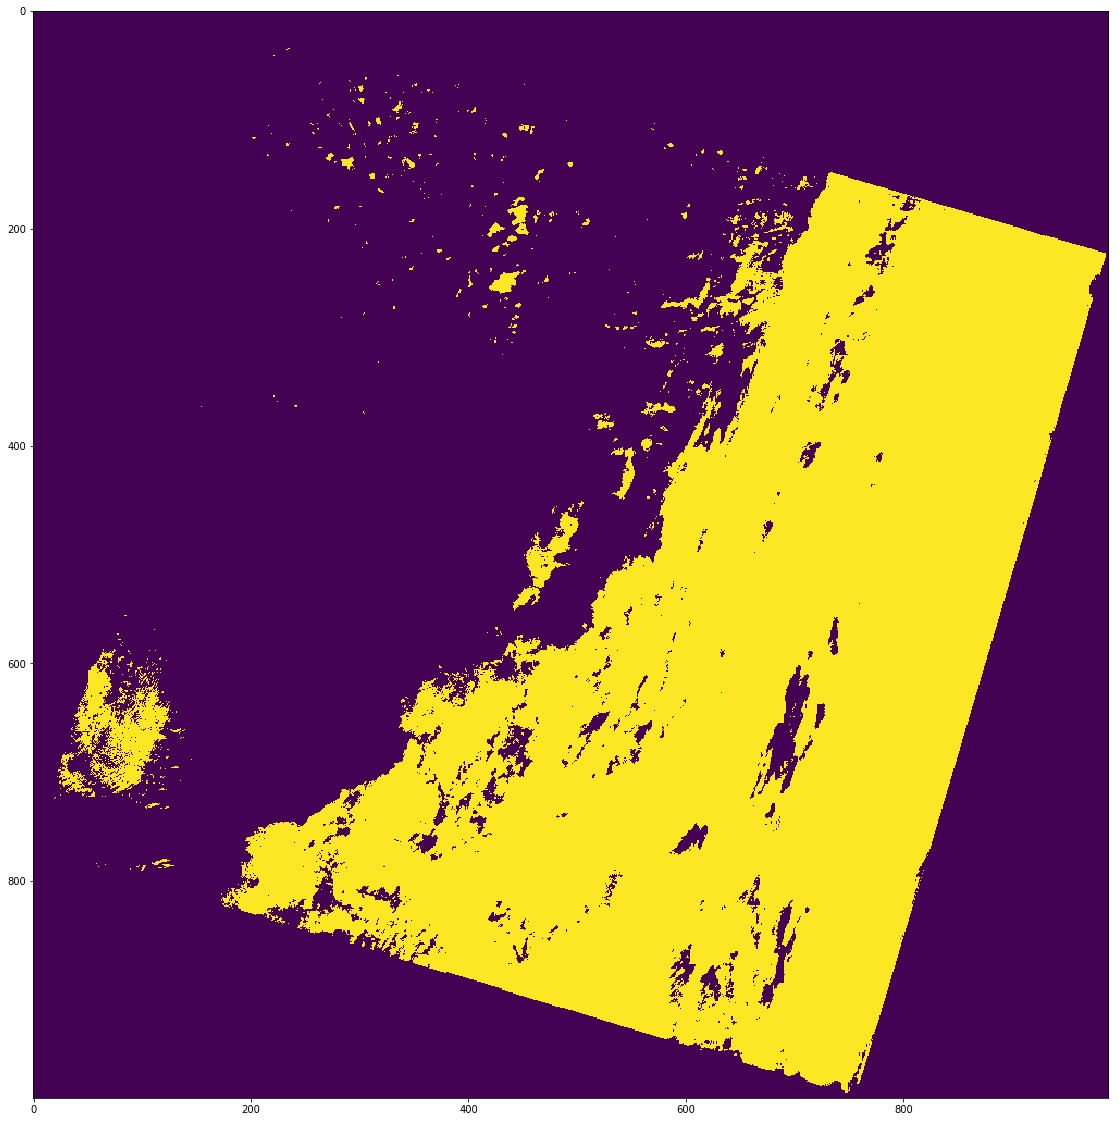

In [17]:
threshold = 0.1
project_path = '/home/jhj/phd/GitProjects/SentinelSemanticSegmentation/'
pred_unet = Image.open(project_path + 'data/output/Biome/LC80650182013237LGN00-model' + modelID + '-prediction.png')
threshold_time = []

# Threshold U-net prediction
pred_unet_np = np.array(pred_unet)

threshold_time_start = time.time()
pred_unet_thresholded_np = np.uint8(pred_unet_np >= threshold*65535)

# Convert predictions to PIL images again for plotting later        
pred_unet = Image.fromarray(pred_unet_np/255)
pred_unet_thresholded = Image.fromarray(pred_unet_thresholded_np*255) 


# Plot
thumbnail_res = 1000, 1000              

plt.figure(figsize=(20, 20))

pred_unet_thresholded.thumbnail(thumbnail_res, Image.NEAREST)
pred_unet_thresholded.save(project_path + 'reports/figures/predictions/LC80650182013237LGN00-model' + modelID + '-prediction_thresholded.png')
plt.imshow(pred_unet_thresholded)
plt.show()